Author: Roméo Juge (romeo.juge@proton.me)

In [1]:
### Import des librairies et fonctions utilisateur
import importlib
import myfun_OPERAT
importlib.reload(myfun_OPERAT)
from myfun_OPERAT import *

# Import variables stockées en mémoire (local)
%store -r OPERAT
%store -r df
%store -r CAP

# <font color=cyan>Import données</font>

- Import données OPERAT et formattage
- Import liste catégories et bornes

## <font color=yellow>Données OPERAT</font>

Cas où les données OPERAT sont en 1 seul fichier csv.

In [ ]:
file_path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\OID - Mission OPERAT 2023\4. BDD\Consommations OPERAT au 12092023_ envoi OID.xlsx"

print("Importing data...")
warnings.simplefilter(action="ignore", category=UserWarning)
OPERAT = pd.read_excel(file_path,
                  sheet_name = 0,
                  header = 0,
                  skiprows = 0,
                  dtype = object)
warnings.resetwarnings()
print("DATA IMPORT COMPLETE")

Cas où les données OPERAT sont divisées en plusieurs fichiers (par année par exemple). <br>
Import de chaque fichier séparément et concaténation en 1 seul dataframe.

In [43]:
# Import de tous les fichiers dans un dossier puis concaténation
path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\01. BDD OPERAT\20243101"
file_list = os.listdir(path)

OPERAT = pd.DataFrame()
for file in file_list:
    
    print("Importing '{}' ...".format(file))
    file_path = r"{}\{}".format(path, file)
    OPERAT_1Y = pd.read_csv(file_path, sep=';', encoding='utf_8', dtype='object')
    OPERAT = pd.concat([OPERAT, OPERAT_1Y])

OPERAT = OPERAT.sort_values('id')
OPERAT = OPERAT.reset_index(drop=True)

print("------------------------------")
print("Import complete")

Importing 'export_requete_2020_202402011403.csv' ...
Importing 'export_requete_2021_202402020941.csv' ...
Importing 'export_requete_2022_202402011154.csv' ...
Importing 'export_requete_reference_202402011249.csv' ...
------------------------------
Import complete


Conversion des colonnes au bon data type (float, int, date, string)

In [44]:
col_float = ["Surface moyenne annuelle catégorie d'activité majoritaire (m²)",
             "Surface moyenne annuelle catégorie d'activité secondaire (m²)",
             'Surface totale brute (m²)',
             'Surface moyenne annuelle totale chauffée',
             'Surface moyenne annuelle totale refroidie',
             'Surface moyenne annuelle totale froid process',
             "Surface moyenne annuelle sous-catégorie d'activité majoritaire (m²)",
             "Surface moyenne annuelle sous-catégorie d'activité secondaire (m²)",
             'Surface moyenne annuelle',
             'Consommation totale (kWh PCI)',
             'Ratio (kWh PCI / m2)',
             'Surface moyenne annuel  local vacant (m²)',
             'Surface moyenne annuelle catégorie "Stationnement" (m²)',
             'Electricite (kWh)',
             'Gaz naturel - reseaux (kWh)',
             'Gaz naturel liquefie (kg) - kWh',
             'Gaz propane (kg) - kWh',
             'Gaz propane (m3) - kWh',
             'Gaz butane (kg) - kWh',
             'Gaz butane (m3) - kWh',
             'Fioul domestique (l) - kWh',
             'Charbon - agglomeres et briquettes (kg)- kWh',
             'Houille (kg) - kWh',
             "Bois - Plaquettes d'industrie (kg) - kWh",
             'Bois - Plaquettes forestieres (kg) - kWh',
             'Bois - Granules (pellets) ou briquettes (kg) - kWh',
             'Bois - Buches (stere)-kWh',
             'Reseau de chaleur (kWh)',
             'Reseau de froid (kWh)',
             'Consommation usages chauffage (kWh PCI)',
             'Consommation usages refroidissement (kWh PCI)',
             'Consommation usages froid process (kWh PCI)',
             'Consommation totale IRVE']

col_int = ['id', 
           'ID interne EFA',
           'Nb sous categories distinctes',
           'Nb categories distinctes',
           'NB Bornes recharge IRVE']

col_date = ['Date de début de la déclaration']

col_not_string = col_float + col_int + col_date
col_string = [x for x in OPERAT.columns.to_list() if x not in col_not_string]

# Application des types de données attendus
for column in col_float:
    OPERAT[column] = OPERAT[column].astype('string').str.strip().str.replace(',','.').astype('float')

for column in col_int:
    OPERAT[column] = OPERAT[column].astype('string').str.strip().str.replace(',','.').astype('float').astype('Int32')

for column in col_date:
    OPERAT[column] = pd.to_datetime(OPERAT[column], dayfirst=True, errors='coerce')
        
for column in col_string:
    OPERAT[column] = OPERAT[column].astype('string').str.strip()

## <font color=yellow>Import liste catégories et bornes</font>

Import du fichier contenant la liste des catégories (CAP, SCAP, méta-catégories) et les bornes surfaciques

In [45]:
# Import de la liste des catégories et des bornes
file_path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\02. Méthodologie\bornes_CAP_v5.0.xlsx"

warnings.simplefilter(action="ignore")
CAP = pd.read_excel(file_path,
                  sheet_name = "Catégories & Sous-catégories",
                  header = 0,
                  skiprows = 0,
                  dtype = object)
warnings.resetwarnings()

# Corrections préliminaires (au cas où)
CAP = CAP.map(lambda x: x.replace("’", "'") if isinstance(x, str) else x, na_action="ignore")
CAP = CAP.map(lambda x: " ".join(x.split()) if isinstance(x, str) else x, na_action="ignore")
CAP = CAP.map(lambda x: x.strip() if isinstance(x, str) else x, na_action="ignore")

# Liste des CAP et SCAP possibles (v5)
list_CAP = CAP.loc[CAP["Type"] == "Catégorie"]["Catégories et sous-catégories"].value_counts().index.to_list()
list_SCAP = CAP.loc[CAP["Type"] == "Sous-Catégorie"]["Catégories et sous-catégories"].value_counts().index.to_list()

# stockage variable en mémoire (local)
%store CAP 

Stored 'CAP' (DataFrame)


# <font color=cyan>Traitement des données</font>

<font color=yellow>**Corrections préliminaires**</font>
- Formattage : suppression des lignes vides, conversion des apostrophes, suppression des espaces multiples, suppression des espaces en début et fin de chaîne de caractères
- Correction des CAP et SCAP :
    - Renommage des CAP pour qu'elles correspondent à la dernière version (v5.0)
    - Certaines SCAP sont en réalité des CAP : on remplace par la SCAP par défaut quand on en trouve
    - Renommage des SCAP pour qu'elles correspondent à la dernière version (v5.0)

<font color=yellow>**Scores de fiabilité**</font> <br>
<font color=greenyellow>*Score P&S*</font>
- Ajout des colonnes contenant le code de la CAP-M et de la CAP-S à la base
- Ajout de la colonne "PS Score" et calcul du score de fiabilité PS

<font color=greenyellow>*Score E*</font>
- Ajout de la colonne "E Score" et calcul du score de fiabilité E

## <font color=yellow>Corrections préliminaires</font>

Formattage : suppression des lignes vides, conversion des apostrophes, suppression des espaces multiples, suppression des espaces en début et fin de chaîne de caractères

In [46]:
OPERAT.dropna(axis=0, how="all", inplace=True) 
OPERAT = OPERAT.map(lambda x: x.replace("’", "'") if isinstance(x, str) else x, na_action="ignore")
OPERAT = OPERAT.map(lambda x: " ".join(x.split()) if isinstance(x, str) else x, na_action="ignore")
OPERAT = OPERAT.map(lambda x: x.strip() if isinstance(x, str) else x, na_action="ignore")

Ce bloc retourne les CAP et les SCAP qui ne sont pas dans la liste des options disponibles dans la version du fichier d'import csv importé plus haut.

In [49]:
#############################################################################################
######################### Liste des CAP et SCAP de la base ##################################
#############################################################################################

# Liste des colonnes contenant des CAP et des SCAP
col_CAP = ["Categorie d'activite majoritaire", "Categorie d'activite secondaire", "Categorie d'activite principale"]
col_SCAP = ["Sous Categorie d'activite majoritaire", "Sous-catégorie d'activité secondaire"]

# Liste des CAP renseignées dans la base
list_CAP_OPERAT = OPERAT[col_CAP[0]]
for i in range(1, len(col_CAP)):
    list_CAP_OPERAT = pd.concat([list_CAP_OPERAT, OPERAT[col_CAP[i]]])
list_CAP_OPERAT = list_CAP_OPERAT.value_counts().index.to_list() 

# Liste des SCAP renseignées dans la base
list_SCAP_OPERAT = OPERAT[col_SCAP[0]]
for i in range(1, len(col_SCAP)):
    list_SCAP_OPERAT = pd.concat([list_SCAP_OPERAT, OPERAT[col_SCAP[i]]])
list_SCAP_OPERAT = list_SCAP_OPERAT.value_counts().index.to_list() 

# CAP de la base qui ne sont pas dans la dernière version
print("CAP pas dans la liste des options possibles (v5) :\n")
print([x for x in list_CAP_OPERAT if x not in list_CAP])

# SCAP de la base qui ne sont pas dans la dernière version
print("\n---------------------------------------------------------------------------------------")
print("SCAP pas dans la liste des options possibles (v5) :\n")
[x for x in list_SCAP_OPERAT if x not in list_SCAP]

CAP pas dans la liste des options possibles (v5) :

['Commerces', 'Culture et spectacles', 'Vente et service automobile, moto, véhicules industriels, nautique', 'Audiovisuel']

---------------------------------------------------------------------------------------
SCAP pas dans la liste des options possibles (v5) :



['Cafétéria (service de boissons chaudes, sandwiches et plats à réchauffer au micro-ondes)',
 'Commerces',
 'Culture et spectacles',
 'Restauration en service continu en libre-service (avec plateaux) - Self',
 'Vente et service automobile, moto, véhicules industriels, nautique',
 'Audiovisuel']

Correction des CAP et SCAP :
- Renommage des CAP pour qu'elles correspondent à la dernière version (v5.0)
- Certaines SCAP sont en réalité des CAP : on remplace par la SCAP par défaut quand on en trouve
- Renommage des SCAP pour qu'elles correspondent à la dernière version (v5.0)
- (exécuter le bloc précédent après celui-ci pour vérifier les erreurs restantes)

In [48]:
#############################################################################################
######### Renommage des CAP pour qu'elles correspondent à la dernière version (v5) ###########
#############################################################################################
CAP_renaming = {"Enseignement secondaire": "Enseignement Secondaire",
                "Enseignement supérieur": "Enseignement Supérieur",
                "Gares routières": "Transport urbain de voyageurs (métro)",
                "Restauration": "Restauration - Débit de boissons",
                "Résidences de tourisme et de loisirs": "Résidence de tourisme et loisirs",
                "Santé et action sociale": "Santé - Etablissements médico-sociaux",
                "Résidences de tourisme et villages ou clubs de vacances": "Résidence de tourisme et loisirs"}

OPERAT[col_CAP] = OPERAT[col_CAP].replace(CAP_renaming)

#############################################################################################
####### Renomage des SCAP pour qu'elles correspondent à la dernière version (v5) ############
#############################################################################################

# Certaines sous-catégories sont en réalité des catégories. Lorsque c'est le cas, on remplace par la sous-catégorie par défaut.

# On renomme d'abord les SCAP (cette fonction ne va s'appliquer qu'aux SCAP qui sont des CAP)
OPERAT[col_SCAP] = OPERAT[col_SCAP].replace(CAP_renaming)

# Liste des SCAP renseignées par les assujettis dans OPERAT
col_SCAP_M = "Sous Categorie d'activite majoritaire"
col_SCAP_S = "Sous-catégorie d'activité secondaire"
list_SCAP_M = OPERAT[col_SCAP_M].value_counts().index.to_list()
list_SCAP_S = OPERAT[col_SCAP_S].value_counts().index.to_list()
list_SCAP_OPERAT = list(set(list_SCAP_M + list_SCAP_S))

# Pour chaque SCAP renseignée qui est dans la liste des CAP
for scap in [x for x in list_SCAP_OPERAT if x in list_CAP]:
    
    # On récupère le code de la CAP correspondante
    code_CAP = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == scap]["Code"].iloc[0]

    # Puis on récupère la liste des SCAP correspondant à cette CAP
    scap_list = CAP.loc[CAP["Type"] == "Sous-Catégorie"].loc[CAP["Code"].fillna("").str.contains(code_CAP)]["Catégories et sous-catégories"].to_list()

    # On sélectionne la SCAP par défaut (si elle existe, sinon, on passe) et on remplace dans les données OPERAT
    default_scap = [x for x in scap_list if 'defaut' in unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII').lower()]
    if len(default_scap) == 1:
        
        default_scap = default_scap[0]
    
        idx_m = OPERAT.loc[OPERAT[col_SCAP_M] == scap].index
        idx_s = OPERAT.loc[OPERAT[col_SCAP_S] == scap].index
        if len(idx_m) != 0:
            OPERAT.loc[idx_m, col_SCAP_M] = default_scap
        if len(idx_s) != 0:
            OPERAT.loc[idx_s, col_SCAP_S] = default_scap
    
    else:
        continue

# Renomage des SCAP pour qu'elles correspondent à la dernière version (v5)[
# {"ancien nom": "nouveau nom (à jour)"}
SCAP_renaming = {"Activité de santé libérale - Kinésithérapie, Rééducation fonctionnelle": "Activité de santé libérale - Kinésithérapie, Rééducation fonctionnelle,",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE = A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 3 (DE = B W/m²)": "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 3 (DE ≥ B W/m²)",
                 "Aéroport commercial - Tri bagages - Densité énergétique Niveau 1 (DE = A W/m²)": "Aéroport commercial - Tri bagages - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Tri bagages - Densité énergétique Niveau 3 (DE = B W/m²)": "Aéroport commercial - Tri bagages - Densité énergétique Niveau 3 (DE ≥ B W/m²)",
                 "Blanchisserie": "Blanchisserie industrielle (Valeur par défaut)",
                 "Collège": "Enseignement Secondaire (Valeur par défaut)",
                 "Commerces et service de détail - Accessoire de mode (Bijouterie, …) - Zone de vente": "Commerce et service de détail - Accessoire de mode (Bijouterie, …) - Zone de vente",
                 "Commerces et service de détail - Bien être (Sauna et Hammam) - Zone Public": "Commerce et service de détail - Bien être (Sauna -Hammam) - Zone Public",
                 "Commerce et service de détail  - Bien être (Sauna -Hammam) - Zone Public": "Commerce et service de détail - Bien être (Sauna -Hammam) - Zone Public",
                 "Commerces et service de détail - Culture, Média et Loisirs (Libraire, produits culturels, jeux et loisirs...) - Zone de vente": "Commerce et service de détail - Culture, Média et Loisirs (Libraire, produits culturels, jeux et loisirs...) - Zone de vente",
                 "Commerces et service de détail - Equipement de la personne (Vêtements, lingeries, linges de maison, chaussures, maroquinerie et bagages...) - Zone de vente": "Commerce et service de détail - Equipement de la personne (Vêtements, lingeries, linges de maison, chaussures, maroquinerie et bagages...) - Zone de vente",
                 "Commerces et service de détail - Equipement de la personne et Loisirs (Valeur par défaut)": "Commerce et service de détail - Equipement de la personne et Loisirs (Valeur par défaut)",
                 "Commerces et service de détail - Equipement de la personne et Loisirs - Administration et bureaux": "Commerce et service de détail - Equipement de la personne et Loisirs - Administration et bureaux",
                 "Commerces et service de détail - Equipement de la personne et Loisirs - Réserve d'approche": "Commerce et service de détail - Equipement de la personne et Loisirs - Réserve d'approche",
                 "Commerces et service de détail - Numérique et téléphonie - Zone vente": "Commerce et service de détail - Numérique et téléphonie - Zone vente",
                 "Commerces et service de détail - Santé Optique - Zone vente": "Commerce et service de détail - Santé Optique - Zone vente",
                 "Commerces et service de détail - Santé, Soins (Pharmacie, Parapharmacie) - Zone vente": "Commerce et service de détail - Santé, Soins (Pharmacie, Parapharmacie) - Zone vente",
                 "Commerces et service de détail - Service Conseil (Agences de voyages…) - Zone vente": "Commerce et service de détail - Service Conseil (Agences de voyages…) - Zone vente",
                 "Commerces et service de détail - Service Laverie automatique - Zone public": "Commerce et service de détail - Service Laverie automatique - Zone public",
                 "Commerces et service de détail - Service Pressing - Accueil public et process": "Commerce et service de détail - Service Pressing - Accueil public et process",
                 "Commerces et service de détail - Services Equipements de la personne (Cordonnerie, Couturier,…) - Accueil public et process": "Commerce et service de détail - Services Equipements de la personne (Cordonnerie, Couturier,…) - Accueil public et process",
                 "Commerces et service de détail - Soins & Beauté (Beauté & bien être) - Zone soins": "Commerce et service de détail - Soins & Beauté (Beauté & bien être) - Zone soins",
                 "Commerces et service de détail - Soins & Beauté (Parfumerie, cosmétique…) - Zone vente": "Commerce et service de détail - Soins & Beauté (Parfumerie, cosmétique…) - Zone vente",
                 "Commerces et service de détail - Soins de la personne (Coiffeur, Salon d'esthétique, Massage) - Zone vente": "Commerce et service de détail - Soins de la personne (Coiffeur, Salon d'esthétique, Massage) - Zone vente",
                 "Commerces et service de détail - Sports et Outdoor - Zone vente": "Commerce et service de détail - Sports et Outdoor - Zone vente",
                 "Enseignement Secondaire - Lycée d'enseignement général et techhnologique agricole (LGTA) - Lycée d'enseignement professionnel agricole (LEP agricole ) - Toutes séries confondues (Valeur Témoin)": "Enseignement Secondaire - Lycée d'enseignement général et technologique agricole (LGTA) - Lycée d'enseignement professionnel agricole (LEP agricole) - Toutes séries confondues (Valeur Témoin)",
                 "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 1 (DE = A W/m²)": "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 1 (DE ≤ A W/m²)",
                 "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 3 (DE = B W/m²)": "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 3 (DE ≥ B W/m²)",
                 "Gare ferroviaire - Zones de remisage couvertes et closes": "Gare ferroviaire - Zones de remisage couverte et close",
                 "Lycée d'enseignement général": "Enseignement Secondaire - Lycée d'enseignement général (LG) ou Salles d'enseignement banalisé - Toutes séries confondues (Valeur Témoin)",
                 "Lycée d'enseignement général et technologique – Lycée polyvalent": "Enseignement Secondaire - Lycée d'enseignement général et techhnologique (LGT) - Lycée d'enseignement polyvalent (LEP) - Toutes séries confondues (Valeur Témoin)",
                 "Lycée d'enseignement professionnel": "Enseignement Secondaire - Lycée d'enseignement professionnel",
                 "Salle serveur & Data Center (Valeur par défaut)": "Salle serveur & Data Center - Valeur par défaut",
                 "Stockage à température ambiante": "Logistique température ambiante",
                 "Transport urbain (Valeur par défaut)": "Transport urbain - Valeur par défaut",
                 "nseignement Secondaire - Salles de TP - Série SMS/ST2S Sciences médicosocial/ sciences et technologies de la santé et du social": "Enseignement Secondaire - Salles de TP - Série SMS/ST2S Sciences médicosocial/ scienes et technologies de la santé et du social",
                 "Radio - Studio d'enregistrement et de diffusion d'émissions radiophoniques avec public": "Radio -Studio d'enregistrement et de diffusion d'émissions radiophoniques avec public",
                 'Restaurant traditionnel ou Brasserie': 'Restaurant traditionnel - Brasserie',
                 'Hôtel 3 étoiles – Chambres et services': 'Hôtel 3 étoiles - Chambres et services (hors restauration)',
                 'Hôtel 4 étoiles– Chambres et services': 'Hôtel 4 étoiles - Chambres et services (hors restauration)',
                 'Hôtel 2 étoiles – Chambres et services': 'Hôtel 2 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Valeur par défaut': 'Résidence de tourisme, Village vacances, Club - ERP (Valeur par défaut)',
                 'Restauration et débits de boissons - Administration et bureaux (bureaux standard)': 'Restauration - Administration et bureaux',
                 'Hôtel 5 étoiles et plus – Chambres et services': 'Hôtel 5 étoiles et plus - Chambres et services (hors restauration)',
                 'Hôtel 1 étoile et non classé – Chambres et services': 'Hôtel 1 étoile - Chambres et services (hors restauration)',
                 'Hôtel - Administration et bureaux (bureaux standards)': 'Hôtel - Administration et bureaux',
                 'Restauration collective – Cuisine centrale': 'Restauration collective Santé - Cuisine centrale (plateau repas ou bacs)',
                 'Moyen Data Center (surface de salle IT comprise entre 1 000 m² à 5 000 m²)': 'Moyen Data Center (1000 m² < Surf < 5 000 m²)',
                 'Local serveurs (surface de salle IT inférieure à 20 m²)': 'Local serveur (Surf inf 20 m²)',
                 'Salle serveurs (surface de salle IT comprise entre 20 et 100 m²)': 'Salle serveur (20 m² < Surf < 100 m²)',
                 'Restauration sans service à la place (vente emportée ou livrée)': 'Restauration sans service à la place (vente emportée)',
                 'Mini Data Center (surface de salle IT comprise entre 100 et 500 m²)': 'Mini Data Center (100 m² < Surf < 500 m²)',
                 'Restauration et débit de boissons – Réserve – Température ambiante': 'Restauration - Réserve température ambiante',
                 'Résidence de tourisme, ERP, 3 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 3 étoiles - Chambres et services (hors restauration)',
                 'Hébergement touristique de courte durée - Administration et bureaux (bureaux standards)': 'Hébergement touristique de courte durée - Administration et bureaux',
                 'Restauration et débits de boisson – Réserve et/ou meubles froid positif': 'Restauration - Réserve et/ou meuble froid positif',
                 'Petit Data Center (surface de salle IT comprise entre 500 et 1 000 m²)': 'Petit Data Center (500 m² < Surf < 1000 m²)',
                 'Village ou club de vacances, ERP, 3 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 3 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Piscine intérieure': 'Résidence de tourisme ERP - Piscine intérieure',
                 'Résidences de tourisme, village ou club de vacances, ERP - Administration et bureaux (bureaux standard)': 'Résidence de tourisme ERP - Administration et bureaux',
                 'Restauration et débits de boisson – Réserve et/ou meubles froid négatif': 'Restauration - Réserve et/ou meuble froid négatif',
                 'Résidence de tourisme, ERP, 4 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 4 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, ERP, 1 étoile et non classé - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 1 étoile - Chambres et services (hors restauration)',
                 'Grand Data Center (surface de salle IT comprise entre 5 000 m² à 10 000 m²)': 'Grand Data Center (5 000 m² < Surf < 10 000 m²)',
                 'Très grand Data Center (surface de salle IT supérieure à 10 000 m²)': 'Très Grand Data Center ( Surf >10 000 m²)',
                 'Résidence de tourisme, ERP, 2 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 2 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Piscine extérieure chauffée': 'Résidence de tourisme ERP - Piscine extérieure chauffée',
                 'Résidences de tourisme, village ou club de vacances, ERP - Sauna et Hammam': 'Résidence de tourisme ERP - Sauna et Hammam',
                 'Village ou club de vacances, ERP, 4 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 4 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 1 étoile et non classé - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 1 étoile - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Salle de sport de pratique individuelle (Machines cardio et musculation)': 'Résidence de tourisme ERP - Salle de sport de pratique individuelle (Machines cardio et musculation)',
                 'Résidence de tourisme, ERP, 5 étoiles et plus - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 5 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 2 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 2 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 5 étoiles et plus - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 5 étoiles - Chambres et services (hors restauration)'
}

OPERAT[col_SCAP] = OPERAT[col_SCAP].replace(SCAP_renaming)

In [50]:
# stockage base de données corrigée en mémoire (locale)
%store OPERAT 
mem_use = round(OPERAT.memory_usage().sum()/1024**2,0)
print("Memory usage: {} MB".format(int(mem_use)))

Stored 'OPERAT' (DataFrame)
Memory usage: 310 MB


## <font color=yellow>Scores de fiabilité</font>

Ajout des colonnes contenant le code de la CAP-M et de la CAP-S à la base

In [58]:
# Nouvelle df pour traiter les données
df = copy.copy(OPERAT)

col_CAP_M = "Categorie d'activite majoritaire"
col_CAP_S = "Categorie d'activite secondaire"
col_SCAP_M = "Sous Categorie d'activite majoritaire"
col_SCAP_S = "Sous-catégorie d'activité secondaire"

# Ajout des codes pour la CAP-M et la CAP-S
df["Code CAP-M"] = np.nan
df["Code CAP-M"] = df["Code CAP-M"].astype('object')
df["Code CAP-S"] = np.nan
df["Code CAP-S"] = df["Code CAP-S"].astype('object')

list_CAP_M = df[col_CAP_M].value_counts().index.to_list()
list_CAP_S = df[col_CAP_S].value_counts().index.to_list()
list_CAP_OPERAT = list(set(list_CAP_M + list_CAP_S))

# Pour toutes les CAP-M ou CAP-S
for cap in list_CAP_M or cap in list_CAP_S:

    # Si la CAP est une CAP-M et est dans la liste des options possibles, la renseigner dans la df
    if cap in list_CAP and cap in list_CAP_M:
        code_cap = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == cap]["Code"].iloc[0]
        idx = df.loc[df[col_CAP_M] == cap].index
        df.loc[idx, "Code CAP-M"] = code_cap

    # Idem pour CAP-S
    if cap in list_CAP and cap in list_CAP_S:
        code_cap = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == cap]["Code"].iloc[0]
        idx = df.loc[df[col_CAP_S] == cap].index
        df.loc[idx, "Code CAP-S"] = code_cap 

### <font color=greenyellow>Score P&S</font>

Calcul du score P&S. Chaque bloc correspond à un niveau différent. Le niveau de chaque test est défini par n_test.

In [59]:
# Ajout de la colonne P&S
df["P&S Score"] = 0
df["P&S Score"] = df["P&S Score"].astype('Int8')

In [60]:
####################################################
# PS 1 : Surface totale brute positive renseignée
####################################################
n_test = 1
idx = df.loc[df["Surface totale brute (m²)"].fillna(0) > 0].index
df.loc[idx, "P&S Score"] = n_test

In [61]:
############################################################################
# PS 2 : CAP-M renseignée et CAP-M dans la liste des options disponbibles ? 
############################################################################
n_test = 2
df_extract = df.loc[df["P&S Score"] >= n_test-1] # données avec P&S >= 1
CAP_M_no_match = [x for x in df_extract[col_CAP_M].value_counts().index.to_list() if x not in list_CAP]
CAP_S_no_match = [x for x in df_extract[col_CAP_S].value_counts().index.to_list() if x not in list_CAP]
SCAP_M_no_match = [x for x in df_extract[col_SCAP_M].value_counts().index.to_list() if x not in list_SCAP]
SCAP_S_no_match = [x for x in df_extract[col_SCAP_S].value_counts().index.to_list() if x not in list_SCAP]

# Indices P&S = 2
idx = df_extract.loc[pd.isnull(df_extract[col_CAP_M])].index # indices CAP-M non renseignées
idx = idx.union(df_extract.loc[df_extract[col_CAP_M].isin(CAP_M_no_match)].index) # + indices CAP-M pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_CAP_S].isin(CAP_S_no_match)].index) # + indices CAP-S pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_SCAP_M].isin(SCAP_M_no_match)].index) # + indices SCAP-M pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_SCAP_S].isin(SCAP_S_no_match)].index) # + indices SCAP-S pas dans la liste
idx2 = df_extract.index.difference(idx) # Tous les indices de la df sauf ceux listés ci-dessus

# Attribution score
df.loc[idx2, "P&S Score"] = n_test

In [62]:
#####################################
# PS 3: les surfaces sont cohérentes
#####################################
n_test = 3
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[df_extract["Surface moyenne annuelle"].fillna(0) <= 1.005*df_extract["Surface totale brute (m²)"].fillna(0)].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [63]:
################################
# PS 4: L'EFA n'est pas vacante
################################
n_test = 4
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices des EFA non vacantes (marge d'erreur 1%)
idx_novac = df_extract.loc[df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0) < 0.99*df_extract["Surface moyenne annuelle"].fillna(0)].index

# indices des EFA avec 1 seule SCAP (et donc 1 seule CAP) dont la CAP-M ou la SCAP-M est = à "Local vacant" 
# (car même si la surface indique qu'elles sont non vacantes, leur CAP indique le contraire)
idx_vac1 = df_extract.loc[df_extract["Nb sous categories distinctes"] == 1].loc[(df_extract[[col_CAP_M, col_SCAP_M]] == "Local vacant").sum(axis=1) > 0].index

# Indices des EFA dont la CAP-M et la CAP-S sont = à "Local vacant" (même si une partie de l'EFA n'est pas vacante, on ne peut rien en tirer)
idx_vac2 = df_extract.loc[df_extract["Categorie d'activite majoritaire"] == "Local vacant"].loc[df_extract["Categorie d'activite secondaire"] == "Local vacant"].index

# On les ajoute aux indices précédent puis on les retire des indices des EFA non vacantes
idx_vac = idx_vac1.union(idx_vac2)
idx = idx_novac.difference(idx_vac)

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [64]:
############################################################
# PS 5: Période de reporting = 1 an (à 1% i.e. 5 jours près)
###########################################################
n_test = 5
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[(df_extract["Surface moyenne annuelle"] >= 0.99*df_extract["Surface totale brute (m²)"])].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [65]:
##################################################################
# PS 6: Surf brute comprise entre les bornes (1er filtre physique)
##################################################################
n_test = 6
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Définition des variables utiles
s_inf1 = 10 # m²
s_sup1 = 1e6

# Indices
idx = df_extract.loc[df_extract["Surface totale brute (m²)"].between(s_inf1, s_sup1)].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [66]:
############################################################
# PS 7: 2ème filtre physique (bornes dépendante de la CAP-M)
############################################################
n_test = 7
df_extract = copy.copy(df.loc[df["P&S Score"] >= n_test-1]) # Ici on crée une copie pour éviter les warnings

# Ajout des colonnes pour le calcul de S_inf et S_sup
df_extract["Surf non vac"] = np.nan # Surface non-vacante EFA
df_extract["Surf ratio CAP-M/EFA"] = np.nan # Ratio Surf CAP-M/Surf non-vacante EFA
df_extract["Surf ratio CAP-S/EFA"] = np.nan # Ratio Surf CAP-S/Surf non-vacante EFA
df_extract["Surf ratio CAP rest/EFA"] = np.nan # Ratio Surf autres CAP/Surf non-vacante EFA
df_extract["S_inf CAP-M"] = np.nan # Borne inf pour la CAP-M
df_extract["S_inf CAP-S"] = np.nan # Borne inf pour la CAP-S
df_extract["S_sup CAP-M"] = np.nan # Borne sup pour la CAP-M
df_extract["S_sup CAP-S"] = np.nan # Borne sup pour la CAP-S

# Surface EFA non vacante 
# (calculée sur surface moyenne annuelle car surface moyenne annuelle ~ surface totale brute désormais. Les autres lignes ont été filtrées)
df_extract["Surf non vac"] = df_extract["Surface moyenne annuelle"] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)

# Pour les EFA dont la CAP-M (ou la CAP-S) = Local vacant, on remplace la surface de la CAP-M (ou la CAP-S) par 0, pour éviter de retirer deux fois
# la surface vacante. Ce remplacement n'est effectué que dans df_extract et n'affecte donc pas df.
idx_vac_CAP_M = df_extract.loc[df_extract["Code CAP-M"] == "CAP00"].index
idx_vac_CAP_S = df_extract.loc[df_extract["Code CAP-S"] == "CAP00"].index
df_extract.loc[idx_vac_CAP_M, "Surface moyenne annuelle catégorie d'activité majoritaire (m²)"] = 0
df_extract.loc[idx_vac_CAP_S, "Surface moyenne annuelle catégorie d'activité secondaire (m²)"] = 0

# Calcul des ratios de surface
df_extract["Surf ratio CAP-M/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP-S/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP rest/EFA"] = (df_extract["Surf non vac"] 
                                         - df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)
                                         - df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0))/df_extract["Surf non vac"]

# On crée 2 dict comprenant la liste des codes CAP pour chaque borne surfacique (inf et sup)
dict_Sinf = {}
for S in CAP["S_inf (m²)"].value_counts().index.to_list():
    dict_Sinf[S] = CAP.loc[CAP["S_inf (m²)"] == S]["Code"].value_counts().index.to_list()
# On remplace 'Défaut' par sa valeur (min des autres bornes)
default_Sinf = min([x for x in CAP["S_inf (m²)"].value_counts().index.to_list() if isinstance(x, int) or isinstance(x, float)])
dict_Sinf[default_Sinf] = dict_Sinf.pop('Defaut') + dict_Sinf[default_Sinf]
# On ajoute une borne fictive (0) pour la CAP local vacant (pour éviter les erreurs dans la suite)
dict_Sinf[0] = ["CAP00"]

dict_Ssup = {}
for S in CAP["S_sup (m²)"].value_counts().index.to_list():
    dict_Ssup[S] = CAP.loc[CAP["S_sup (m²)"] == S]["Code"].value_counts().index.to_list()
# On remplace 'Défaut' par sa valeur (min des autres bornes) et Aucune par la borne sup 1 (définie dans un test P&S) précédent
default_Ssup = max([x for x in dict_Ssup.keys() if isinstance(x, int) or isinstance(x, float)])
dict_Ssup[default_Ssup] = dict_Ssup.pop('Defaut') + dict_Ssup[default_Ssup]
aucune_Ssup = s_sup1
dict_Ssup[aucune_Ssup] = dict_Ssup.pop('Aucune')
dict_Ssup[0] = ["CAP00"]

# Calcul bornes pour la CAP-M
for CAP_code in df_extract["Code CAP-M"].value_counts().index.to_list():
    
    # Indices des lignes qui ont cette CAP renseignée en CAP-M
    idx = df_extract.loc[df_extract["Code CAP-M"] == CAP_code].index
    
    # Liste des S_inf et S_sup possibles pour cette CAP
    S_inf_cap = [key for key in dict_Sinf if CAP_code in dict_Sinf[key]][0]
    S_sup_cap = [key for key in dict_Ssup if CAP_code in dict_Ssup[key]][0]
    
    # Renseignement des valeurs dans les colonnes ad hoc de df extract
    df_extract.loc[idx , "S_inf CAP-M"] = S_inf_cap
    df_extract.loc[idx , "S_sup CAP-M"] = S_sup_cap

# Calcul bornes pour la CAP-S (idem CAP-M)
for CAP_code in df_extract["Code CAP-S"].value_counts().index.to_list():
    idx = df_extract.loc[df_extract["Code CAP-S"] == CAP_code].index
    S_inf_cap = [key for key in dict_Sinf if CAP_code in dict_Sinf[key]][0]
    S_sup_cap = [key for key in dict_Ssup if CAP_code in dict_Ssup[key]][0]
    df_extract.loc[idx , "S_inf CAP-S"] = S_inf_cap
    df_extract.loc[idx , "S_sup CAP-S"] = S_sup_cap

# Calcul bornes EFA
df_extract["S_inf (m²)"] = (df_extract["Surf ratio CAP-M/EFA"].fillna(0)*df_extract["S_inf CAP-M"].fillna(0)
                                           + df_extract["Surf ratio CAP-S/EFA"].fillna(0)*df_extract["S_inf CAP-S"].fillna(0)
                                          + df_extract["Surf ratio CAP rest/EFA"].fillna(0)*default_Sinf)

df_extract["S_sup (m²)"] = (df_extract["Surf ratio CAP-M/EFA"].fillna(0)*df_extract["S_sup CAP-M"].fillna(0)
                                           + df_extract["Surf ratio CAP-S/EFA"].fillna(0)*df_extract["S_sup CAP-S"].fillna(0)
                                          + df_extract["Surf ratio CAP rest/EFA"].fillna(0)*default_Ssup)

# Certains bornes sont supérieures à la borne absolue (effets de bord) : on les plafonne à la borne absolue
df_extract.loc[df_extract["S_sup (m²)"].fillna(0) > s_sup1, "S_sup (m²)"] = s_sup1 

# Indices pour lesquels la surf non-vacante est comprise entre les bornes calculées
idx = df_extract.loc[df_extract["Surf non vac"].between(df_extract["S_inf (m²)"], df_extract["S_sup (m²)"])].index

# On écrit les bornes dans la df principale pour garder une trace (on travaillait sur l'extrait jusqu'ici)
df["S_inf (m²)"] = np.nan
df["S_sup (m²)"] = np.nan
df.loc[df_extract.index, ["S_inf (m²)", "S_sup (m²)"]] = df_extract[["S_inf (m²)", "S_sup (m²)"]]

# On renseigne le score 
df.loc[idx, "P&S Score"] = n_test

In [67]:
############################################################################
# PS 8: la surface a varié de moins d'un facteur X par rapport à l'année N-1
############################################################################
n_test = 8
df_extract = copy.copy(df.loc[df["P&S Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
col_to_compare = ['ID interne EFA', 'Nb categories distinctes', "Code CAP-M", "Code CAP-S"] # Colonnes qui doivent être les mêmes pour que CAP année N = CAP année N-1
x_surf_var = 2 # limite variation par rapport à l'année précédente

# Attribution du score à l'année de référence (pas d'année précédente) et à la 1ère année de déclaration (2020)
idx = df_extract.loc[df_extract['Annee Consommation'].isin(['Année de référence', '2020'])].index
df.loc[idx, "P&S Score"] = n_test

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()
years_not_ref_not_1st = years_not_ref[1:] # on enlève la 1ère année de déclaration (2020)

for year in years_not_ref_not_1st:

    print("")
    print("----------------------------------------")
    print(year)
    print("----------------------------------------")

    # On récupère l'année N-1
    if year == min(years_not_ref_not_1st):
        year_m1 = str(min(years_not_ref))
    else:
        year_m1 = str(year-1)
    year = str(year)

    # Extrait df sur années [N-1, N] (rq: PS >= n_test-1 déjà sélectionné)
    df_2Y = df_extract.loc[df_extract['Annee Consommation'].isin([year_m1, year])] 

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("Nb lignes: {}".format(n_declar))
    
    # Sélection des EFA ayant fait l'objet d'une déclaration les 2 années (N-1 et N)
    EFA_count = df_2Y['ID interne EFA'].value_counts() # Nb d'occurences de chaque EFA
    EFA_2Y = EFA_count[EFA_count == 2].index # EFA présentes les 2 années
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_2Y)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("Nb de lignes avec déclaration N-1: {}".format(n_declar))
    
    # Sélection des EFA dont la CAP n'a pas évolué entre les 2 années 
    df_2Y = df_2Y.sort_values(["ID interne EFA", "Annee Consommation"]) # df trié par ID EFA puis année de conso
    df_even = df_2Y[col_to_compare].fillna("").iloc[::2] # Lignes paires (i.e. année N-1)
    df_odd = df_2Y[col_to_compare].fillna("").iloc[1::2] # Lignes impaires (i.e. année N)
    df_compare = pd.concat([df_even.reset_index(), df_odd.reset_index()], axis=1) # concat des 2 (côte à côte)
    EFA_same_CAP = [] # liste des EFA dont le contenu des 2 est le même
    for col in col_to_compare[1:]: # On saute la colonne ID EFA
        mask = df_compare[col].iloc[:,0].eq(df_compare[col].iloc[:,1]) # lignes pour lesquelles le contenu de col est identique les 2 années
        EFA_same_CAP += df_compare[mask]["ID interne EFA"].iloc[:,0].to_list() # Ajout des EFA à la liste
    EFA_same_CAP = pd.Series(EFA_same_CAP) 
    EFA_count = EFA_same_CAP.value_counts() # Compte de chaque EFA dans la liste
    EFA_same_CAP_unique = EFA_count[EFA_count == len(col_to_compare[1:])].index # Si elles apparaîssent pour chaque col, alors on la garde
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_same_CAP_unique)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec même CAP: {}".format(n_declar))

    # Sélection des EFA dont la surface totale brute a varié de moins d'un facteur X entre N-1 et N
    df_2Y = df_2Y.sort_values(["Annee Consommation", "ID interne EFA"]) # df trié par année de conso puis par EFA
    id_EFA = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["ID interne EFA"]
    surf_N_m1 = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["Surface totale brute (m²)"]
    surf_N = df_2Y.loc[df_2Y["Annee Consommation"] == year].reset_index(drop=True)["Surface totale brute (m²)"]
    surf_change = surf_N/surf_N_m1
    EFA_surf_not_much_change = id_EFA.loc[surf_change[1/x_surf_var <= surf_change][surf_change <= x_surf_var].index].to_list()
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_surf_not_much_change)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec surface qui n'a pas trop varié: {}".format(n_declar))
    
    # Indice des lignes restantes (pour l'année N, pour laquelle on calcule le score, uniquement)
    idx = df_2Y.loc[df_2Y["Annee Consommation"] == year].index

    # Attribution du score PS
    df.loc[idx, "P&S Score"] = n_test


----------------------------------------
2021
----------------------------------------
Nb lignes: 192187
Nb de lignes avec déclaration N-1: 176349
et avec même CAP: 175598
et avec surface qui n'a pas trop varié: 175388

----------------------------------------
2022
----------------------------------------
Nb lignes: 142553
Nb de lignes avec déclaration N-1: 129478
et avec même CAP: 125902
et avec surface qui n'a pas trop varié: 125105


In [68]:
#######################################################################
# PS 9: Période de reporting commence au 1er janvier (marge de 5 jours)
#######################################################################
n_test = 9
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[df_extract['Date de début de la déclaration'].dt.month == 1].loc[df_extract['Date de début de la déclaration'].dt.day <= 5].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

### <font color=greenyellow>Score E</font>

Calcul du score E. Chaque bloc correspond à un niveau différent. Le niveau de chaque test est défini par n_test.

In [69]:
# Ajout de la colonne E
df["E Score"] = 0
df["E Score"] = df["E Score"].astype('Int8')

In [70]:
###########################################################
# E 1: P&S >= 5 et consommation totale non-nulle renseignée
###########################################################
idx = df.loc[df["P&S Score"] >= 5].loc[df["Consommation totale (kWh PCI)"].fillna(0) > 0].index
df.loc[idx, "E Score"] = 1

# On peut ensuite recalculer le ratio énergie (kWh EF PCI/m²) en prenant la surface non-vacante
df["Ratio (kWh PCI / m2) - Corrigé"] = np.nan
df.loc[idx, "Ratio (kWh PCI / m2) - Corrigé"] = df.loc[idx, "Consommation totale (kWh PCI)"]/(df["Surface moyenne annuelle"].loc[idx] - df["Surface moyenne annuel  local vacant (m²)"].loc[idx].fillna(0))

In [71]:
######################################################
# E 2: Ratio énergie compris entre les bornes absolues
######################################################
n_test = 2
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
e_inf = 10 # kWh PCI/m².an
e_sup = 1e5 # Borne max (pour data center)
n_IT = 1 # Borne max pour les autres CAP (en nombre de fois le max observé pour les data centers)

# On commence par appliquer les bornes aux EFA contenant des data centers
df_extract2 = df_extract.loc[df_extract['Dont Data Center'] == "Oui"] # EFA avec data center
idx = df_extract2.loc[df_extract2["Ratio (kWh PCI / m2) - Corrigé"].between(e_inf, e_sup)].index # indices des lignes avec conso entre les bornes
df.loc[idx, "E Score"] = n_test # attribution score E
df.loc[df_extract2.index, "E_inf abs (kWh/m².an)"] = e_inf # enregistrement des bornes abs dans la base
df.loc[df_extract2.index, "E_sup abs (kWh/m².an)"] = e_sup

# Puis on calcule la borne sup pour les autres EFA à partir de la conso max observée des data centers

# Choix périmètre : score PS max (on garde juste les période ne commençant pas au 1er janvier) --> 1 CAP --> CAP = CAP19 (data center) --> déclarations validées
df_extract2 = df_extract.loc[df_extract["P&S Score"] >= 7]
df_extract2 = df_extract2.loc[df_extract2['Nb categories distinctes'] == 1].loc[df_extract2['Code CAP-M'] == "CAP19"]
df_extract2 = df_extract2.loc[df_extract2["Statut"] == "Validée"]
max_IT = df_extract2["Ratio (kWh PCI / m2) - Corrigé"].max()
e_sup2 = round(n_IT*max_IT)

# Indices des lignes sans data center et avec conso entre les bornes
df_extract2 = df_extract.loc[df_extract['Dont Data Center'] == "Non"]
idx = df_extract2.loc[df_extract2["Ratio (kWh PCI / m2) - Corrigé"].between(e_inf, e_sup2)].index # indices des lignes avec conso entre les bornes
df.loc[idx, "E Score"] = n_test # attribution score E
df.loc[df_extract2.index, "E_inf abs (kWh/m².an)"] = e_inf # enregistrement des bornes abs dans la base
df.loc[df_extract2.index, "E_sup abs (kWh/m².an)"] = e_sup2

In [72]:
######################################################
# E 3: Ratio énergie compris entre les bornes relatives
######################################################
n_test = 3
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
n_std = 3 # Nombre d'écarts-types à conserver dans le filtre statistique
min_sample_size = 30 # Taille minimum de la distribution pour calculer des bornes stat

# Surface EFA non vacante 
# (calculée sur surface moyenne annuelle car surface moyenne annuelle ~ surface totale brute désormais. Les autres lignes ont été filtrées)
df_extract["Surf non vac"] = df_extract["Surface moyenne annuelle"] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)

# Pour les EFA dont la CAP-M (ou la CAP-S) = Local vacant, on remplace la surface de la CAP-M (ou de la CAP-S) par 0, pour éviter de retirer deux fois
# la surface vacante. Ce remplacement n'est effectué que dans df_extract et n'affecte donc pas df.
idx_vac_CAP_M = df_extract.loc[df_extract["Code CAP-M"] == "CAP00"].index
idx_vac_CAP_S = df_extract.loc[df_extract["Code CAP-S"] == "CAP00"].index
df_extract.loc[idx_vac_CAP_M, "Surface moyenne annuelle catégorie d'activité majoritaire (m²)"] = 0
df_extract.loc[idx_vac_CAP_S, "Surface moyenne annuelle catégorie d'activité secondaire (m²)"] = 0

# Calcul des ratios de surface
df_extract["Surf ratio CAP-M/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP-S/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP rest/EFA"] = (df_extract["Surf non vac"] 
                                         - df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)
                                         - df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0))/df_extract["Surf non vac"]

# Sélection du périmètre pour calcul des bornes : scores PS max --> 1 CAP --> déclarations validées
df_extract2 = df_extract.loc[df_extract["P&S Score"] >= 8] # On garde juste les EFA dont la période de déclaration ne commence pas au 1er janvier
df_extract2 = df_extract2.loc[df_extract2['Nb categories distinctes'] == 1]
df_extract2 = df_extract2.loc[df_extract2["Statut"] == "Validée"]

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract2['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()

# Pour chaque année de conso (y compris année de référence), calcul des bornes statistiques sur l'extrait 2 puis renseignement des bornes dans l'extrait 1
for year in df_extract['Annee Consommation'].unique():
  
    # Sélection du périmètre temporel pour cette année (plusieurs situations)
    # Si année de référence, on la prend toute seule (IL FAUDRA REFLECHIR A UN CALCUL DIFFERENT POUR L'ANNE DE REF A L'AVENIR)
    if year == 'Année de référence':
        year_range = [year]

    # Sinon, plusieurs cas
    else:
        year = int(year)
        # Si 1ère année de déclaration de la base (hors ref), on prend les années [1, 2, 3]
        if year == years_not_ref[0]:
            year_range = years_not_ref[:3]
        # Si dernière année de déclaration de la base (N), on prend les anénes [N-2, N-1, N] 
        elif year == years_not_ref[-1:]:
            year_range = years_not_ref[-3:]
        # Pour toute autre année n, on prend les années [n-1, n, n+1]
        else:
            year_range = [year-1, year, year+1]
        year_range = [str(x) for x in year_range]
        year = str(year)
    
    ####################################################################################
    ############################### Calcul des bornes ##################################
    ####################################################################################
    
    # Data pour calcul des bornes (extrait 2 avec périmètre restraint sur les années définies plus haut)
    df_3Y2 = df_extract2.loc[df_extract2['Annee Consommation'].isin(year_range)] 

    # Pour chaque CAP, calcul des bornes  
    list_code_cap = ('CAP' + df_3Y2['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list() # Trié comme dans le fichier Excel v5
    data_dict_3Y = {} # dict qui contiendra entre autre les bornes pour chaque CAP de la liste ci-dessus
    for code_cap in list_code_cap:

        # Sélection de la CAP
        df_cap = df_3Y2.loc[df_3Y2['Code CAP-M'] == code_cap]
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # nom abbrégé de la CAP
        
        # Calcul distribution symétrique, sa moyenne et son écart-type
        nrg = df_cap['Ratio (kWh PCI / m2) - Corrigé'] 
        e_inf_stat, e_sup_stat, mean_sym, std_sym, transform = sym_distrib(nrg, n_std)
        data_dict_3Y[cap_short] = [len(nrg), e_inf_stat, e_sup_stat, mean_sym, std_sym, transform]

    # On vérifie que chaque distribution (1 distribution par CAP) contient au minimum 30 lignes.
    cap_size_below_min = [key for key, value in data_dict_3Y.items() if value[0] < min_sample_size] # CAP pour lesquelles la taille de la distrib est inférieure au minimum
    
    # Si ce n'est pas le cas, on recalcule le log de chaque distribution et sa moyenne.
    # Puis on agrège les distributions de taille < 30 aux distributions de moyenne (du log) les plus proches
    if len(cap_size_below_min) > 0: 

        # Recalcul du log de chaque distrib et sa moyenne
        data_dict_3Y_log = {}
        for code_cap in list_code_cap:
            df_cap = df_3Y2.loc[df_3Y2['Code CAP-M'] == code_cap]
            cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0]
            nrg = df_cap['Ratio (kWh PCI / m2) - Corrigé']
            mean_log = np.log(nrg).mean() 
            data_dict_3Y_log[cap_short] = [len(df_cap), mean_log]
        
        # Agrégation des distributions qui n'ont pas la taille min à celles de moyenne la plus proche
        for cap_short in cap_size_below_min:

            # Nombre de lignes et moyenne du log pour la catégorie avec nombre de lignes insuffisant
            n_lines = data_dict_3Y_log[cap_short][0]
            mean_log = data_dict_3Y_log[cap_short][1]

            # Dict contenant l'écart à la moyenne (en valeur abs) pour toutes les autres CAP (pour trouver la plus proche)
            data_dict_3Y_log_diff = {key: [value[0], abs(value[1]-mean_log)] for key, value in data_dict_3Y_log.items() if key != cap_short}

            cap_size_below_min_all = [cap_short]
            n_lines2 = n_lines
            while n_lines2 < min_sample_size:
                cap_closest_mean = min(data_dict_3Y_log_diff, key=lambda k: data_dict_3Y_log_diff[k][1]) # CAP avec la moyenne (du log) la plus proche (écart min)
                n_lines2 += data_dict_3Y_log_diff[cap_closest_mean][0] # On ajoute le nombre de lignes de cette CAP à celui de la CAP qui n'a pas le nb minimum de lignes
                cap_size_below_min_all.append(cap_closest_mean) # On ajoute cette CAP à la liste
                data_dict_3Y_log_diff.pop(cap_closest_mean) # on la retire du dict

            # On convertit la lsite de noms de CAP en liste de code CAP
            cap_size_below_min_all_code = []
            for cap_short2 in cap_size_below_min_all:
                code_cap = CAP.loc[CAP["Catégories abrégées"] == cap_short2]["Code"].iloc[0]
                cap_size_below_min_all_code.append(code_cap)
            
            # Distribution contenant les conso de la CAP avec nombre de lignes < minimum et celles de la (des) CAP de moyenne (du log) la plus proche  
            nrg = df_3Y2.loc[df_3Y2['Code CAP-M'].isin(cap_size_below_min_all_code)]['Ratio (kWh PCI / m2) - Corrigé']
            
            # Calcul des bornes sur cette distrib et inscription de ces bornes dans le dict (en écrasant les valeurs précédemment calculées)
            e_inf_stat, e_sup_stat, mean_sym, std_sym, transform = sym_distrib(nrg, n_std) 
            data_dict_3Y[cap_short] = [len(nrg), e_inf_stat, e_sup_stat, mean_sym, std_sym, transform]

    ####################################################################################
    ########################## Renseignement des bornes ################################
    ####################################################################################
    
    # Data pour le renseignement des bornes (Attention : les bornes pour 1 CAP donnée sont calculée sur des plages de 3 ans mais on les applique à une année donnée)
    df_1Y = copy.copy(df_extract.loc[df_extract['Annee Consommation'] == year])

    # Bornes pour la CAP-M
    df_1Y["E_inf CAP-M"] = np.nan
    df_1Y["E_sup CAP-M"] = np.nan
    df_1Y_CAP_M = df_1Y.loc[df_1Y['Code CAP-M'].fillna("") != ""] # filtre sur les EFA avec une CAP-M renseignée (c'est le cas de toutes normalement)
    for code_cap in df_1Y_CAP_M['Code CAP-M'].unique(): # pour chaque CAP-M renseignée
        idx = df_1Y_CAP_M.loc[df_1Y_CAP_M['Code CAP-M'] == code_cap].index # indices des lignes avec cette CAP pour CAP-M
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # Nom abbrégé de la CAP
        if code_cap != "CAP00": # pas de bornes pour les locaux vacants
            e_inf_stat = data_dict_3Y[cap_short][1]
            e_sup_stat = data_dict_3Y[cap_short][2]
            df_1Y.loc[idx, "E_inf CAP-M"] = e_inf_stat
            df_1Y.loc[idx, "E_sup CAP-M"] = e_sup_stat
        
    # Bornes pour la CAP-S
    df_1Y["E_inf CAP-S"] = np.nan
    df_1Y["E_sup CAP-S"] = np.nan
    df_1Y_CAP_S = df_1Y.loc[df_1Y['Code CAP-S'].fillna("") != ""] # filtre sur les EFA avec une CAP-S
    for code_cap in df_1Y_CAP_S['Code CAP-S'].unique(): # pour chaque CAP-S renseignée
        idx = df_1Y_CAP_S.loc[df_1Y_CAP_S['Code CAP-S'] == code_cap].index # indices des lignes avec cette CAP pour CAP-M
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # Nom abbrégé de la CAP
        if code_cap != "CAP00": # pas de bornes pour les locaux vacants
            e_inf_stat = data_dict_3Y[cap_short][1]
            e_sup_stat = data_dict_3Y[cap_short][2]
            df_1Y.loc[idx, "E_inf CAP-S"] = e_inf_stat
            df_1Y.loc[idx, "E_sup CAP-S"] = e_sup_stat
    
    # Bornes par défaut (pour les EFA avec plus de 2 CAP renseignées)
    default_e_inf_stat = min(values[1] for values in data_dict_3Y.values())
    default_e_sup_stat = max(values[2] for values in data_dict_3Y.values())

    # Calcul bornes EFA (combinaison linéaire des bornes de la CAP-M, CAP-S et CAP reste)
    df_1Y["E_inf stat (kWh/m².an)"] = (df_1Y["Surf ratio CAP-M/EFA"].fillna(0)*df_1Y["E_inf CAP-M"].fillna(0)
                                               + df_1Y["Surf ratio CAP-S/EFA"].fillna(0)*df_1Y["E_inf CAP-S"].fillna(0)
                                              + df_1Y["Surf ratio CAP rest/EFA"].fillna(0)*default_e_inf_stat)
    
    df_1Y["E_sup stat (kWh/m².an)"] = (df_1Y["Surf ratio CAP-M/EFA"].fillna(0)*df_1Y["E_sup CAP-M"].fillna(0)
                                               + df_1Y["Surf ratio CAP-S/EFA"].fillna(0)*df_1Y["E_sup CAP-S"].fillna(0)
                                              + df_1Y["Surf ratio CAP rest/EFA"].fillna(0)*default_e_sup_stat)
    
    # On plafonne les bornes stat par les bornes absolues
    idx = df_1Y.loc[df_1Y["E_inf stat (kWh/m².an)"] < df_1Y["E_inf abs (kWh/m².an)"]].index # indices des lignes avec borne inf < borne absolue
    df_1Y.loc[idx, "E_inf stat (kWh/m².an)"] = df_1Y["E_inf abs (kWh/m².an)"].loc[idx]

    idx = df_1Y.loc[df_1Y["E_sup stat (kWh/m².an)"] > df_1Y["E_sup abs (kWh/m².an)"]].index # indices des lignes avec borne sup > borne absolue
    df_1Y.loc[idx, "E_sup stat (kWh/m².an)"] = df_1Y["E_sup abs (kWh/m².an)"].loc[idx]

    # On écrit les bornes dans l'extrait 1 pour garder une trace (on travaillait sur l'extrait sur 1 année jusqu'ici)
    col_to_copy = ["E_inf CAP-M", "E_sup CAP-M", "E_inf CAP-S", "E_sup CAP-S", "E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]
    df_extract.loc[df_1Y.index, col_to_copy] = df_1Y[col_to_copy]

# On a maintenant calculé les bornes stat pour chaque EFA. On les copie dans la df principale depuis l'extrait 1 pour garder une trace
df.loc[df_extract.index, ["E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]] = df_extract[["E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]]

# Indices des lignes pour lesquelles la conso est comprise entre les bornes stat
idx = df_extract.loc[df_extract['Ratio (kWh PCI / m2) - Corrigé'].between(df_extract["E_inf stat (kWh/m².an)"], df_extract["E_sup stat (kWh/m².an)"])].index

# Inscription du score E
df.loc[idx, "E Score"] = n_test

In [73]:
####################################################################################
# E 4: la conso surfacique a varié de moins d'un facteur X par rapport à l'année N-1
####################################################################################
n_test = 4
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
x_nrg_var = 2 # limite variation par rapport à l'année précédente

# Attribution du score à l'année de référence (pas d'année précédente) et à la 1ère année de déclaration (2020)
idx = df_extract.loc[df_extract['Annee Consommation'].isin(['Année de référence', '2020'])].loc[df_extract["P&S Score"] >= 8].index
df.loc[idx, "E Score"] = n_test

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()
years_not_ref_not_1st = years_not_ref[1:] # on enlève la 1ère année de déclaration (2020)

for year in years_not_ref_not_1st:
    
    # On récupère l'année N-1
    if year == min(years_not_ref_not_1st):
        year_m1 = str(min(years_not_ref))
    else:
        year_m1 = str(year-1)
    year = str(year)
    
    print("")
    print("----------------------------------------")
    print(year)
    print("----------------------------------------")
    

    n_declar = len(df_extract.loc[df_extract['Annee Consommation'] == year])
    print("Nb lignes: {}".format(n_declar))
    
    # On récupère la liste des EFA telles que la déclaration en année N a un score PS >= 8 et celle en année N-1 a un score PS >= 7
    # (permet de s’assurer que la surface de l’année N-1 est cohérente, même si elle a trop varié par rapport à N-2 ou que la CAP a changé entre N-2 et N-1)
    EFA_N = df_extract.loc[df_extract['Annee Consommation'] == year].loc[df_extract['P&S Score'] >= 8]["ID interne EFA"].to_list()
    EFA_N_m1 = df_extract.loc[df_extract['Annee Consommation'] == year_m1].loc[df_extract['P&S Score'] >= 7]["ID interne EFA"].to_list()
    
    # EFA qui sont dans les 2 listes (ne pas utiliser list comprehension : trop lent)
    EFA_count = EFA_list = pd.Series(EFA_N + EFA_N_m1).value_counts()
    EFA_list = EFA_count[EFA_count == 2].index

    # Extrait df sur ces EFA et les 2 années (N-1 et N)
    df_2Y = df_extract.loc[df_extract["ID interne EFA"].isin(EFA_list)].loc[df_extract['Annee Consommation'].isin([year_m1, year])]

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("avec PS >= 8 et déclaration N-1 avec PS >= 7: {}".format(n_declar))
    
    # Sélection des EFA dont la conso a varié de moins d'un facteur X entre N-1 et N
    df_2Y = df_2Y.sort_values(["Annee Consommation", "ID interne EFA"]) # df trié par année de conso puis par EFA
    id_EFA = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["ID interne EFA"]
    nrg_N_m1 = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)['Ratio (kWh PCI / m2) - Corrigé']
    nrg_N = df_2Y.loc[df_2Y["Annee Consommation"] == year].reset_index(drop=True)['Ratio (kWh PCI / m2) - Corrigé']
    nrg_change = nrg_N/nrg_N_m1
    EFA_nrg_not_much_change = id_EFA.loc[nrg_change[1/x_nrg_var <= nrg_change][nrg_change <= x_nrg_var].index].to_list()
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_nrg_not_much_change)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec conso qui n'a pas trop varié: {}".format(n_declar))
    
    # Indice des lignes restantes (pour l'année N, pour laquelle on calcule le score, uniquement)
    idx = df_2Y.loc[df_2Y["Annee Consommation"] == year].index
    
    # Attribution du score PS
    df.loc[idx, "E Score"] = n_test


----------------------------------------
2021
----------------------------------------
Nb lignes: 191475
avec PS >= 8 et déclaration N-1 avec PS >= 7: 162515
et avec conso qui n'a pas trop varié: 156085

----------------------------------------
2022
----------------------------------------
Nb lignes: 142355
avec PS >= 8 et déclaration N-1 avec PS >= 7: 115539
et avec conso qui n'a pas trop varié: 107976


In [74]:
# stockage base de données avec bornes et scores en mémoire (locale)
%store df
mem_use = round(df.memory_usage().sum()/1024**2,0)
print("Memory usage: {} MB".format(int(mem_use)))

Stored 'df' (DataFrame)
Memory usage: 364 MB


# <font color=cyan>Export de données</font>

Export de la base de données corrigée, incluant les nouvelles colonnes comprenant les données suivantes :
- Code catégories d'activité majoritaire et secondaire
- Scores PS et E
- Bornes surfaciques (test PS7)
- Bornes énergie (tests E2 et E3)
- Ratio consommation (kWh/m²) corrigé des surfaces vacantes

In [17]:
date_export = "31012024"
path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\01. BDD OPERAT\20243101"

print("Export in progress...")
df = df.sort_values("id")
df.to_csv(path + r"\OPERAT_export_{}_processed.csv".format(date_export), index=False, sep=';')
print("Export complete")

Export in progress...
Export complete


# <font color=cyan>Analyse des données</font>

## <font color=yellow>Base de données OPERAT</font>

### <font color=greenyellow>Présentation des données</font>

In [2]:
# Date de réception des données
date = "31 janvier 2024"

# Nb total de déclarations
n_declar = len(df)

# Nb total d'EFA
n_efa = len(df["ID interne EFA"].unique())

# % de déclarations validées
part_valide = int(round(len(df.loc[df["Statut"] == "Validée"])/len(df)*100, 0))

# % d'EFA ayant déclaré une année de référence
n_efa_ref = len(df.loc[df["Annee Consommation"] == "Année de référence"]["ID interne EFA"].value_counts().index)
part_efa_ref_declar = int(round(n_efa_ref/n_efa*100,0))


print("Au {}, {} déclarations avaient été effectuées sur OPERAT (dont {}% sont validées). Celles-ci représentent {} EFA, parmi lesquelles {}% ont une consommation de référence renseignée".format(date, n_declar, part_valide, n_efa, part_efa_ref_declar))

Au 31 janvier 2024, 739700 déclarations avaient été effectuées sur OPERAT (dont 76% sont validées). Celles-ci représentent 235483 EFA, parmi lesquelles 65% ont une consommation de référence renseignée


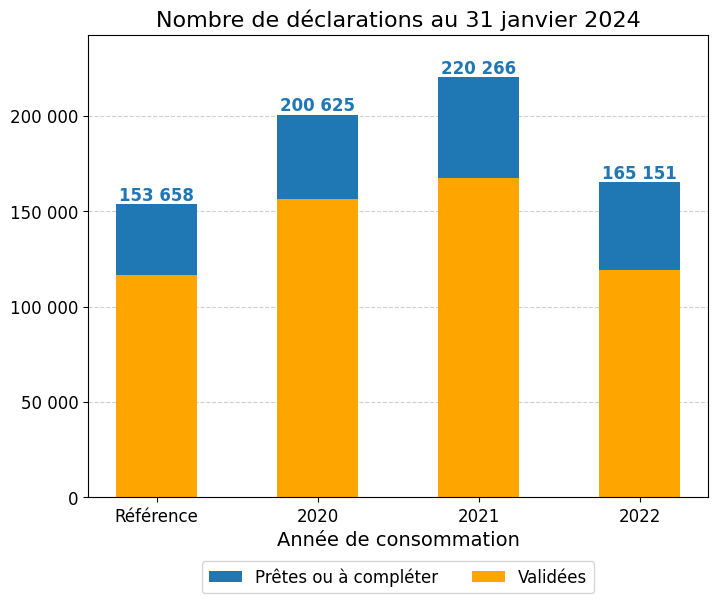

In [34]:
# Nombre de déclarations (nb de lignes) et % de déclaration validées par année de consommation
years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

count = {}
for year in years:
    df_1Y = df.loc[df["Annee Consommation"] == year]
    n_declar = len(df_1Y)
    part_valide = len(df_1Y.loc[df_1Y["Statut"] == "Validée"])
    count[year] = [n_declar, part_valide]
count = pd.DataFrame(count, index=["Nb déclarations", "Nb validées"]).T.rename(index={'Année de référence': 'Référence'})

# Create an array of indices for the bars
indices = np.arange(len(count))

# Specify the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting
width = 0.5  # Adjust the width of the bars as needed
bars1 = ax.bar(indices, count['Nb déclarations'], width=width, label='Prêtes ou à compléter', zorder=2)
bars2 = ax.bar(indices, count['Nb validées'], width=width, label='Validées', color='orange', zorder=2)

# Customize the plot
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Nombre de déclarations au {}".format(date), fontsize=16)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)

# Set axis ticks and labels
ax.set_xticks(indices)
ax.set_xticklabels(count.index)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add thousands separators to y-axis labels
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' ')))

# Add labels within the bars in white
for bar in bars1.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
            format(int(bar.get_height()), ',').replace(',', ' '), 
            ha='center', va='bottom', color='tab:blue', weight='bold', fontsize=12, zorder=3)

# Display the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=12)

ax.set_ylim(0, count.values.max()*1.1)  # Adjust the limits as needed

# Display the plot
plt.show()

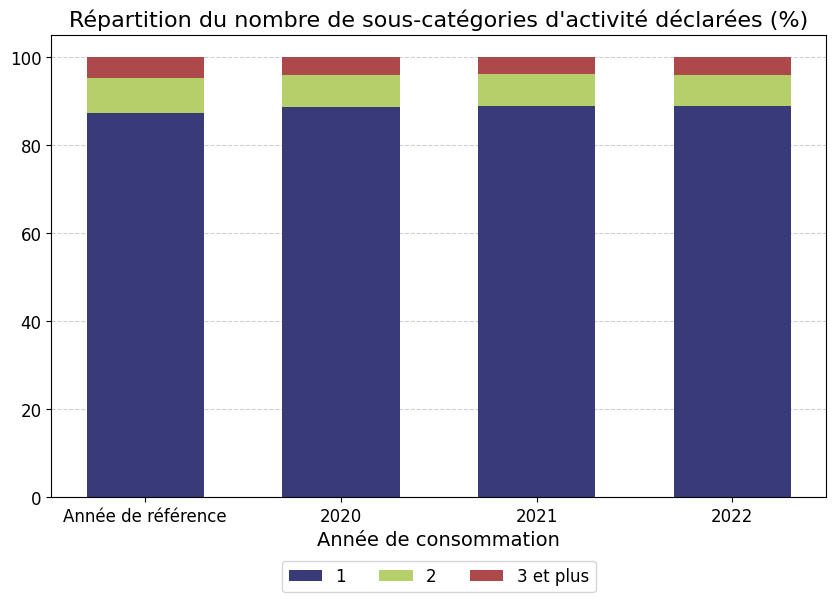

In [236]:
# Répartition du nombre de SCAP déclarées par année de consommation
years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

group_above = 2
count = {}
for year in years:
    df_1Y = df.loc[df["Annee Consommation"] == year].loc[df['Nb categories distinctes'].fillna(0) > 0]   
    repart = df_1Y['Nb categories distinctes'].value_counts().sort_index()
    repart = pd.concat([repart[:group_above], pd.Series([repart[group_above:].sum()], index=["{} et plus".format(group_above+1)])])
    repart = repart/repart.sum()
    count[year] = round(repart*100,2)
count = pd.DataFrame(count)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.6
colormap = 'tab20b'  # Change to your desired colormap
for i, n_scap in enumerate(count.index):
    bottom_values = count.iloc[:i, :].sum(axis=0)
    ax.bar(count.columns, count.loc[n_scap], label=n_scap, bottom=bottom_values, width=width, zorder=2, color=plt.get_cmap(colormap)(i/len(count.index)))
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Répartition du nombre de sous-catégories d'activité déclarées (%)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(count), fontsize=12)
plt.show()

In [243]:
df['Nb categories distinctes'].value_counts()/len(df)*100

Nb categories distinctes
1     86.153981
2      7.163309
0      2.617277
3      2.451129
4      0.966067
5      0.407192
6      0.142761
7      0.057591
8      0.022442
9      0.011491
10     0.002974
11     0.001622
14     0.001352
13     0.000811
Name: count, dtype: float64

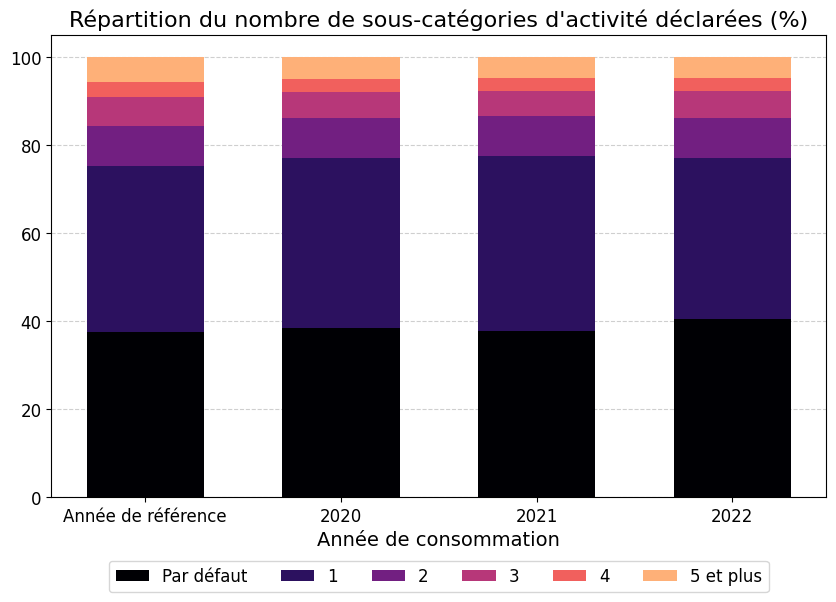

In [9]:
# Répartition du nombre de SCAP déclarées par année de consommation
years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

count = {}
for year in years:
    df_1Y = df.loc[df["Annee Consommation"] == year].loc[df['Nb sous categories distinctes'].fillna(0) > 0]
    n_declar = len(df_1Y)
    
    repart = df_1Y['Nb sous categories distinctes'].value_counts().sort_index()
    
    n_defaut = len(df_1Y.loc[df_1Y['Nb sous categories distinctes'] == 1].loc[df_1Y["Sous Categorie d'activite majoritaire"].dropna().str.contains('défaut')])
    repart.loc[1] = repart[1] - n_defaut
    repart = pd.concat([pd.Series([n_defaut], index=["Par défaut"]), repart])
    repart = pd.concat([repart[:5], pd.Series([repart[5:].sum()], index=["5 et plus"])])
    repart = repart/repart.sum()
    count[year] = round(repart*100,2)

count = pd.DataFrame(count)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.6
colormap = 'magma'  # Change to your desired colormap
for i, n_scap in enumerate(count.index):
    bottom_values = count.iloc[:i, :].sum(axis=0)
    ax.bar(count.columns, count.loc[n_scap], label=n_scap, bottom=bottom_values, width=width, zorder=2, color=plt.get_cmap(colormap)(i/len(count.index)))
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Répartition du nombre de sous-catégories d'activité déclarées (%)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(count), fontsize=12)
plt.show()

### <font color=greenyellow>Fiabilité des données</font>

#### <font color=pink>Analyse de fiabilité</font>

In [6]:
# Analyse de fiabilité
idx = df["P&S Score"].value_counts().sort_index().index
col = df["E Score"].value_counts().sort_index().index
cutoff_lines = pd.DataFrame(index = idx, columns = col)
cutoff_lines_valide = pd.DataFrame(index = idx, columns = col)

n_lines_tot = len(df)
surf_tot = df['Surface totale brute (m²)'].fillna(0).sum()
nrg_tot = df["Consommation totale (kWh PCI)"].fillna(0).sum()
for PS in idx:

    for E in col:

        df_extract = df.loc[df["P&S Score"] >= PS].loc[df["E Score"] >= E]
        df_extract_valide = df_extract.loc[df_extract["Statut"] == "Validée"]
        
        n_lines_left = len(df_extract)
        n_lines_left_valide = len(df_extract_valide)
        
        ratio_lines_left = round(n_lines_left/n_lines_tot*100, 1)
        ratio_lines_left_valide = round(n_lines_left_valide/n_lines_tot*100, 1)
        
        cutoff_lines.loc[PS, E] = ratio_lines_left
        cutoff_lines_valide.loc[PS, E] = ratio_lines_left_valide

cutoff_lines.loc[:4,1:] = ""
cutoff_lines.loc[:7,4:] = ""
cutoff_lines_valide.loc[:4,1:] = ""
cutoff_lines_valide.loc[:7,4:] = ""

print("---------------------------------------------------------")
print("Nb de lignes restantes après chaque test")
print("---------------------------------------------------------")
display(cutoff_lines)

print("---------------------------------------------------------")
print("Nb de lignes restantes après chaque test (déclarations validées)")
print("---------------------------------------------------------")
display(cutoff_lines_valide)

---------------------------------------------------------
Nb de lignes restantes après chaque test
---------------------------------------------------------


E Score        0     1     2     3     4
P&S Score                               
0          100.0                        
1           97.2                        
2           97.0                        
3           96.4                        
4           95.7                        
5           94.3  92.2  89.2  88.0      
6           94.2  92.0  89.1  87.9      
7           88.0  86.2  83.5  82.5      
8           83.4  81.9  79.5  78.6  76.0
9           77.9  76.5  74.3  73.5  71.1

---------------------------------------------------------
Nb de lignes restantes après chaque test (déclarations validées)
---------------------------------------------------------


E Score       0     1     2     3     4
P&S Score                              
0          75.7                        
1          75.7                        
2          75.5                        
3          75.0                        
4          74.5                        
5          73.4  72.8  70.8  70.0      
6          73.3  72.7  70.7  69.9      
7          68.7  68.2  66.3  65.6      
8          65.9  65.5  63.8  63.1  61.2
9          61.6  61.2  59.6  59.0  57.2

## <font color=yellow>Répartition des données déclarées</font>

### <font color=greenyellow>Répartition par année de consommation</font>

#### <font color=pink>Surface et consommation totales</font>

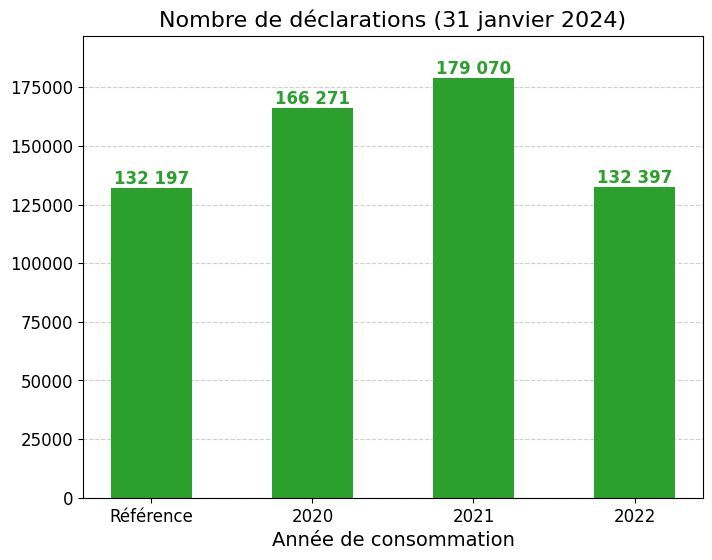

In [227]:
date = "31 janvier 2024"
df_extract = df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3]

years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

count = {}
for year in years:
    df_extract_1Y = df_extract.loc[df_extract["Annee Consommation"] == year]
    n_EFA = len(df_extract_1Y)
    surf = df_extract_1Y['Surface totale brute (m²)'].sum()/1e6
    EF = df_extract_1Y['Consommation totale (kWh PCI)'].sum()/1e9
    count[year] = [n_EFA, surf, EF]
count = pd.DataFrame(count, index=["Nb EFA", "Surface totale brute (million m²)", "Energie finale (TWh PCI)"]).T.rename(index={'Année de référence': 'Référence'})

# Plot 1
fig, ax = plt.subplots(figsize=(8, 6))
indices = np.arange(len(count))
width = 0.5  # Adjust the width of the bars as needed
bars = ax.bar(indices, count["Nb EFA"], width=width, zorder=2, color='tab:green')
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Nombre de déclarations ({})".format(date), fontsize=16)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.set_xticks(indices)
ax.set_xticklabels(count.index)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
            format(int(round(bar.get_height(),0)), ',').replace(',', ' '), 
            ha='center', va='bottom', fontsize=12, zorder=3, color='tab:green', weight='bold')
ax.set_ylim(0, count["Nb EFA"].max()*1.1)  # Adjust the limits as needed
plt.show()

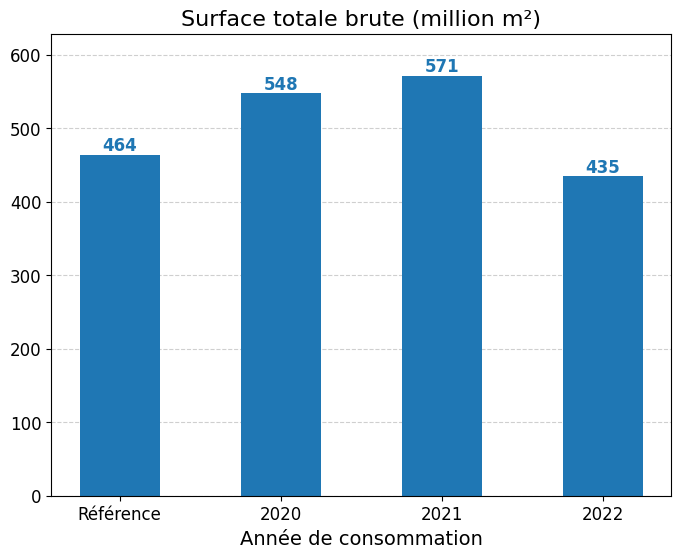

In [224]:
# Plot 2
fig, ax = plt.subplots(figsize=(8, 6))
indices = np.arange(len(count))
width = 0.5  # Adjust the width of the bars as needed
bars = ax.bar(indices, count["Surface totale brute (million m²)"], width=width, zorder=2, color='tab:blue')
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Surface totale brute (million m²)", fontsize=16)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.set_xticks(indices)
ax.set_xticklabels(count.index)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
            format(int(round(bar.get_height(),0)), ',').replace(',', ' '), 
            ha='center', va='bottom', fontsize=12, zorder=3, color='tab:blue', weight='bold')
ax.set_ylim(0, count["Surface totale brute (million m²)"].max()*1.1)  # Adjust the limits as needed
plt.show()

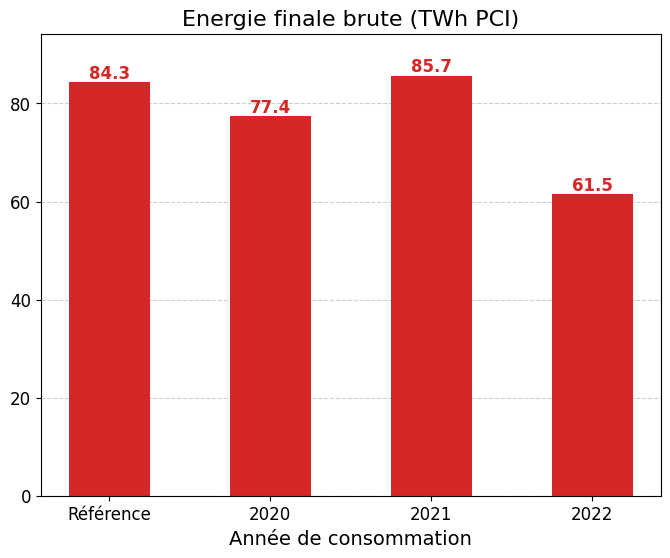

In [225]:
# Plot 3
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.5  # Adjust the width of the bars as needed
bars = ax.bar(indices, count["Energie finale (TWh PCI)"], color='tab:red', width=width, zorder=2)
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Energie finale brute (TWh PCI)", fontsize=16)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.set_xticks(indices)
ax.set_xticklabels(count.index)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for bar in bars.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
            format(round(bar.get_height(),1), ',').replace(',', ' '), 
            ha='center', va='bottom', fontsize=12, zorder=3, color='tab:red', weight='bold')
ax.set_ylim(0, count["Energie finale (TWh PCI)"].max()*1.1)  # Adjust the limits as needed
plt.show()

#### <font color=pink>Répartition par type d’énergie</font>

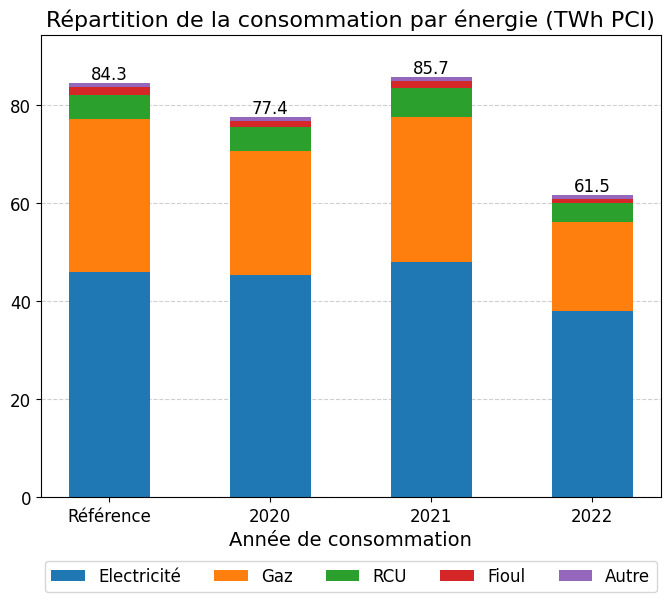

In [139]:
group_small = 2  # A partir de quel % du total de la conso mettre une source d'énergie dans un catégorie "Autre"

df_extract = df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3]

years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

nrg_agreg = {'Electricité': ['Electricite (kWh)'],
             'Gaz': ['Gaz naturel - reseaux (kWh)', 'Gaz naturel liquefie (kg) - kWh', 'Gaz propane (kg) - kWh', 
                     'Gaz propane (m3) - kWh', 'Gaz butane (kg) - kWh', 'Gaz butane (m3) - kWh'],
             'Fioul': ['Fioul domestique (l) - kWh'],
             'Charbon': ['Charbon - agglomeres et briquettes (kg)- kWh', 'Houille (kg) - kWh'],
             'Bois': ["Bois - Plaquettes d'industrie (kg) - kWh", 'Bois - Plaquettes forestieres (kg) - kWh',
                      'Bois - Granules (pellets) ou briquettes (kg) - kWh', 'Bois - Buches (stere)-kWh'],
             'RCU': ['Reseau de chaleur (kWh)'],
             'RFU': ['Reseau de froid (kWh)']}

distrib = {}
distrib_share = {}
for year in years:
    df_extract_1Y = df_extract.loc[df_extract["Annee Consommation"] == year]
    EF_tot = df_extract_1Y['Consommation totale (kWh PCI)'].sum()
    distrib2 = {}
    distrib3 = {}
    for nrg in nrg_agreg:
        distrib2[nrg] = df_extract_1Y[nrg_agreg[nrg]].sum().sum()
        distrib3[nrg] = distrib2[nrg]/EF_tot*100
    distrib[year] = distrib2
    distrib_share[str(year) + " (%)"] = distrib3
distrib = pd.DataFrame(distrib).rename(columns={"Année de référence": "Référence"})
distrib_share = pd.DataFrame(distrib_share).rename(columns={"Année de référence (%)": "Référence (%)"})
distrib = pd.concat([distrib, distrib_share], axis=1)

# On regroupe les énergie avec peu de contribution
if group_small == 0:
    distrib_grouped = distrib
else:
    small_sources = distrib[distrib_share.max(axis=1) < group_small]
    other_sources = pd.DataFrame({'Autre': small_sources.sum(axis=0)}).T
    distrib_filtered = distrib.drop(small_sources.index)
    distrib_grouped = pd.concat([distrib_filtered, other_sources])
distrib_grouped = distrib_grouped.sort_values("Référence", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.5
col_sep = int(len(distrib_grouped.columns)/2)
distrib_plot = distrib_grouped.iloc[:, :col_sep]/1e9
for i, energy_source in enumerate(distrib_grouped.index):
    bottom_values = distrib_plot.iloc[:i, :].sum(axis=0)
    bars = ax.bar(distrib_grouped.columns[:col_sep], distrib_plot.loc[energy_source], label=energy_source, bottom=bottom_values, width=width, zorder=2)
    
    if i == len(distrib_grouped.index)-1:
        for j, bar in enumerate(bars):
            year = distrib_plot.columns[j]
            ax.text(bar.get_x() + bar.get_width() / 2, distrib_plot.sum().loc[year], format(round(distrib_plot.sum().loc[year],1), ',').replace(',', ' '), 
                ha='center', va='bottom', fontsize=12, zorder=3, color='black')
        
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Répartition de la consommation par énergie (TWh PCI)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(distrib_plot), fontsize=12)
ax.set_ylim(0, distrib_plot.sum().max()*1.1)  # Adjust the limits as needed
plt.show()

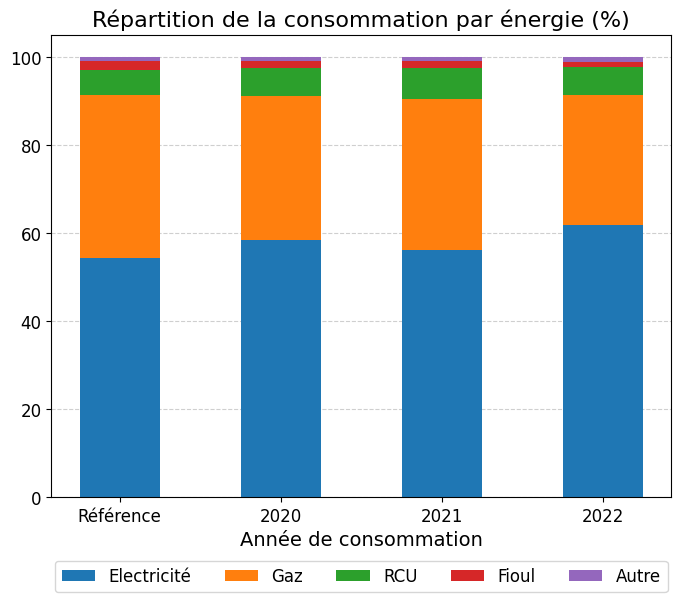

In [140]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.5
col_sep = int(len(distrib_grouped.columns)/2)
distrib_plot = distrib_grouped.iloc[:, col_sep:]
for i, energy_source in enumerate(distrib_grouped.index):
    bottom_values = distrib_plot.iloc[:i, :].sum(axis=0)
    ax.bar(distrib_grouped.columns[:col_sep], distrib_plot.loc[energy_source], label=energy_source, bottom=bottom_values, width=width, zorder=2)
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Répartition de la consommation par énergie (%)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(distrib_plot), fontsize=12)
plt.show()

In [142]:
distrib

Référence          2020          2021          2022  \
Electricité  4.581533e+10  4.526971e+10  4.797880e+10  3.794862e+10   
Gaz          3.124735e+10  2.532325e+10  2.954625e+10  1.818162e+10   
Fioul        1.711814e+09  1.264420e+09  1.407315e+09  8.133910e+08   
Charbon      1.052994e+07  6.013532e+06  6.281467e+06  2.566718e+06   
Bois         5.503744e+08  5.612191e+08  6.670673e+08  5.210166e+08   
RCU          4.825625e+09  4.858192e+09  5.908914e+09  3.885583e+09   
RFU          1.757645e+08  1.350292e+08  1.375268e+08  1.327936e+08   

             Référence (%)   2020 (%)   2021 (%)   2022 (%)  
Electricité      54.324257  58.474524  56.015867  61.719539  
Gaz              37.050672  32.709842  34.495634  29.570535  
Fioul             2.029736   1.633242   1.643059   1.322897  
Charbon           0.012486   0.007768   0.007334   0.004175  
Bois              0.652591   0.724922   0.778810   0.847380  
RCU               5.721851   6.275288   6.898734   6.319502  
RFU               0.208408   0.174416   0.160564   0.215975

### <font color=greenyellow>Evolution à périmètre constant</font>

Nb EFA   Référence       2020       2021       2022
EF Référence-2020        114679.0   74.401843  57.800823                      
EF 2020-2021             145939.0              70.220677  75.260886           
EF 2021-2022              93747.0                         52.298776  48.955858
Variation                                      -0.223126   0.071777   -0.06392
Base 100                                100.0  77.687354  83.263496  77.941325
Part chauffage                       0.533878   0.420109   0.470481   0.448057
IRC                                  0.979567   0.831097    1.02376   0.852111
Base 100 (corr. climat)            101.113608  84.320186  82.354315  84.002292

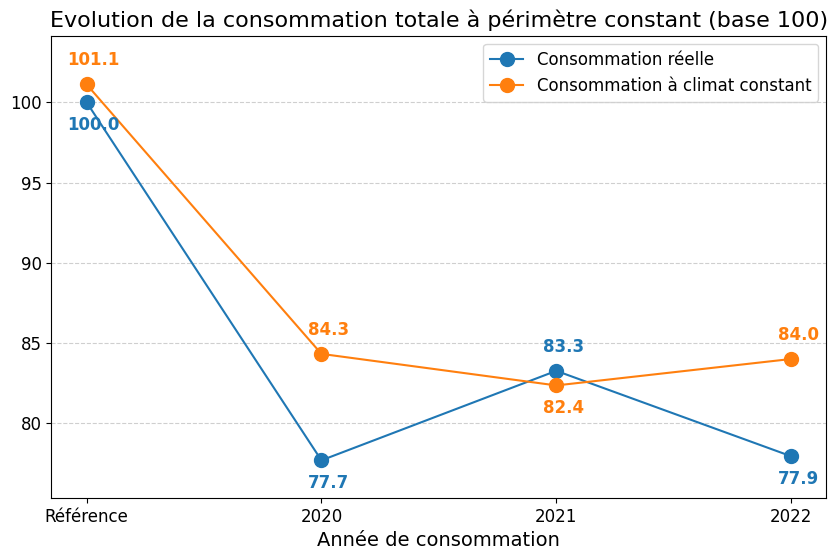

In [11]:
# Evolution globale conso (base 100)
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 4]
years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

distrib = pd.DataFrame()
for i in range(len(years)-1):

    year = years[i]
    year_p1 = years[i+1]
    df_extract_2Y = df_extract.loc[df_extract["Annee Consommation"].isin([year, year_p1])] # extrait sur les 2 années
    efa_count = df_extract_2Y["ID interne EFA"].value_counts()
    df_extract_2Y = df_extract_2Y.loc[df_extract_2Y["ID interne EFA"].isin(efa_count[efa_count == 2].index)] # extrait sur les efa présentes les 2 années

    # Moyenne pour chaque année
    EF_moy_N = df_extract_2Y.loc[df_extract_2Y["Annee Consommation"] == year]['Consommation totale (kWh PCI)'].sum()/1e9
    EF_moy_N_p1 = df_extract_2Y.loc[df_extract_2Y["Annee Consommation"] == year_p1]['Consommation totale (kWh PCI)'].sum()/1e9

    row_idx = "EF " + year + "-" + year_p1
    distrib.loc[row_idx, "Nb EFA"] = len(efa_count[efa_count == 2].index)
    distrib.loc[row_idx, year] = EF_moy_N
    distrib.loc[row_idx, year_p1] = EF_moy_N_p1

# Calcul variation interannuelle
for i in range(len(years)-1):
    year = years[i]
    year_p1 = years[i+1]   
    row_idx = "EF " + year + "-" + year_p1
    EF_N = distrib[year].loc[row_idx]
    EF_N_p1 = distrib[year_p1].loc[row_idx]
    var = (EF_N_p1 - EF_N)/EF_N
    distrib.loc["Variation", year_p1] = var

# Calcul base 100
distrib.loc["Base 100", "Année de référence"] = 100
for i in range(1, len(years)):
    year_m1 = years[i-1]
    year = years[i]
    distrib.loc["Base 100", year] = distrib[year_m1].loc["Base 100"]*(1+distrib[year].loc["Variation"])

distrib = distrib.rename(index={'EF {}-{}'.format(years[0], years[1]): 'EF {}-{}'.format('Référence', years[1])}, columns = {years[0]: 'Référence'})

# Calcul correction climatique

# Import DJU
warnings.simplefilter(action="ignore")
DJU = pd.read_excel(r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\03. Scripts Python\dju_1970_2022.xlsx",
                  header = [2],
                  skiprows = [6,7,8],
                  dtype = object)
warnings.resetwarnings()
DJU = DJU.rename(columns={'Unnamed: 0':''}).set_index('')

# Part que représente les consommations de chauffage dans la consommation totale de l'EFA
df_chauff_connu = copy.copy(df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3].loc[df['Consommation usages chauffage (kWh PCI)'].fillna(0) > 0]) # extrait BDD sur EFA avec conso chauffage connues
#df_chauff_connu['Part chauffage'] = df_chauff_connu['Consommation usages chauffage (kWh PCI)']/df_chauff_connu['Consommation totale (kWh PCI)']
for year in df_extract["Annee Consommation"].unique():
    
    df_chauff_connu_1Y = df_chauff_connu.loc[df_chauff_connu["Annee Consommation"] == year]
    part_chauff_year = df_chauff_connu_1Y['Consommation usages chauffage (kWh PCI)'].sum()/df_chauff_connu_1Y['Consommation totale (kWh PCI)'].sum()
    #part_chauff_year = df_chauff_connu.groupby("Annee Consommation")['Part chauffage'].mean()[year]
    if year == "Année de référence":
        distrib.loc["Part chauffage", "Référence"] = part_chauff_year
    else:
        distrib.loc["Part chauffage", year] = part_chauff_year

# Calcul indice de rigueur climatique (IRC) année de référence
DJU_moy_2010_2019 = DJU[[x for x in range(2010, 2020)]].loc['DJU'].mean()
DJU_ref = DJU.loc["DJU de référence (moyenne sur la période de référence)"].mean()
distrib.loc["IRC", "Référence"] = DJU_moy_2010_2019/DJU_ref

# Calcul IRC pour les autres années
for year in df_extract.loc[df_extract["Annee Consommation"] != "Année de référence"]["Annee Consommation"].unique():
    distrib.loc["IRC", year] = DJU[int(year)].loc['Indice de rigueur']

# Calcul consommations corrigées
conso_tot = distrib[distrib.columns[1:]].loc["Base 100"] # conso totale en base 100
conso_chauff = conso_tot*distrib[distrib.columns[1:]].loc["Part chauffage"] # consommation chauffage en base 100
irc = distrib[distrib.columns[1:]].loc["IRC"] # indice de rigueur climatique
conso_corr = conso_chauff/irc + conso_tot - conso_chauff
distrib.loc["Base 100 (corr. climat)", distrib.columns[1:]] = conso_corr

# Display table
display(distrib.fillna(""))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(distrib.loc["Base 100"].iloc[1:].index, distrib.loc["Base 100"].iloc[1:], zorder=2, color='tab:blue', marker='o', markersize=10, label='Consommation réelle')
ax.plot(distrib.loc["Base 100"].iloc[1:].index, distrib.loc["Base 100 (corr. climat)"].iloc[1:], zorder=2, color='tab:orange', marker='o', markersize=10, label='Consommation à climat constant')
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Evolution de la consommation totale à périmètre constant (base 100)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
for i, (value_blue, value_orange) in enumerate(zip(distrib.loc["Base 100"].iloc[1:], distrib.loc["Base 100 (corr. climat)"].iloc[1:])):
    year = distrib.loc["Base 100"].iloc[1:].index[i]
    # Blue line label position
    offset_blue = (-20, 14)[value_blue >= value_orange]
    ax.annotate(f'{value_blue:.1f}', (year, value_blue), textcoords="offset points", xytext=(5, offset_blue), ha='center', fontsize=12, color="tab:blue", weight='bold')
    # Orange line label position
    offset_orange = (-20, 14)[value_orange >= value_blue]
    ax.annotate(f'{value_orange:.1f}', (year, value_orange), textcoords="offset points", xytext=(5, offset_orange), ha='center', fontsize=12, color="tab:orange", weight='bold')
ax.set_ylim(min(distrib.loc["Base 100"].iloc[1:].min(), distrib.loc["Base 100 (corr. climat)"].iloc[1:].min())*0.97, 
            max(distrib.loc["Base 100"].iloc[1:].max(), distrib.loc["Base 100 (corr. climat)"].iloc[1:].max())*1.03)
ax.legend(loc='upper right', fontsize=12)
plt.show()

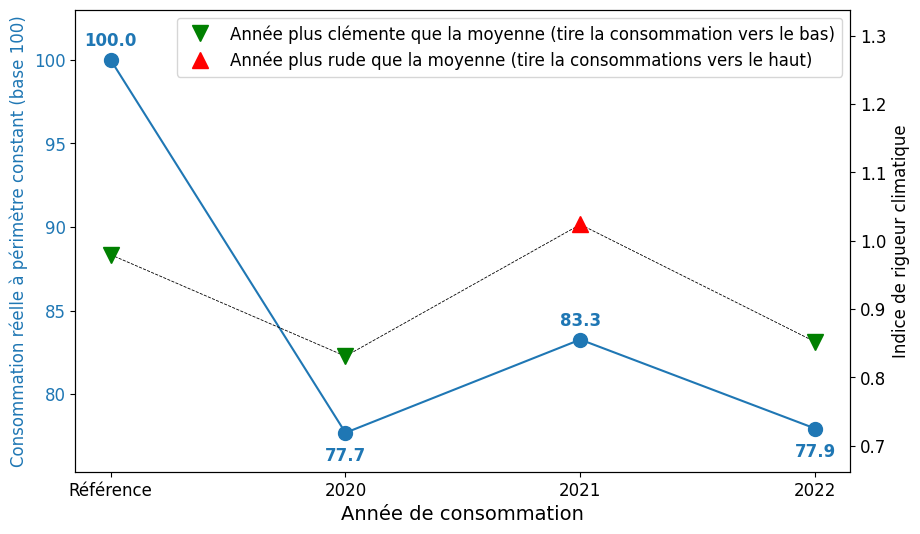

In [17]:
# Plotting the data
distrib_plot = distrib.iloc[:, 1:]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting "Base 100" on the first y-axis (code unchanged)
color = 'tab:blue'
ax1.set_xlabel('Année de consommation', fontsize=14)
ax1.set_ylabel('Consommation réelle à périmètre constant (base 100)', color=color, fontsize=12)
ax1.plot(distrib_plot.columns, distrib_plot.loc['Base 100'], marker='o', markersize=10, color=color)
for i, txt in enumerate(distrib_plot.loc['Base 100']):
    offset = (0, 10) if i % 2 == 0 else (0, -20)
    ax1.annotate(f'{txt:.1f}', (distrib_plot.columns[i], distrib_plot.loc['Base 100'].iloc[i]), textcoords="offset points", xytext=offset, ha='center', fontsize=12, color=color, weight='bold')
ax1.set_ylim(distrib_plot.loc["Base 100"].min()*0.97, distrib_plot.loc["Base 100"].max()*1.03)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12, labelcolor=color)

# Creating a second y-axis for "IRC" and plotting individual points with specific markers
ax2 = ax1.twinx()
color = 'black'
ax2.set_ylabel('Indice de rigueur climatique', color=color, fontsize=12)
# Plot a dummy line for legend (invisible on the graph)
ax2.plot(distrib_plot.columns, distrib_plot.loc['IRC'], marker='o', markersize=0, linestyle='--', linewidth=0.6, color=color)
count = [0, 0]
for i, value in enumerate(distrib_plot.loc['IRC']):
    if value > 1:
        count[0] += 1
        label = "Année plus rude que la moyenne (tire la consommations vers le haut)"
        ax2.plot(distrib_plot.columns[i], value, marker='^', linestyle='none', markersize=12, color='red', label=label if count[0] == 1 else "")
    else:
        count[1] += 1
        label = "Année plus clémente que la moyenne (tire la consommation vers le bas)"
        ax2.plot(distrib_plot.columns[i], value, marker='v', linestyle='none', markersize=12, color='green', label=label if count[1] == 1 else "")
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12, labelcolor=color)
delta = abs(distrib_plot.loc['IRC']-1).max()*2
ax2.set_ylim(1-delta, 1+delta)
ax2.legend(loc='upper right', fontsize=12)
plt.show()

In [18]:
distrib = pd.DataFrame()
for year in df_extract["Annee Consommation"].unique():

    df_1Y = df_extract.loc[df_extract["Annee Consommation"] == year]

    # Répartition conso par CAP-M dans la base
    cap_conso = df_1Y.groupby("Categorie d'activite majoritaire")['Consommation totale (kWh PCI)'].sum().sort_values(ascending=False)
    conso_tot = df_1Y['Consommation totale (kWh PCI)'].sum()
    cap_conso_ratio = round(cap_conso/conso_tot*100, 1).rename("{}".format(year))

    # Même réparition dans l'extrait dont les conso de chauffage sont connues
    cap_conso = df_chauff_connu.groupby("Categorie d'activite majoritaire")['Consommation totale (kWh PCI)'].sum().sort_values(ascending=False)
    conso_tot = df_chauff_connu['Consommation totale (kWh PCI)'].sum()
    cap_conso_ratio_chauff = round(cap_conso/conso_tot*100, 1).rename("{} (chauff. connu)".format(year)) 

    # Concaténation des 2
    cap_conso_ratio_year = pd.concat([cap_conso_ratio, cap_conso_ratio_chauff], axis=1)
    distrib = pd.concat([distrib, cap_conso_ratio_year], axis=1)

cap_extract = CAP.loc[CAP["Type"] == "Catégorie"][["Catégories et sous-catégories", "Catégories abrégées"]]
col_rename = {row["Catégories et sous-catégories"]: row["Catégories abrégées"] for index, row in cap_extract.iterrows()}
distrib = distrib.rename(columns=col_rename)
distrib = distrib[distrib.apply(lambda row: row.max() >= 1, axis=1)]

print("Répartition de la consommation d'énergie totale par CAP-M pour la BDD et pour les EFA avec conso de chauffage connu (par année)")
distrib

Répartition de la consommation d'énergie totale par CAP-M pour la BDD et pour les EFA avec conso de chauffage connu (par année)


Année de référence  \
Categorie d'activite majoritaire                                         
Bureaux – Services Publics - Banque                               16.6   
Santé - Centre hospitalier public et privé                        13.4   
Logistique                                                         9.2   
Enseignement Secondaire                                            8.4   
Commerce - Grande Surface Alimentaire - Hyperma...                 7.8   
Santé - Etablissements médico-sociaux                              6.9   
Sports                                                             5.1   
Enseignement Primaire                                              4.5   
Hôtellerie                                                         3.2   
Commerce - Grande Surface Alimentaire - Grand s...                 2.7   
Enseignement Supérieur                                             1.8   
Blanchisserie dite "industrielle"                                  1.5   
Vente et services véhicules légers                                 1.4   
Salles serveurs et centres d'exploitation infor...                 1.2   
Commerce - Grande Surface de Bricolage                             1.1   
Culture et spectacles - Salle de spectacles viv...                 1.0   
Commerces et services de détail - Equipement de...                 0.9   
Restauration - Débit de boissons                                   0.8   
Transport ferroviaire de voyageurs                                 0.6   

                                                    Année de référence (chauff. connu)  \
Categorie d'activite majoritaire                                                         
Bureaux – Services Publics - Banque                                               14.0   
Santé - Centre hospitalier public et privé                                        16.7   
Logistique                                                                         6.5   
Enseignement Secondaire                                                           14.9   
Commerce - Grande Surface Alimentaire - Hyperma...                                19.7   
Santé - Etablissements médico-sociaux                                              2.4   
Sports                                                                             4.8   
Enseignement Primaire                                                              6.1   
Hôtellerie                                                                         0.6   
Commerce - Grande Surface Alimentaire - Grand s...                                 3.9   
Enseignement Supérieur                                                             0.8   
Blanchisserie dite "industrielle"                                                  0.0   
Vente et services véhicules légers                                                 0.2   
Salles serveurs et centres d'exploitation infor...                                 0.9   
Commerce - Grande Surface de Bricolage                                             1.0   
Culture et spectacles - Salle de spectacles viv...                                 1.1   
Commerces et services de détail - Equipement de...                                 0.1   
Restauration - Débit de boissons                                                   0.3   
Transport ferroviaire de voyageurs                                                 0.0   

                                                    2021  \
Categorie d'activite majoritaire                           
Bureaux – Services Publics - Banque                 16.1   
Santé - Centre hospitalier public et privé          13.0   
Logistique                                           9.0   
Enseignement Secondaire                              9.4   
Commerce - Grande Surface Alimentaire - Hyperma...   7.7   
Santé - Etablissements médico-sociaux                7.6   
Sports                                               4.2   
Enseignement Primaire                                4.1   
Hôtell

Référence       2020       2021       2022
Electricité  54.677538  57.104872  54.521546  58.142338
Gaz          36.710754  33.498076  35.424528  32.393622
RCU           5.751558   6.863933   7.523680   6.863861
Autre         2.860149   2.533120   2.530245   2.600179

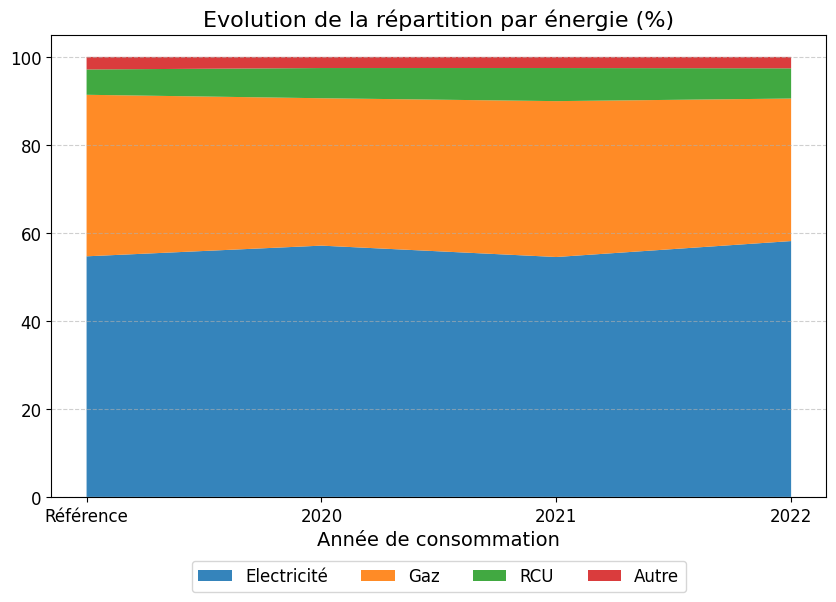

In [19]:
# Evolution réparition par énergie (base 100)
group_small = 2  # A partir de quel % du total de la conso mettre une source d'énergie dans un catégorie "Autre"

df_extract = df.loc[df["P&S Score"] == 9].loc[df["E Score"] == 4]
years = df["Annee Consommation"].value_counts().sort_index().index.to_list()
years = years[-1:] + years[:-1]

nrg_agreg = {'Electricité': ['Electricite (kWh)'],
             'Gaz': ['Gaz naturel - reseaux (kWh)', 'Gaz naturel liquefie (kg) - kWh', 'Gaz propane (kg) - kWh', 
                     'Gaz propane (m3) - kWh', 'Gaz butane (kg) - kWh', 'Gaz butane (m3) - kWh'],
             'Fioul': ['Fioul domestique (l) - kWh'],
             'Charbon': ['Charbon - agglomeres et briquettes (kg)- kWh', 'Houille (kg) - kWh'],
             'Bois': ["Bois - Plaquettes d'industrie (kg) - kWh", 'Bois - Plaquettes forestieres (kg) - kWh',
                      'Bois - Granules (pellets) ou briquettes (kg) - kWh', 'Bois - Buches (stere)-kWh'],
             'RCU': ['Reseau de chaleur (kWh)'],
             'RFU': ['Reseau de froid (kWh)']}

# Calcul répartition des sources d'énergie pour l'année de référence
distrib = {}
df_extract_ref = df_extract.loc[df_extract["Annee Consommation"] == years[0]]
EF_tot_ref = df_extract_ref['Consommation totale (kWh PCI)'].sum()
distrib2 = {}
for nrg in nrg_agreg:
    distrib2[nrg] = df_extract_ref[nrg_agreg[nrg]].sum().sum()
distrib[years[0]] = distrib2

# Calcul évolution de cette répartition en fonction de l'année de conso en base 100
for i in range(1, len(years)):
    
    distrib_1Y = {}
    year_m1 = years[i-1]
    year = years[i]
    
    # Extrait sur périmètre commun aux 2 années
    df_extract_2Y = df_extract.loc[df_extract["Annee Consommation"].isin([year_m1, year])] # extrait sur les 2 années
    efa_count = df_extract_2Y["ID interne EFA"].value_counts()
    df_extract_2Y = df_extract_2Y.loc[df_extract_2Y["ID interne EFA"].isin(efa_count[efa_count == 2].index)] # extrait sur les efa présentes les 2 années

    # Calcul conso pour chaque énergie (TWh EF PCI)
    for nrg in nrg_agreg:

        nrg_N_m1 = df_extract_2Y.loc[df_extract_2Y["Annee Consommation"] == year_m1][nrg_agreg[nrg]].sum().sum()
        nrg_N = df_extract_2Y.loc[df_extract_2Y["Annee Consommation"] == year][nrg_agreg[nrg]].sum().sum()
        var = (nrg_N-nrg_N_m1)/nrg_N_m1

        distrib_1Y[nrg] = distrib[year_m1][nrg]*(1+var)

    distrib[year] = distrib_1Y

distrib = pd.DataFrame(distrib).rename(columns={"Année de référence": "Référence"}).sort_values("Référence", ascending=False)
distrib = distrib/distrib.sum(axis=0)*100

# On regroupe les énergie avec peu de contribution
if group_small == 0:
    distrib_grouped = distrib
else:
    small_sources = distrib[distrib.max(axis=1) < group_small]
    other_sources = pd.DataFrame({'Autre': small_sources.sum(axis=0)}).T
    distrib_filtered = distrib.drop(small_sources.index)
    distrib_grouped = pd.concat([distrib_filtered, other_sources])
distrib_grouped = distrib_grouped.sort_values("Référence", ascending=False)
display(distrib_grouped)

# Plotting as stacked lines with filled areas
fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(distrib_grouped.columns, distrib_grouped.values, labels=distrib_grouped.index, alpha=0.9)
ax.set_xlabel('Année de consommation', fontsize=14)
ax.set_title("Evolution de la répartition par énergie (%)", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(distrib_grouped), fontsize=12)
plt.show()

### <font color=greenyellow>Répartition géographique des données déclarées</font>

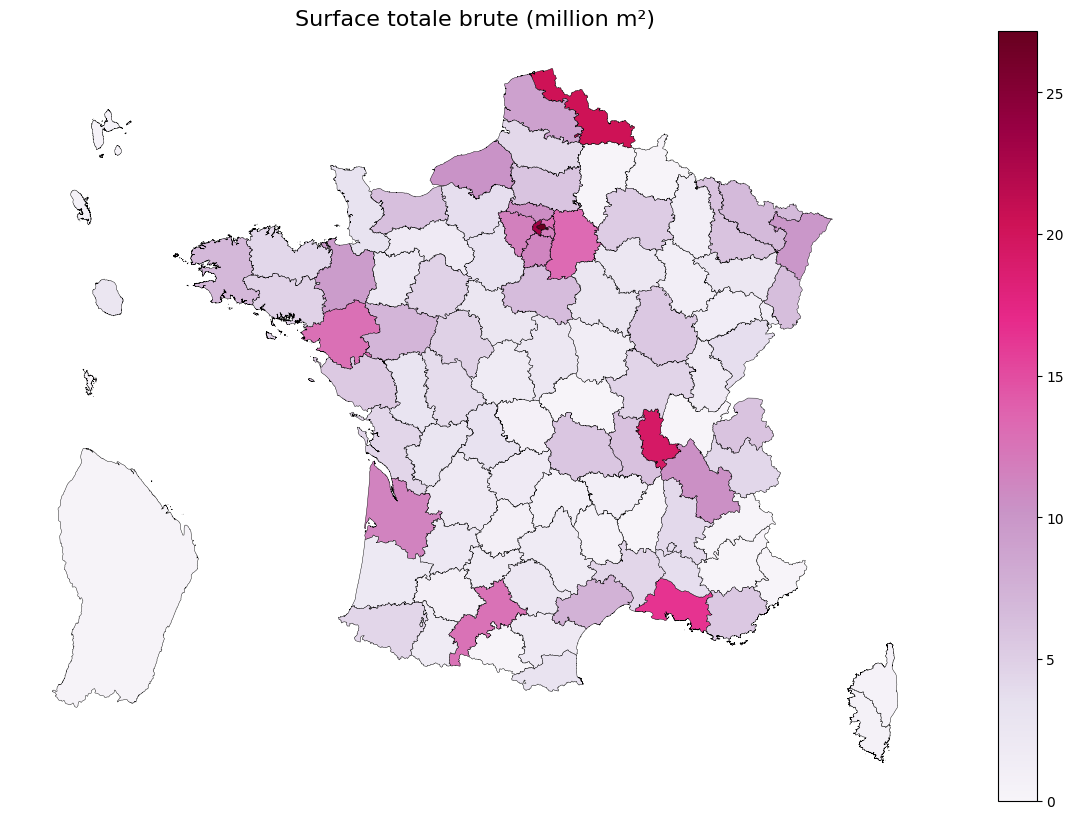

In [93]:
# Distribution géographique de la surface totale brute
df_extract = df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']

# Load the French départements shapefile
# You can download the shapefile from https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/
# Save the shapefile in the same directory as your script/notebook
shapefile_path = 'departements-20180101-shp/departements-20180101.shp'
gdf = gpd.read_file(shapefile_path)
gdf.loc[gdf['code_insee'].isin(['69D', '69M']), 'code_insee'] = '69' # Merge '69D' and '69M' into '69'
gdf = gdf.dissolve(by='code_insee', aggfunc='sum').reset_index()

sum_consumption = df_extract.groupby('Departement')['Surface totale brute (m²)'].sum().reset_index()

# Merge the GeoDataFrame with the calculated sum
gdf = gdf.merge(sum_consumption, left_on='code_insee', right_on='Departement', how='left')

# Fill NaN values in the new column with 0
gdf['Surface totale brute (m²)'] = gdf['Surface totale brute (m²)'].fillna(0)/1e6

# Redefine coordinates for overseas territories
overseas_territories_adjustments = {
    '971': (55, 34),  # Guadeloupe
    '972': (54, 34.5),  # Martinique
    '974': (-62, 69),  # Réunion
    '976': (-52, 59.5),  # Mayotte
    '973': (47, 40),  # Guyane
}
for code, (lon_adjust, lat_adjust) in overseas_territories_adjustments.items():
    gdf.loc[gdf['code_insee'] == code, 'geometry'] = gdf.loc[gdf['code_insee'] == code, 'geometry'].translate(lon_adjust, lat_adjust)

# Plot the map with a color scale based on total building area
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot = gdf.plot(column='Surface totale brute (m²)', cmap='PuRd', linewidth=0.3, ax=ax, edgecolor='black', legend=True)

plt.title('Surface totale brute (million m²)', fontsize=16)
ax.set_axis_off()
plt.show()

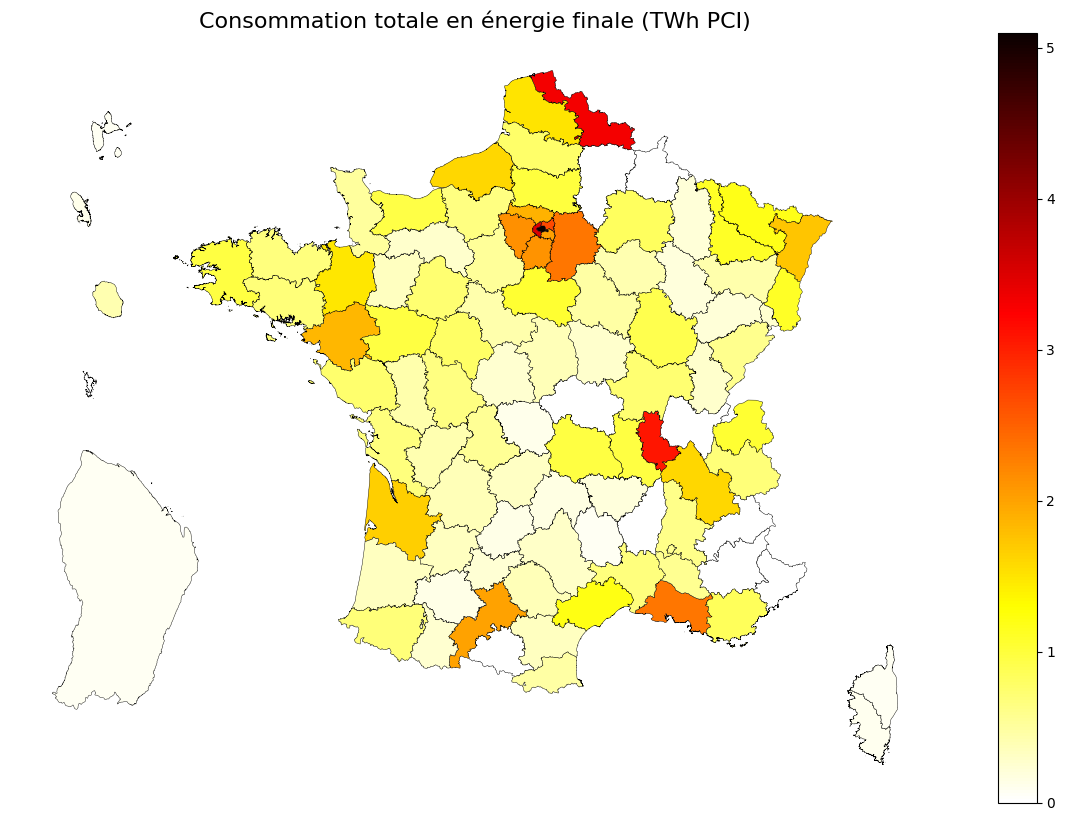

In [22]:
# Distribution géographique de la consommation totale en EF PCI
df_extract = df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']

# Load the French départements shapefile
# You can download the shapefile from https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/
# Save the shapefile in the same directory as your script/notebook
shapefile_path = 'departements-20180101-shp/departements-20180101.shp'
gdf = gpd.read_file(shapefile_path)
gdf.loc[gdf['code_insee'].isin(['69D', '69M']), 'code_insee'] = '69' # Merge '69D' and '69M' into '69'
gdf = gdf.dissolve(by='code_insee', aggfunc='sum').reset_index()

sum_consumption = df_extract.groupby('Departement')['Consommation totale (kWh PCI)'].sum().reset_index()

# Merge the GeoDataFrame with the calculated sum
gdf = gdf.merge(sum_consumption, left_on='code_insee', right_on='Departement', how='left')

# Fill NaN values in the new column with 0
gdf['Consommation totale (kWh PCI)'] = gdf['Consommation totale (kWh PCI)'].fillna(0)/1e9

# Redefine coordinates for overseas territories
overseas_territories_adjustments = {
    '971': (55, 34),  # Guadeloupe
    '972': (54, 34.5),  # Martinique
    '974': (-62, 69),  # Réunion
    '976': (-52, 59.5),  # Mayotte
    '973': (47, 40),  # Guyane
}
for code, (lon_adjust, lat_adjust) in overseas_territories_adjustments.items():
    gdf.loc[gdf['code_insee'] == code, 'geometry'] = gdf.loc[gdf['code_insee'] == code, 'geometry'].translate(lon_adjust, lat_adjust)

# Plot the map with a color scale based on total building area
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot = gdf.plot(column='Consommation totale (kWh PCI)', cmap='hot_r', linewidth=0.3, ax=ax, edgecolor='black', legend=True)

plt.title('Consommation totale en énergie finale (TWh PCI)', fontsize=16)
ax.set_axis_off()
plt.show()

### <font color=greenyellow>Répartition par catégorie d'activité</font>

In [21]:
# Périmètre
df_extract = copy.copy(df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021'])

# Initialisation table
distrib = pd.DataFrame(index=CAP.loc[CAP["Type"] == "Catégorie"]["Code"])

# On crée une copie des colonnes surfaces CAP-M et CAP-S car on va les modifier dans la suite
df_extract.loc[:, "SMA CAP-M"] = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)
df_extract.loc[:, "SMA CAP-S"] = df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0)

# On calcule la surface non vacante, la surface des CAP3+ et cette même surface dont on retranche la surface vacante
df_extract.loc[:, "SMA non vac"] = df_extract['Surface moyenne annuelle'] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)
df_extract.loc[:, "SMA CAP3+"] = df_extract['Surface moyenne annuelle'] - df_extract["SMA CAP-M"] - df_extract["SMA CAP-S"]
df_extract.loc[:, "SMA CAP3+ non vac"] = df_extract["SMA CAP3+"] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)

# Indices des EFA avec/sans locaux vacants
idx_vac = df_extract.loc[df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0) > 0].index
idx_novac = df_extract.index.difference(idx_vac)


#################################### Surface ######################################

#-------------------------------EFA sans locaux vacants ---------------------------#
# On attribue la surface des CAP3+ à celle de la CAP-M
df_extract.loc[idx_novac, "SMA CAP-M"] = df_extract["SMA CAP-M"].loc[idx_novac] + df_extract["SMA CAP3+"].loc[idx_novac]

#-------------------------------EFA avec locaux vacants ---------------------------#
# 3 situations : CAP-M, CAP-S pas vacantes, ou l'une des deux vacantes (les EFA avec CAP-M et CAP-S vacantes ont été filtrées par PS >= 4)

# Si CAP-M vacante, on attribue la surface des CAP3+ à la CAP-S
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] == "CAP00"].loc[df_extract["Code CAP-S"] != "CAP00"].index
df_extract.loc[idx, "SMA CAP-S"] = df_extract["SMA CAP-S"].loc[idx] + df_extract["SMA CAP3+"].loc[idx]

# Si CAP-S vacante, on attribue la surface des CAP3+ à la CAP-M
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] != "CAP00"].loc[df_extract["Code CAP-S"] == "CAP00"].index
df_extract.loc[idx, "SMA CAP-M"] = df_extract["SMA CAP-M"].loc[idx] + df_extract["SMA CAP3+"].loc[idx]

# Si aucune des 2 vacantes, on attribue la surface de la CAP3+ NON VACANTE à la CAP-M
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] != "CAP00"].loc[df_extract["Code CAP-S"] != "CAP00"].index
df_extract.loc[idx, "SMA CAP-M"] = df_extract["SMA CAP-M"].loc[idx] + df_extract["SMA CAP3+ non vac"].loc[idx]

#------------------------------- Mise en commun des résultats ---------------------------#
# On groupe maintenant les EFA par code CAP-M et on somme la SMA de la CAP-M (idem pour CAP-S)
surf_CAP_M = df_extract.groupby("Code CAP-M")["SMA CAP-M"].sum()
surf_CAP_S = df_extract.groupby("Code CAP-S")["SMA CAP-S"].sum()

# On somme les 2 pour obtenir la surface totale pour chaque code CAP
surf_tot = pd.concat([surf_CAP_M, surf_CAP_S], axis=1).fillna(0).sum(axis=1)

# On remplace la surface calculée pour la catégorie local vacant par la surface totale vacante (car il y a eu du double comptage)
surf_tot.loc["CAP00"] = df_extract['Surface moyenne annuel  local vacant (m²)'].sum()

# On ajoute la colonne à la table
distrib = pd.concat([distrib, surf_tot.rename("Surface")], axis=1)


#################################### Energie ######################################

# On définit les nouvelles sources d'énergie
nrg_agreg = {'Electricité': ['Electricite (kWh)'],
             'Gaz': ['Gaz naturel - reseaux (kWh)', 'Gaz naturel liquefie (kg) - kWh', 'Gaz propane (kg) - kWh', 
                     'Gaz propane (m3) - kWh', 'Gaz butane (kg) - kWh', 'Gaz butane (m3) - kWh'],
             'Bois': ["Bois - Plaquettes d'industrie (kg) - kWh", 'Bois - Plaquettes forestieres (kg) - kWh',
                      'Bois - Granules (pellets) ou briquettes (kg) - kWh', 'Bois - Buches (stere)-kWh'],
             'RCU': ['Reseau de chaleur (kWh)'],
             'RFU': ['Reseau de froid (kWh)'],
             'Fioul': ['Fioul domestique (l) - kWh'],
             'Charbon': ['Charbon - agglomeres et briquettes (kg)- kWh', 'Houille (kg) - kWh']}

# On calcule, pour chacune de ces sources, la contribution de la CAP-M et de la CAP-S au prorata de la surface au sein de l'EFA.
# Ajout des colonnes contenant la conso par source pour la CAP-M et la CAP-S
for nrg_src in nrg_agreg:
    df_extract.loc[:, "CAP-M - {}".format(nrg_src)] = np.nan
    df_extract.loc[:, "CAP-S - {}".format(nrg_src)] = np.nan

#-------------------------------EFA sans locaux vacants ---------------------------#
# On attribue les consos des CAP3+ à la CAP-M
# On calcule les différents ratios de surface (en utilisant les nouvelles surfaces calculées dans la partie #### Surface ####)
# Puis, pour chaque énergie, on calcule la part de la CAP-M et de la CAP-S 
surf_ratio_CAP_M = (df_extract["SMA CAP-M"]/df_extract['Surface moyenne annuelle']).loc[idx_novac]
surf_ratio_CAP_S = (df_extract["SMA CAP-S"]/df_extract['Surface moyenne annuelle']).loc[idx_novac]
for nrg_src in nrg_agreg:
    df_extract.loc[idx_novac, "CAP-M - {}".format(nrg_src)] = surf_ratio_CAP_M * df_extract[nrg_agreg[nrg_src]].loc[idx_novac].sum(axis=1)
    df_extract.loc[idx_novac, "CAP-S - {}".format(nrg_src)] = surf_ratio_CAP_S * df_extract[nrg_agreg[nrg_src]].loc[idx_novac].sum(axis=1)

#-------------------------------EFA avec locaux vacants ---------------------------#
# 3 situations : CAP-M, CAP-S pas vacantes, ou l'une des deux vacantes (les EFA avec CAP-M et CAP-S vacantes ont été filtrées par PS >= 4)

# Si CAP-M vacante, on attribue toute la conso à la CAP-S
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] == "CAP00"].loc[df_extract["Code CAP-S"] != "CAP00"].index
surf_ratio_CAP_M = 0
surf_ratio_CAP_S = 1#(df_extract["SMA CAP-S"].loc[idx] - df_extract['Surface moyenne annuel  local vacant (m²)'].loc[idx])/df_extract["SMA non vac"].loc[idx]
for nrg_src in nrg_agreg:
    df_extract.loc[idx, "CAP-M - {}".format(nrg_src)] = surf_ratio_CAP_M * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)
    df_extract.loc[idx, "CAP-S - {}".format(nrg_src)] = surf_ratio_CAP_S * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)

# Si CAP-S vacante, on attribue toute la conso à la CAP-M
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] != "CAP00"].loc[df_extract["Code CAP-S"] == "CAP00"].index
surf_ratio_CAP_M = 1#(df_extract["SMA CAP-M"].loc[idx] - df_extract['Surface moyenne annuel  local vacant (m²)'].loc[idx])/df_extract["SMA non vac"].loc[idx]
surf_ratio_CAP_S = 0
for nrg_src in nrg_agreg:
    df_extract.loc[idx, "CAP-M - {}".format(nrg_src)] = surf_ratio_CAP_M * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)
    df_extract.loc[idx, "CAP-S - {}".format(nrg_src)] = surf_ratio_CAP_S * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)

# Si aucune des 2 vacantes, on attribue la conso de la partie non vacante des CAP3+ à la CAP-M
idx = df_extract.loc[idx_vac].loc[df_extract["Code CAP-M"] != "CAP00"].loc[df_extract["Code CAP-S"] != "CAP00"].index
surf_ratio_CAP_M = df_extract["SMA CAP-M"].loc[idx]/df_extract["SMA non vac"].loc[idx]
surf_ratio_CAP_S = df_extract["SMA CAP-S"].loc[idx]/df_extract["SMA non vac"].loc[idx]
for nrg_src in nrg_agreg:
    df_extract.loc[idx, "CAP-M - {}".format(nrg_src)] = surf_ratio_CAP_M * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)
    df_extract.loc[idx, "CAP-S - {}".format(nrg_src)] = surf_ratio_CAP_S * df_extract[nrg_agreg[nrg_src]].loc[idx].sum(axis=1)

#------------------------------- Mise en commun des résultats ---------------------------#
# Pour chaque source d'énergie :
# - On groupe les EFA par code CAP-M et on somme la conso de la CAP-M (idem pour CAP-S)
# - On somme les 2 pour obtenir la conso totale pour chaque code CAP
# - On ajoute la colonne à la table
for nrg_src in nrg_agreg:
    nrg_CAP_M = df_extract.groupby("Code CAP-M")["CAP-M - {}".format(nrg_src)].sum()
    nrg_CAP_S = df_extract.groupby("Code CAP-S")["CAP-S - {}".format(nrg_src)].sum()
    nrg_tot = pd.concat([nrg_CAP_M, nrg_CAP_S], axis=1).fillna(0).sum(axis=1)
    distrib = pd.concat([distrib, nrg_tot.rename(nrg_src)], axis=1)

# Conversion des surfaces en millions m² et des conso en TWh PCU et ajout d'une colonne avec conso totale
distrib.loc[:, "Surface"] = distrib["Surface"]/1e6
distrib.loc[:, list(nrg_agreg.keys())] = distrib[list(nrg_agreg.keys())]/1e9
distrib.loc[:, "Total"] = distrib.iloc[:, 1:].sum(axis=1)


#################################### Génération table par catégorie abrégée et par meta CAP ######################################

# Catégorie abrégée
CAP_name_mapping = CAP.loc[CAP["Type"] == "Catégorie"][["Code", "Catégories abrégées"]].set_index('Code')['Catégories abrégées'].to_dict()
distrib_CAP = distrib.rename(index=CAP_name_mapping)

# Meta-catégorie
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = []#"Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

distrib_meta_CAP = pd.DataFrame(index = meta_cap_all.keys(), columns = distrib.columns)
for meta_cap in meta_cap_all:
    distrib_meta_CAP.loc[meta_cap, "Surface"] = distrib["Surface"].loc[meta_cap_all[meta_cap]].sum()
    distrib_meta_CAP.loc[meta_cap, distrib.columns[1:]] = distrib[distrib.columns[1:]].loc[meta_cap_all[meta_cap]].sum()

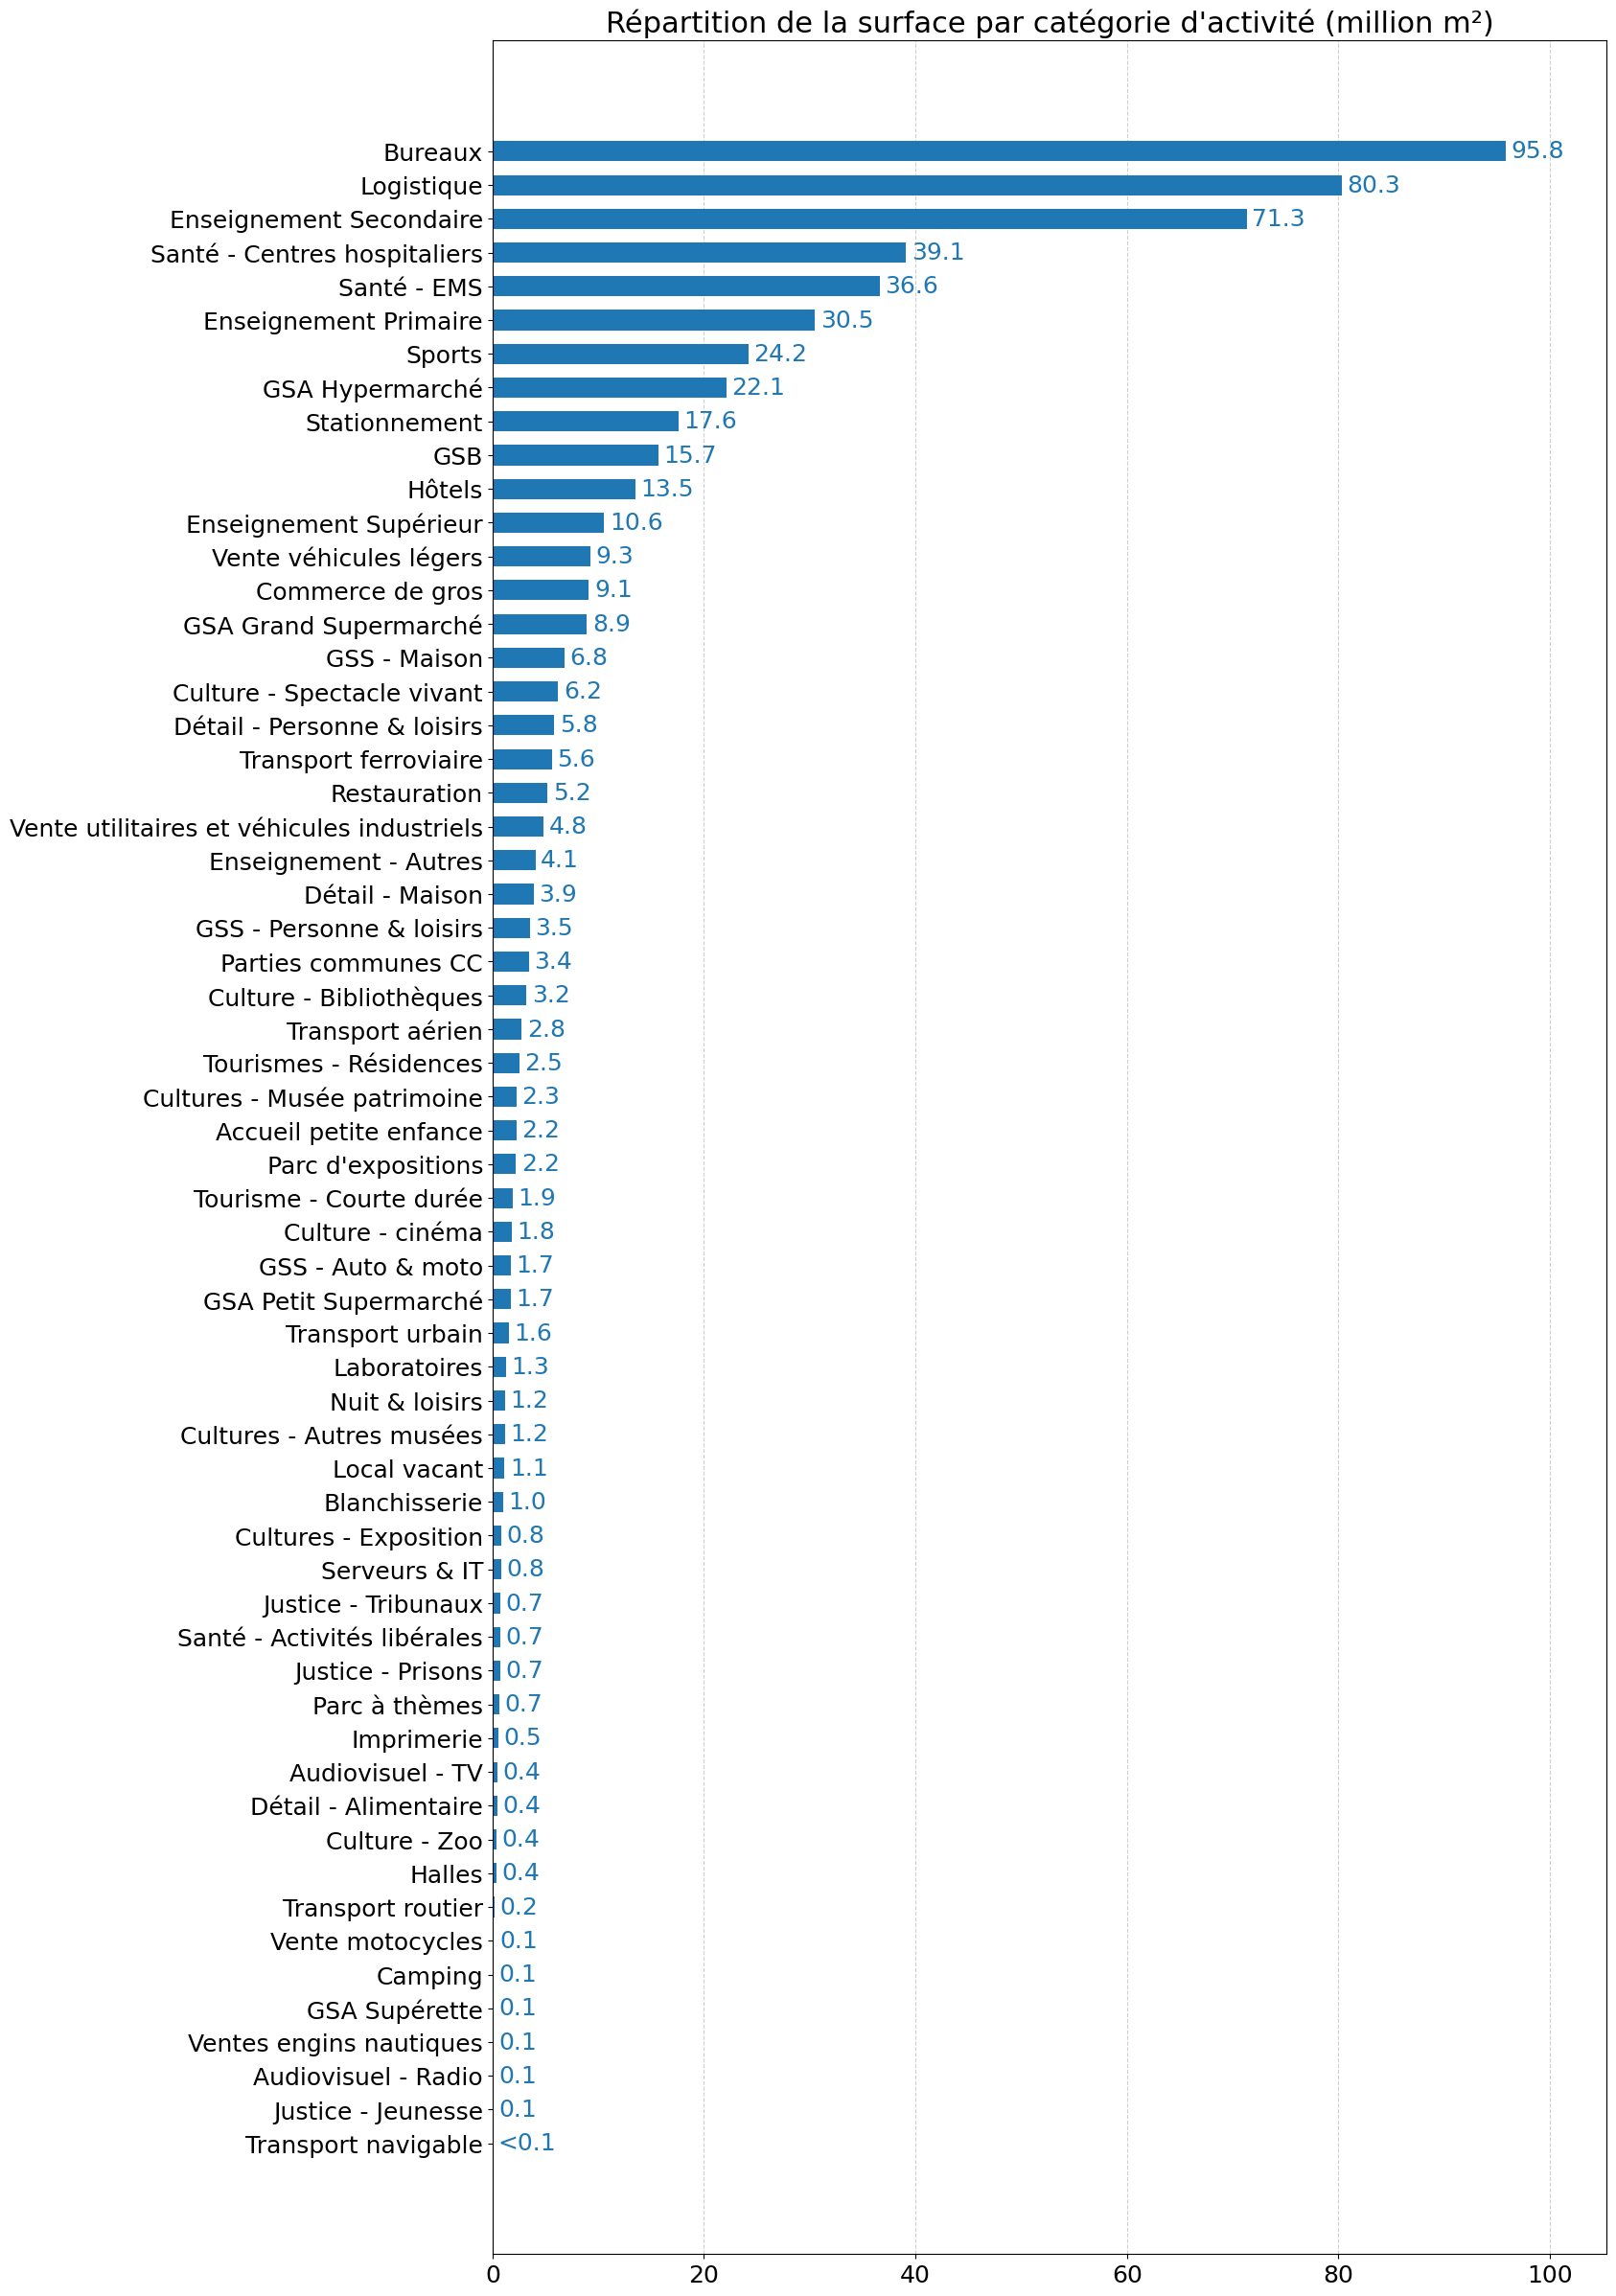

In [3]:
# Plot 1
fig, ax = plt.subplots(figsize=(15, 30))
distrib_CAP = distrib_CAP.sort_values("Surface")
bars = ax.barh(distrib_CAP.index, distrib_CAP["Surface"], zorder=2, height=0.6, color='tab:blue')
ax.set_title("Répartition de la surface par catégorie d'activité (million m²)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    value = round(bar.get_width(), 1)
    label = '<0.1' if value < 0.1 else format(value, '.1f')
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            label, ha='left', va='center', fontsize=18, zorder=3, color='tab:blue')
ax.set_xlim(0, distrib_CAP["Surface"].max()*1.1)
plt.show()

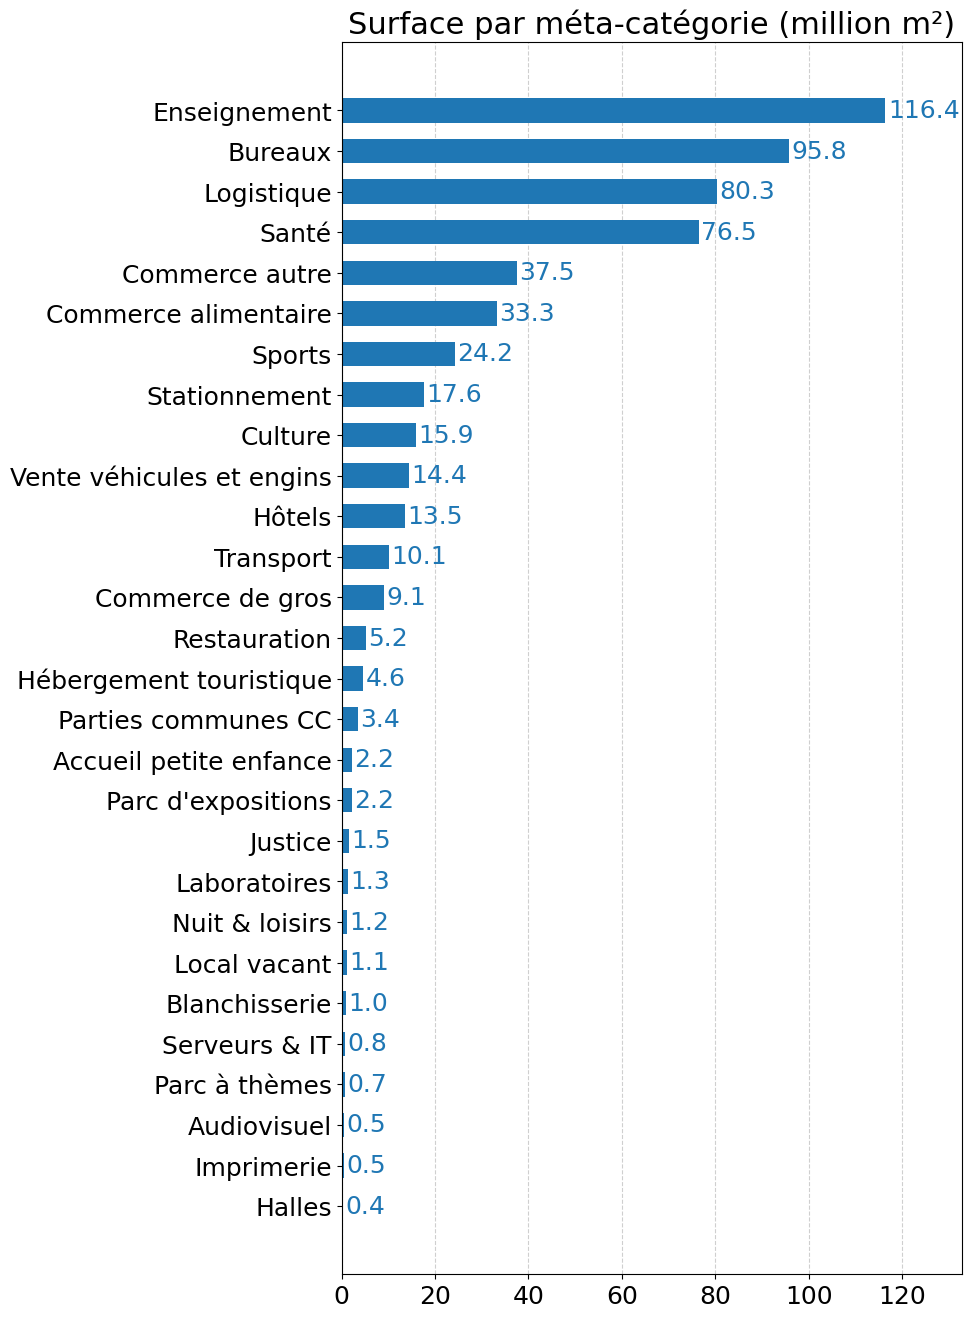

In [4]:
# Plot 2
fig, ax = plt.subplots(figsize=(8, 16))
distrib_meta_CAP = distrib_meta_CAP.sort_values("Surface")
bars = ax.barh(distrib_meta_CAP.index, distrib_meta_CAP["Surface"], zorder=2, height=0.6, color='tab:blue')
ax.set_title("Surface par méta-catégorie (million m²)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    value = round(bar.get_width(), 1)
    label = '<0.1' if value < 0.1 else format(value, '.1f')
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            label, ha='left', va='center', fontsize=18, zorder=3, color='tab:blue')
ax.set_xlim(0, distrib_meta_CAP["Surface"].max()*1.14)
plt.show()

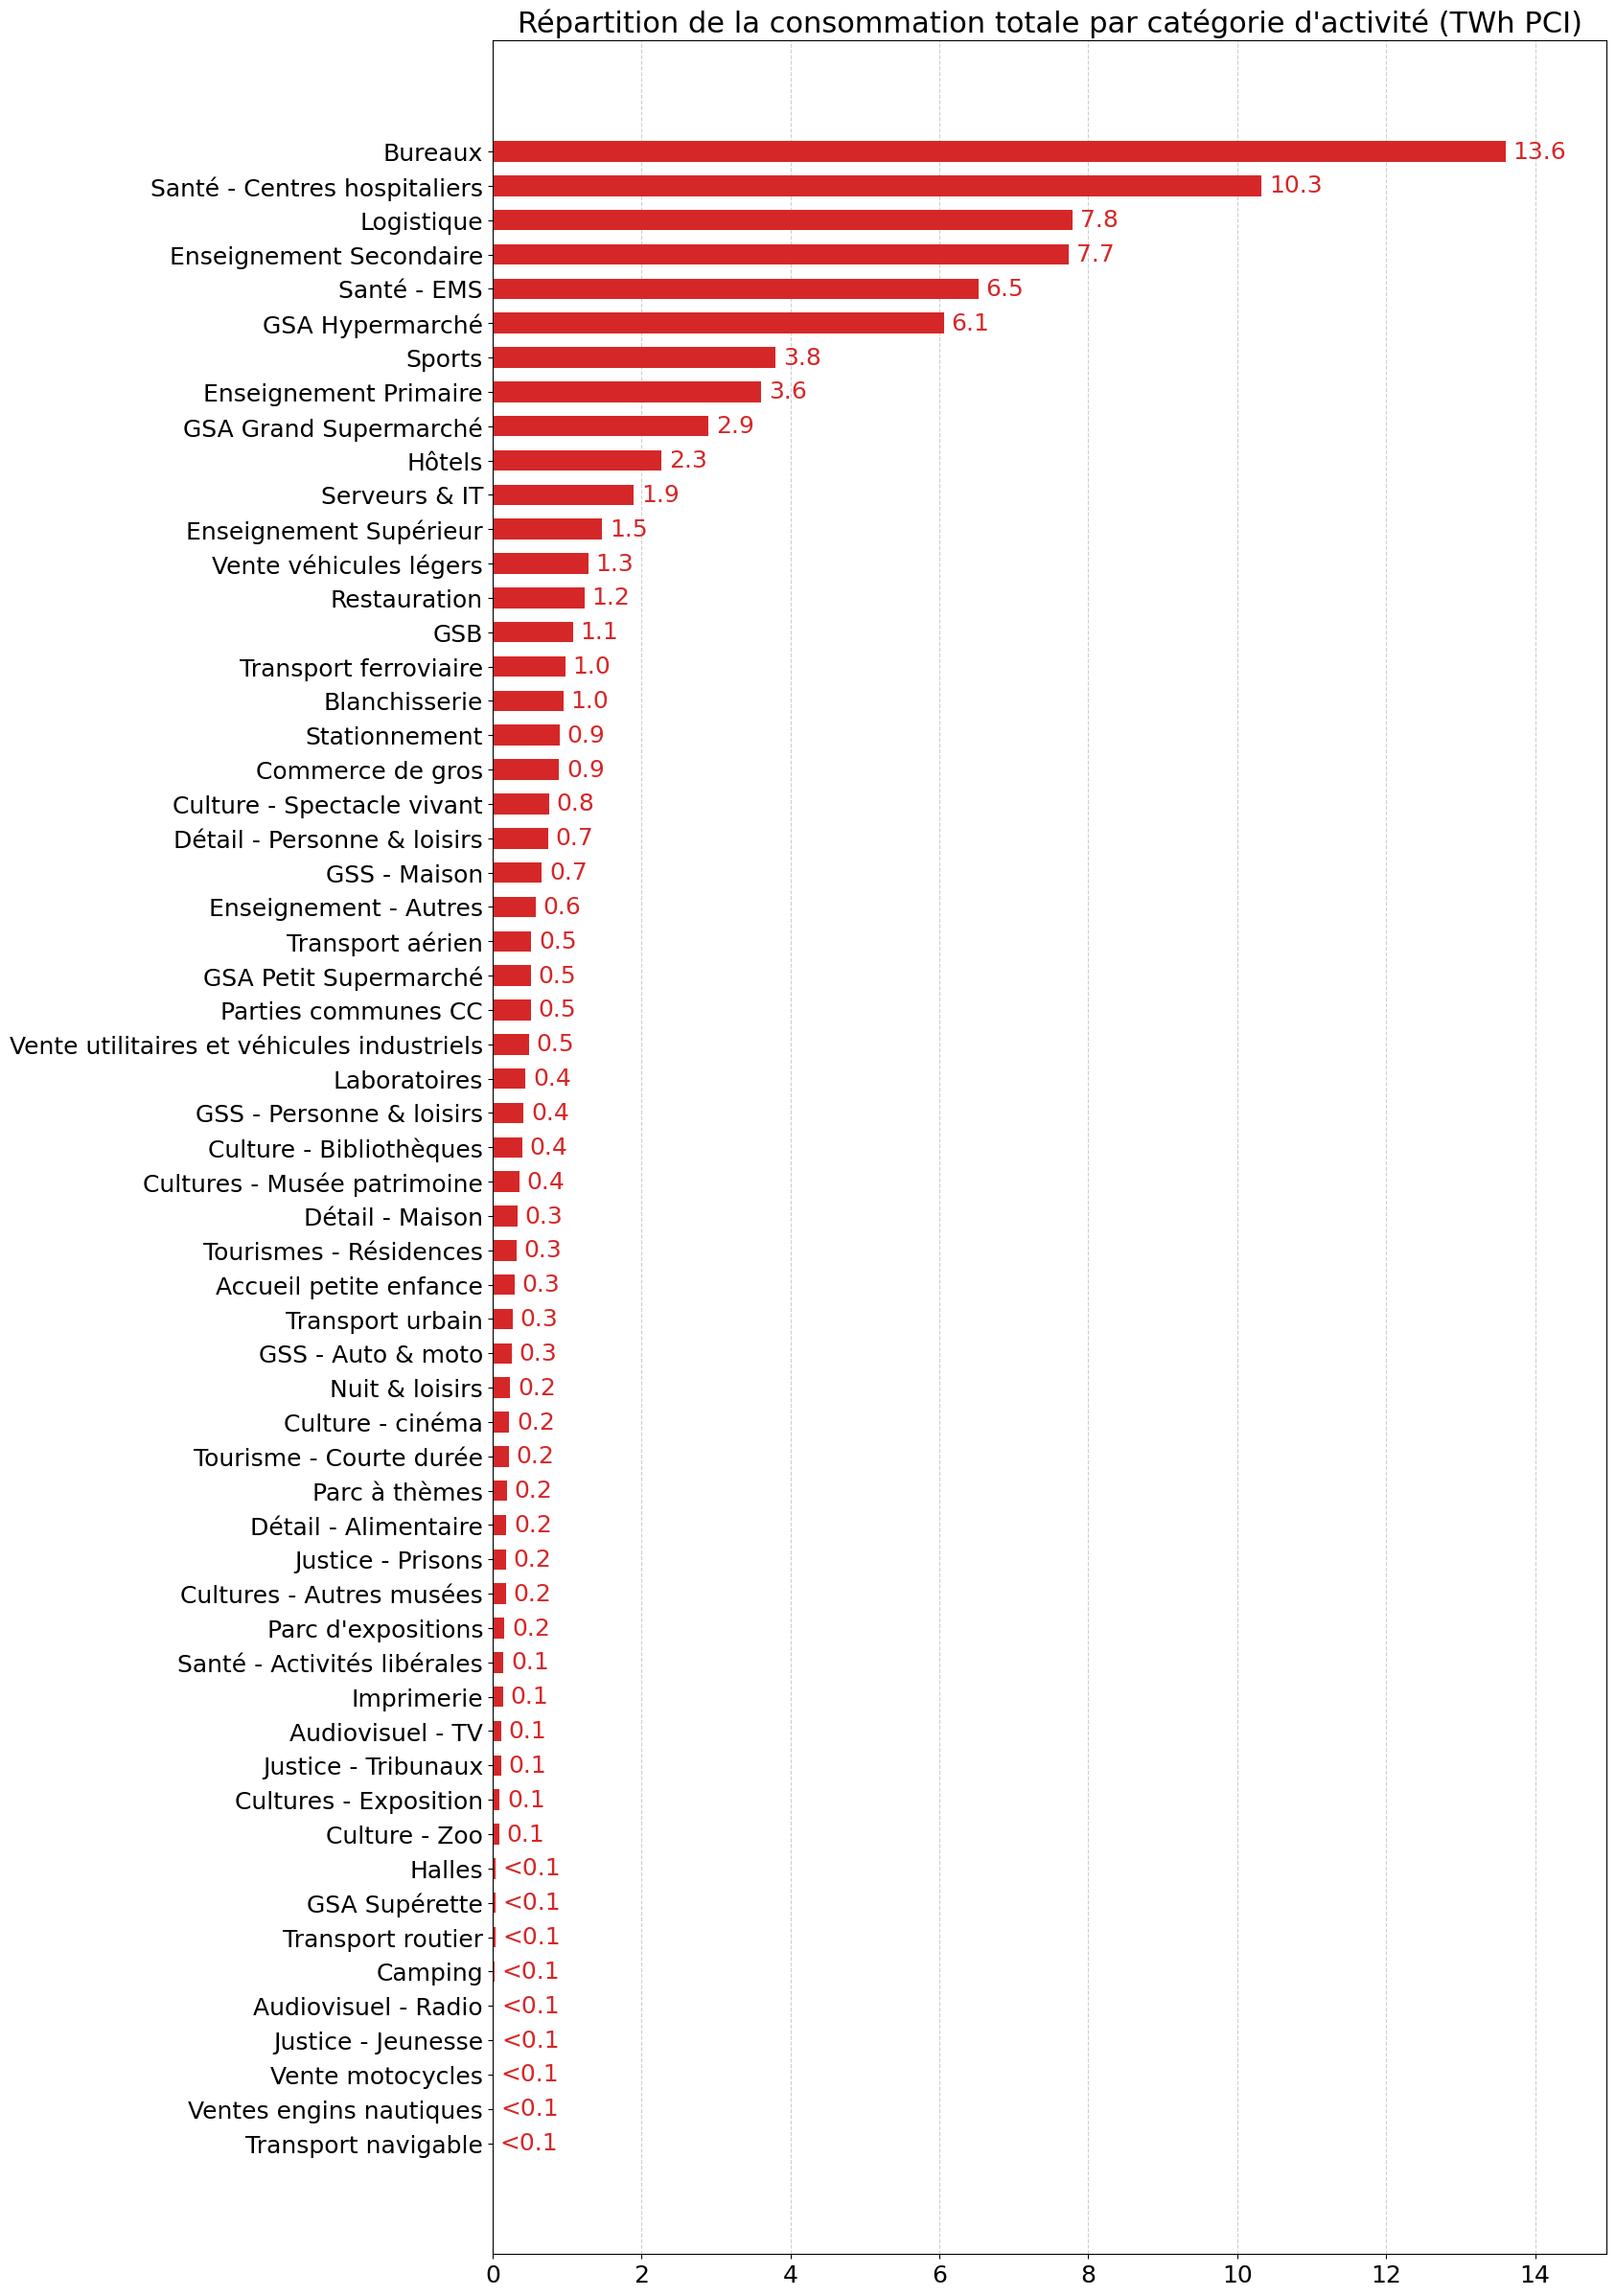

In [5]:
# Plot 3
fig, ax = plt.subplots(figsize=(15, 30))
distrib_CAP2 = distrib_CAP.loc[distrib_CAP["Total"] > 0].sort_values("Total")
bars = ax.barh(distrib_CAP2.index, distrib_CAP2["Total"], zorder=2, height=0.6, color='tab:red')
ax.set_title("Répartition de la consommation totale par catégorie d'activité (TWh PCI)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    value = round(bar.get_width(), 1)
    label = '<0.1' if value < 0.1 else format(value, '.1f')
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
            label, ha='left', va='center', fontsize=18, zorder=3, color='tab:red')
ax.set_xlim(0, distrib_CAP["Total"].max()*1.1)
plt.show()

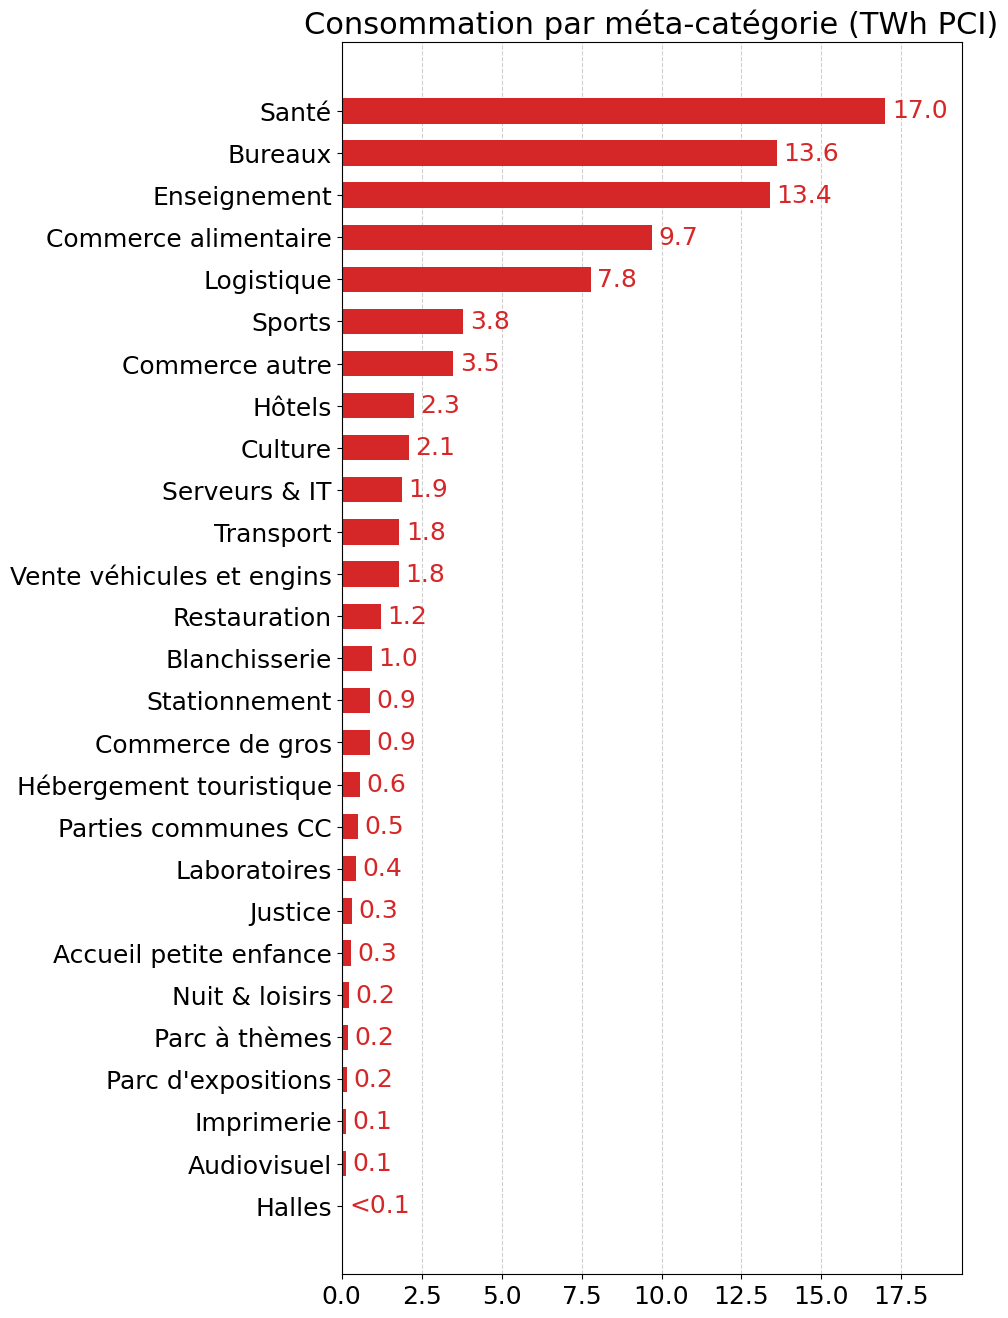

In [8]:
# Plot 4
fig, ax = plt.subplots(figsize=(8, 16))
distrib_meta_CAP2 = distrib_meta_CAP.loc[distrib_meta_CAP["Total"] > 0].sort_values("Total")
bars = ax.barh(distrib_meta_CAP2.index, distrib_meta_CAP2["Total"], zorder=2, height=0.6, color='tab:red')
ax.set_title("Consommation par méta-catégorie (TWh PCI)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    value = round(bar.get_width(), 1)
    label = '<0.1' if value < 0.1 else format(value, '.1f')
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
            label, ha='left', va='center', fontsize=18, zorder=3, color='tab:red')
ax.set_xlim(0, distrib_meta_CAP["Total"].max()*1.14)
plt.show()

In [22]:
cat = ["Enseignement", "Bureaux", "Logistique", "Santé", "Commerce autre", "Commerce alimentaire", "Sports", "Hôtels"]

part_surf = round(distrib_meta_CAP.loc[distrib_meta_CAP.index.isin(cat)]["Surface"].sum()/distrib_meta_CAP["Surface"].sum()*100,1)
part_nrg = round(distrib_meta_CAP.loc[distrib_meta_CAP.index.isin(cat)]["Total"].sum()/distrib_meta_CAP["Total"].sum()*100,1)

print(part_surf, part_nrg)

83.6 83.0


In [26]:
part_surf = round(distrib_meta_CAP.loc["Serveurs & IT"]["Surface"]/distrib_meta_CAP["Surface"].sum()*100,1)
part_nrg = round(distrib_meta_CAP.loc["Serveurs & IT"]["Total"]/distrib_meta_CAP["Total"].sum()*100,1)

print(part_surf, part_nrg)

0.1 2.2


In [27]:
part_surf = round(distrib_meta_CAP.loc["Stationnement"]["Surface"]/distrib_meta_CAP["Surface"].sum()*100,1)
part_nrg = round(distrib_meta_CAP.loc["Stationnement"]["Total"]/distrib_meta_CAP["Total"].sum()*100,1)

print(part_surf, part_nrg)

3.1 1.1


### <font color=greenyellow>Répartition des sources d’énergie par catégorie d’activité</font>

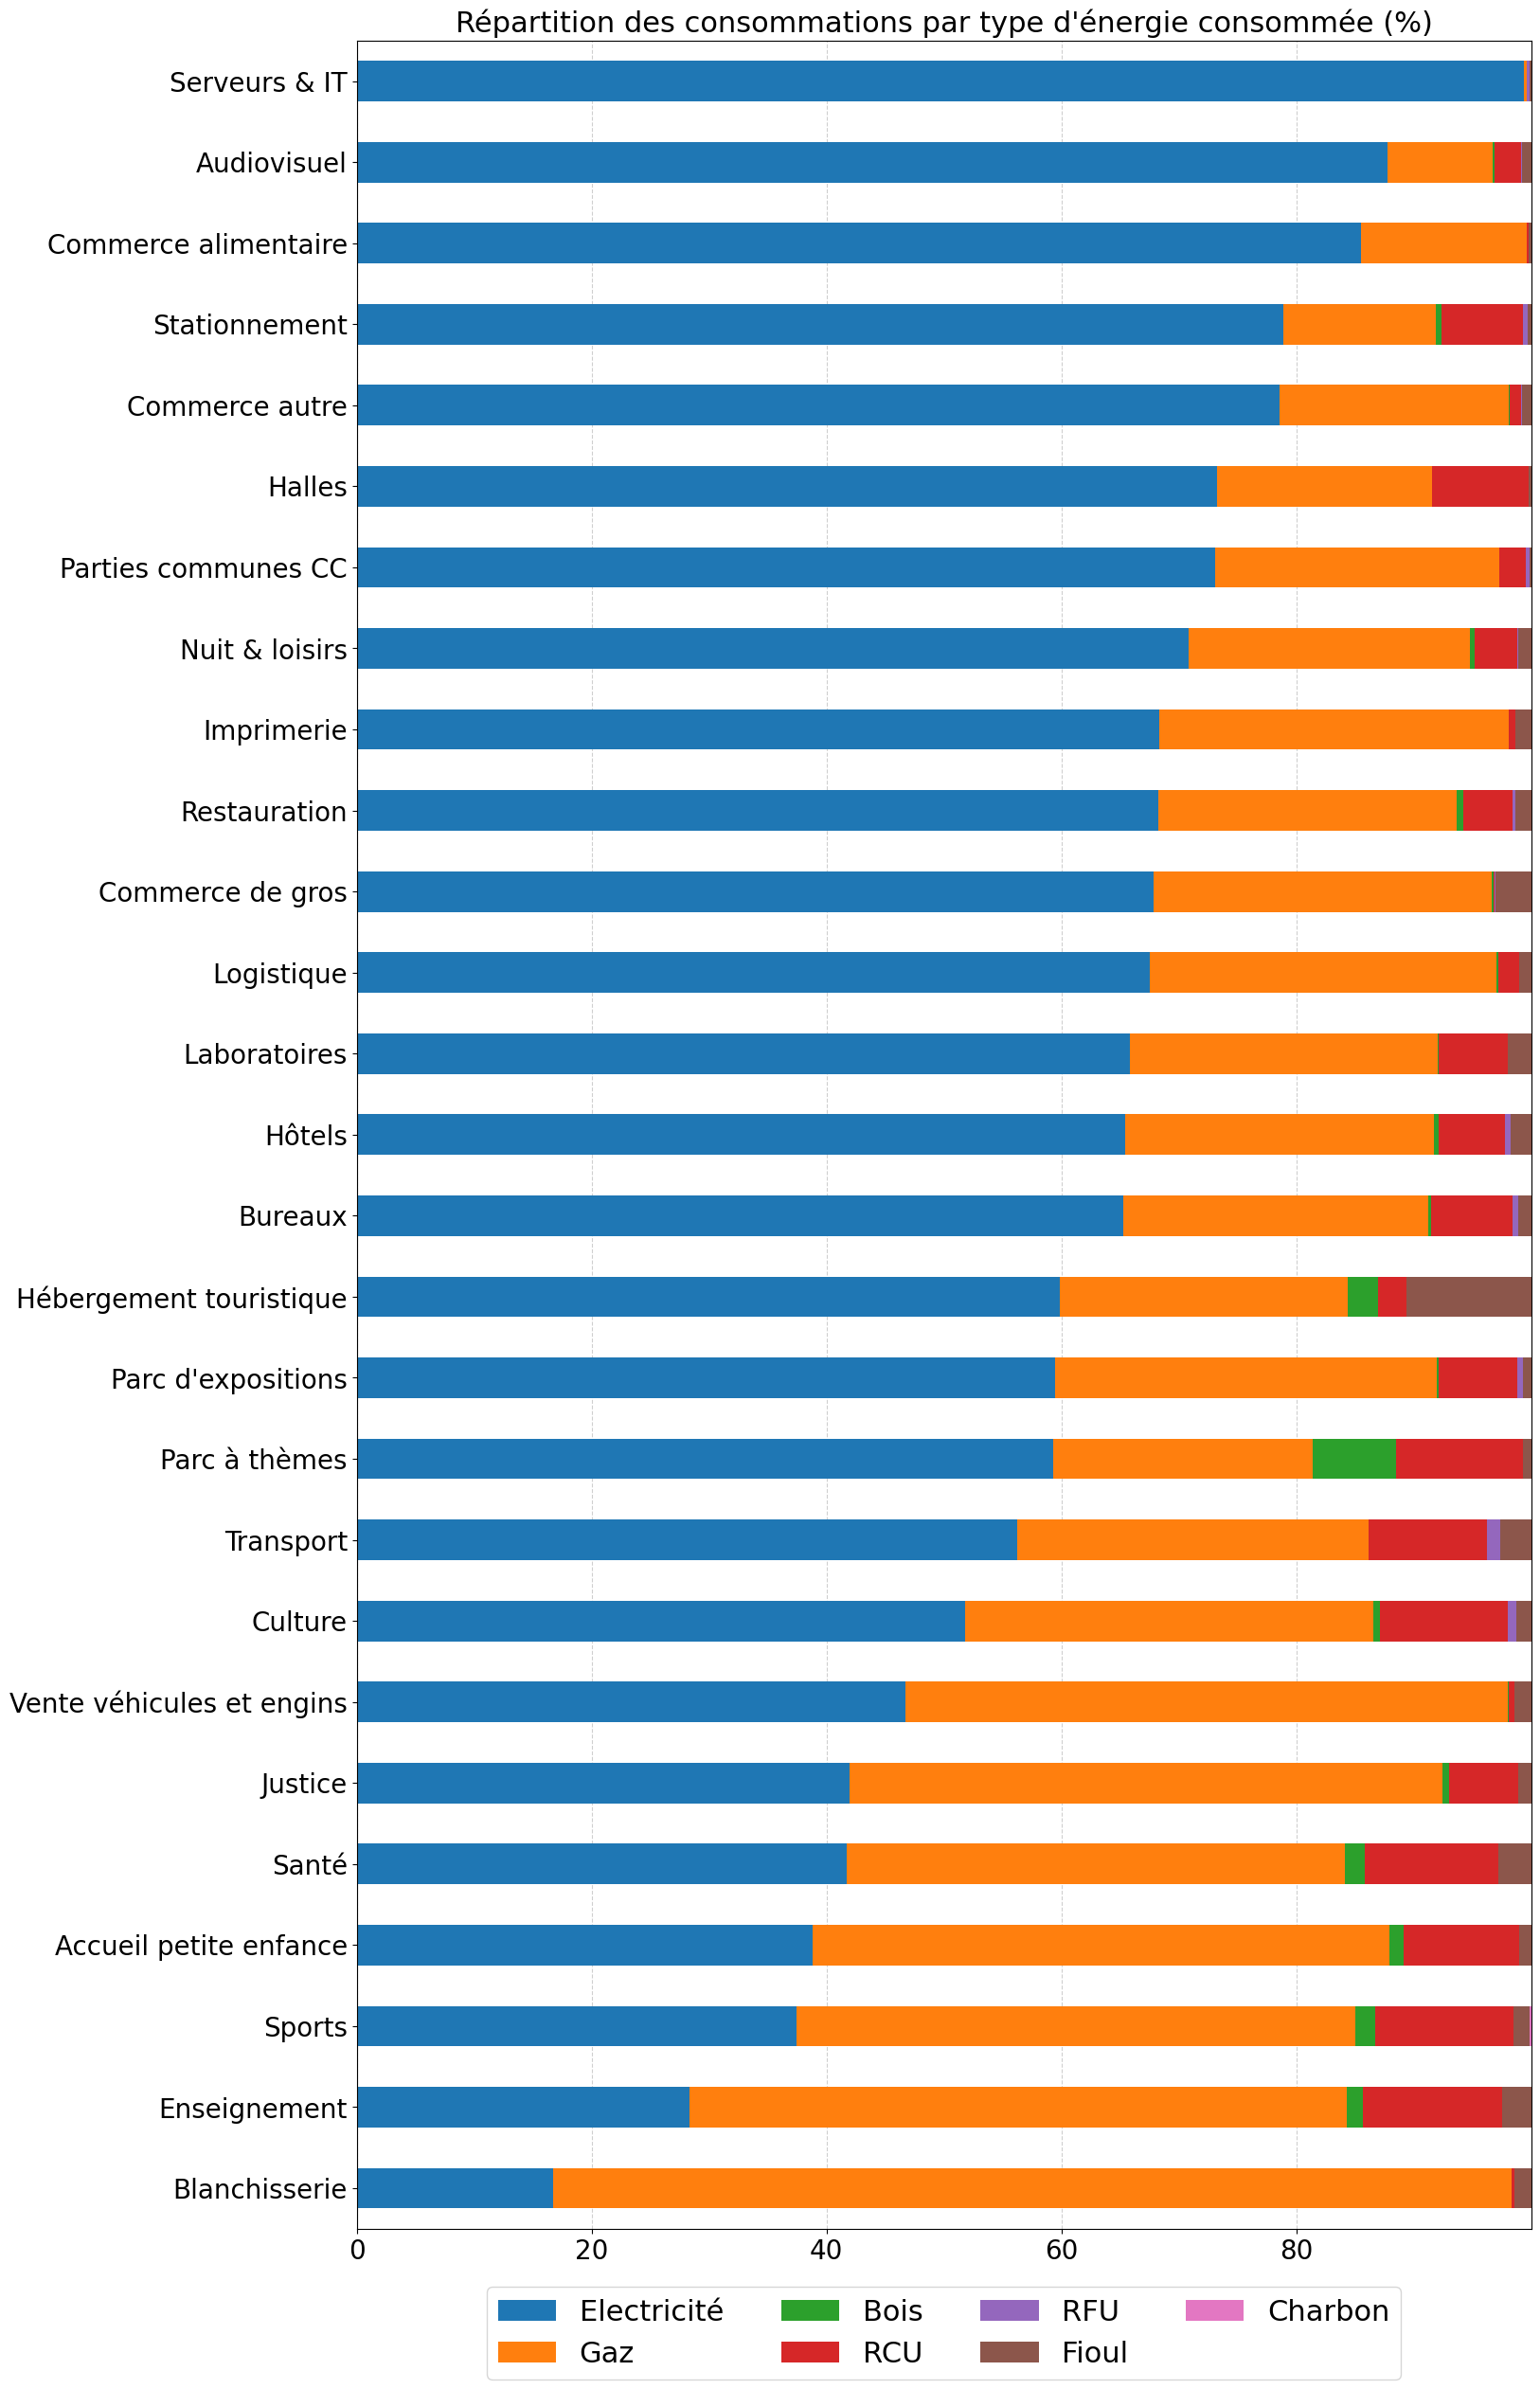

In [48]:
# Calcul % de chaque énergie
distrib_meta_CAP2 = distrib_meta_CAP.loc[distrib_meta_CAP["Total"] > 0].iloc[:, 1:]
for col in distrib_meta_CAP2:
    distrib_meta_CAP2.loc[:, col] = distrib_meta_CAP2[col]/distrib_meta_CAP2["Total"]*100
distrib_meta_CAP2 = distrib_meta_CAP2.iloc[:, :-1]
distrib_meta_CAP2 = distrib_meta_CAP2.sort_values('Electricité')

# Plot
ax = distrib_meta_CAP2.plot.barh(stacked=True, figsize=(16, 30), zorder=2)
ax.set_title("Répartition des consommations par type d'énergie consommée (%)",  fontsize=22)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=len(distrib_meta_CAP2.columns)-3, fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.show()

In [109]:
CAP_name_mapping

{'CAP00': 'Local vacant',
 'CAP01': 'Accueil petite enfance',
 'CAP0201': 'Audiovisuel - Radio',
 'CAP0202': 'Audiovisuel - TV',
 'CAP03': 'Blanchisserie',
 'CAP04': 'Bureaux',
 'CAP0501': 'Commerce de gros',
 'CAP0502': 'GSA Supérette',
 'CAP0503': 'GSA Petit Supermarché',
 'CAP0504': 'GSA Grand Supermarché',
 'CAP0505': 'GSA Hypermarché',
 'CAP0506': 'GSB',
 'CAP0507': 'GSS - Personne & loisirs',
 'CAP0508': 'GSS - Maison',
 'CAP0509': 'GSS - Auto & moto',
 'CAP0510': 'Parties communes CC',
 'CAP0511': 'Détail - Personne & loisirs',
 'CAP0512': 'Détail - Maison',
 'CAP0513': 'Détail - Alimentaire',
 'CAP0514': 'Halles',
 'CAP0601': 'Culture - Bibliothèques',
 'CAP0602': 'Cultures - Musée patrimoine',
 'CAP0603': 'Cultures - Autres musées',
 'CAP0604': 'Cultures - Exposition',
 'CAP0605': 'Culture - Spectacle vivant',
 'CAP0606': 'Culture - cinéma',
 'CAP0607': 'Culture - Zoo',
 'CAP0701': 'Enseignement Primaire',
 'CAP0702': 'Enseignement Secondaire',
 'CAP0703': 'Enseignement Supéri

In [144]:
codes = meta_cap_all['Parc à thèmes']

data = df_extract.loc[df_extract[["Code CAP-M", "Code CAP-S"]].isin(codes).any(axis=1)]

conso = data[nrg_agreg["Bois"]].sum(axis=1)

print(len(conso))

print(len(conso[conso > 0]))

print(conso[conso > 0].max()/conso[conso > 0].sum())

173
2
0.9874913783336282


In [153]:
data["Ratio (kWh PCI / m2) - Corrigé"].sort_values().describe()

count     173.000000
mean      259.634432
std       293.548232
min        12.541000
25%        46.610000
50%       148.076429
75%       417.549780
max      2125.892857
Name: Ratio (kWh PCI / m2) - Corrigé, dtype: float64

In [152]:
df_extract.loc[695691]["Ratio (kWh PCI / m2) - Corrigé"]

884.5523770918987

In [142]:
df_extract.loc[695691][["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]]

Surface moyenne annuelle catégorie d'activité majoritaire (m²)    17269.0
Name: 695691, dtype: object

In [154]:
for nrg in nrg_agreg:
    print(nrg)
    print(df_extract.loc[695691][nrg_agreg[nrg]].sum())

Electricité
1861735.0
Gaz
0
Bois
13413600.0
RCU
0
RFU
0
Fioul
0
Charbon
0


In [117]:
df_extract.loc[495633][['Surface totale brute (m²)']]

Surface totale brute (m²)    37022.8
Name: 495633, dtype: object

In [116]:
df.columns

Index(['id', 'Annee Consommation', 'Date de début de la déclaration',
       'ID interne EFA', 'IUBs EFA', 'Statut', 'Commune', 'Departement',
       'Region', 'Station meteo', 'Zone climatique', 'Classe altitude',
       'Categorie d'activite majoritaire',
       'Surface moyenne annuelle catégorie d'activité majoritaire (m²)',
       'Categorie d'activite secondaire',
       'Surface moyenne annuelle catégorie d'activité secondaire (m²)',
       'Surface totale brute (m²)', 'Surface moyenne annuelle totale chauffée',
       'Surface moyenne annuelle totale refroidie',
       'Surface moyenne annuelle totale froid process',
       'Categorie d'activite principale',
       'Sous Categorie d'activite majoritaire',
       'Surface moyenne annuelle sous-catégorie d'activité majoritaire (m²)',
       'Sous-catégorie d'activité secondaire',
       'Surface moyenne annuelle sous-catégorie d'activité secondaire (m²)',
       'Dont Data Center', 'Nb sous categories distinctes',
       'Nb cate

In [98]:
data[nrg_agreg["Bois"]].sum(axis=1).sort_values()

262             0.0
360753          0.0
360576          0.0
360343          0.0
360274          0.0
            ...    
315560     388424.0
3363       524027.0
292293     719685.0
453837     840667.0
495633    7840085.0
Length: 1336, dtype: float64

## <font color=yellow>Indicateurs de consommation d'énergie finale</font>

### <font color=greenyellow>Indicateurs généraux : consommation d'énergie finale surfacique par catégorie d'activité</font>

#### <font color=pink>Consommation moyenne</font>

In [240]:
threshold_CAP = 90

years = ['2020', '2021', '2022']

df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3]
print("{}%".format(int(round(len(df_extract)/len(df)*100,0))))


df_extract = df_extract.loc[df_extract["Annee Consommation"].isin(years)]
print("{}%".format(int(round(len(df_extract)/len(df)*100,0))))

surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]
print("{}%".format(int(round(len(df_extract)/len(df)*100,0))))

73%
57%
52%


In [259]:
# On calcule 2 dict : 1 avec les distribution de conso surfacique par CAP et 1 par meta-CAP 
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

# Sélection du périmètre (scores --> années de conso --> déclarations validées)
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Liste des code CAP triés comme dans le fichier Excel
list_code_cap = ('CAP' + df_extract['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list()

# Distributions des conso par CAP
distrib_cap = {}
for code_cap in list_code_cap:   
    df_cap = df_extract.loc[df_extract['Code CAP-M'] == code_cap]
    cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0]
    distrib_cap[cap_short] = df_cap["Ratio (kWh PCI / m2) - Corrigé"]

if 'Local vacant' in distrib_cap:
    distrib_cap.pop('Local vacant')
distrib_cap = dict(sorted(distrib_cap.items(), key=lambda x: x[1].mean()))

# Distributions des conso par meta-CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}
distrib_meta_cap = {}
for meta_cap in meta_cap_all:
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]
    distrib_meta_cap[meta_cap] = df_cap["Ratio (kWh PCI / m2) - Corrigé"]
 
distrib_meta_cap = dict(sorted(distrib_meta_cap.items(), key=lambda x: x[1].mean()))

# Mêmes dict mais avec la moyenne uniquement
distrib_cap_mean = pd.Series({cap: nrg.mean() for cap, nrg in distrib_cap.items()})
distrib_meta_cap_mean = pd.Series({meta_cap: nrg.mean() for meta_cap, nrg in distrib_meta_cap.items()})

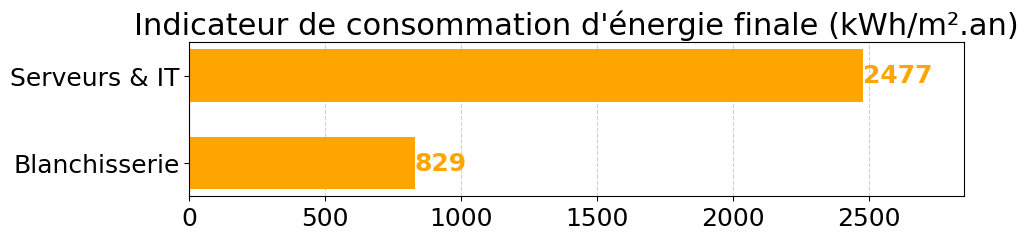

In [260]:
###################################################### CAP ####################################################

# On sépare les données en 2 : lorsque la moyenne est au-dessus d'un certain seuil, on trace la CAP à part
threshold_plot = 700

distrib_cap_mean_high_nrg = {}
distrib_cap_mean_low_nrg = {}
for cap, nrg in distrib_cap_mean.items():
    if nrg > threshold_plot:
        distrib_cap_mean_high_nrg[cap] = nrg
    else:
        distrib_cap_mean_low_nrg[cap] = nrg
distrib_cap_mean_low_nrg = pd.Series(distrib_cap_mean_low_nrg)
distrib_cap_mean_high_nrg = pd.Series(distrib_cap_mean_high_nrg)

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
bars = ax.barh(distrib_cap_mean_high_nrg.index, distrib_cap_mean_high_nrg, zorder=2, height=0.6, color='orange')
ax.set_title("Indicateur de consommation d'énergie finale (kWh/m².an)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            format(int(round(bar.get_width(),0))), ha='left', va='center', fontsize=18, zorder=3, color='orange', weight='bold')
plt.xlim(left=0, right=distrib_cap_mean_high_nrg.max()*1.15)
plt.show()

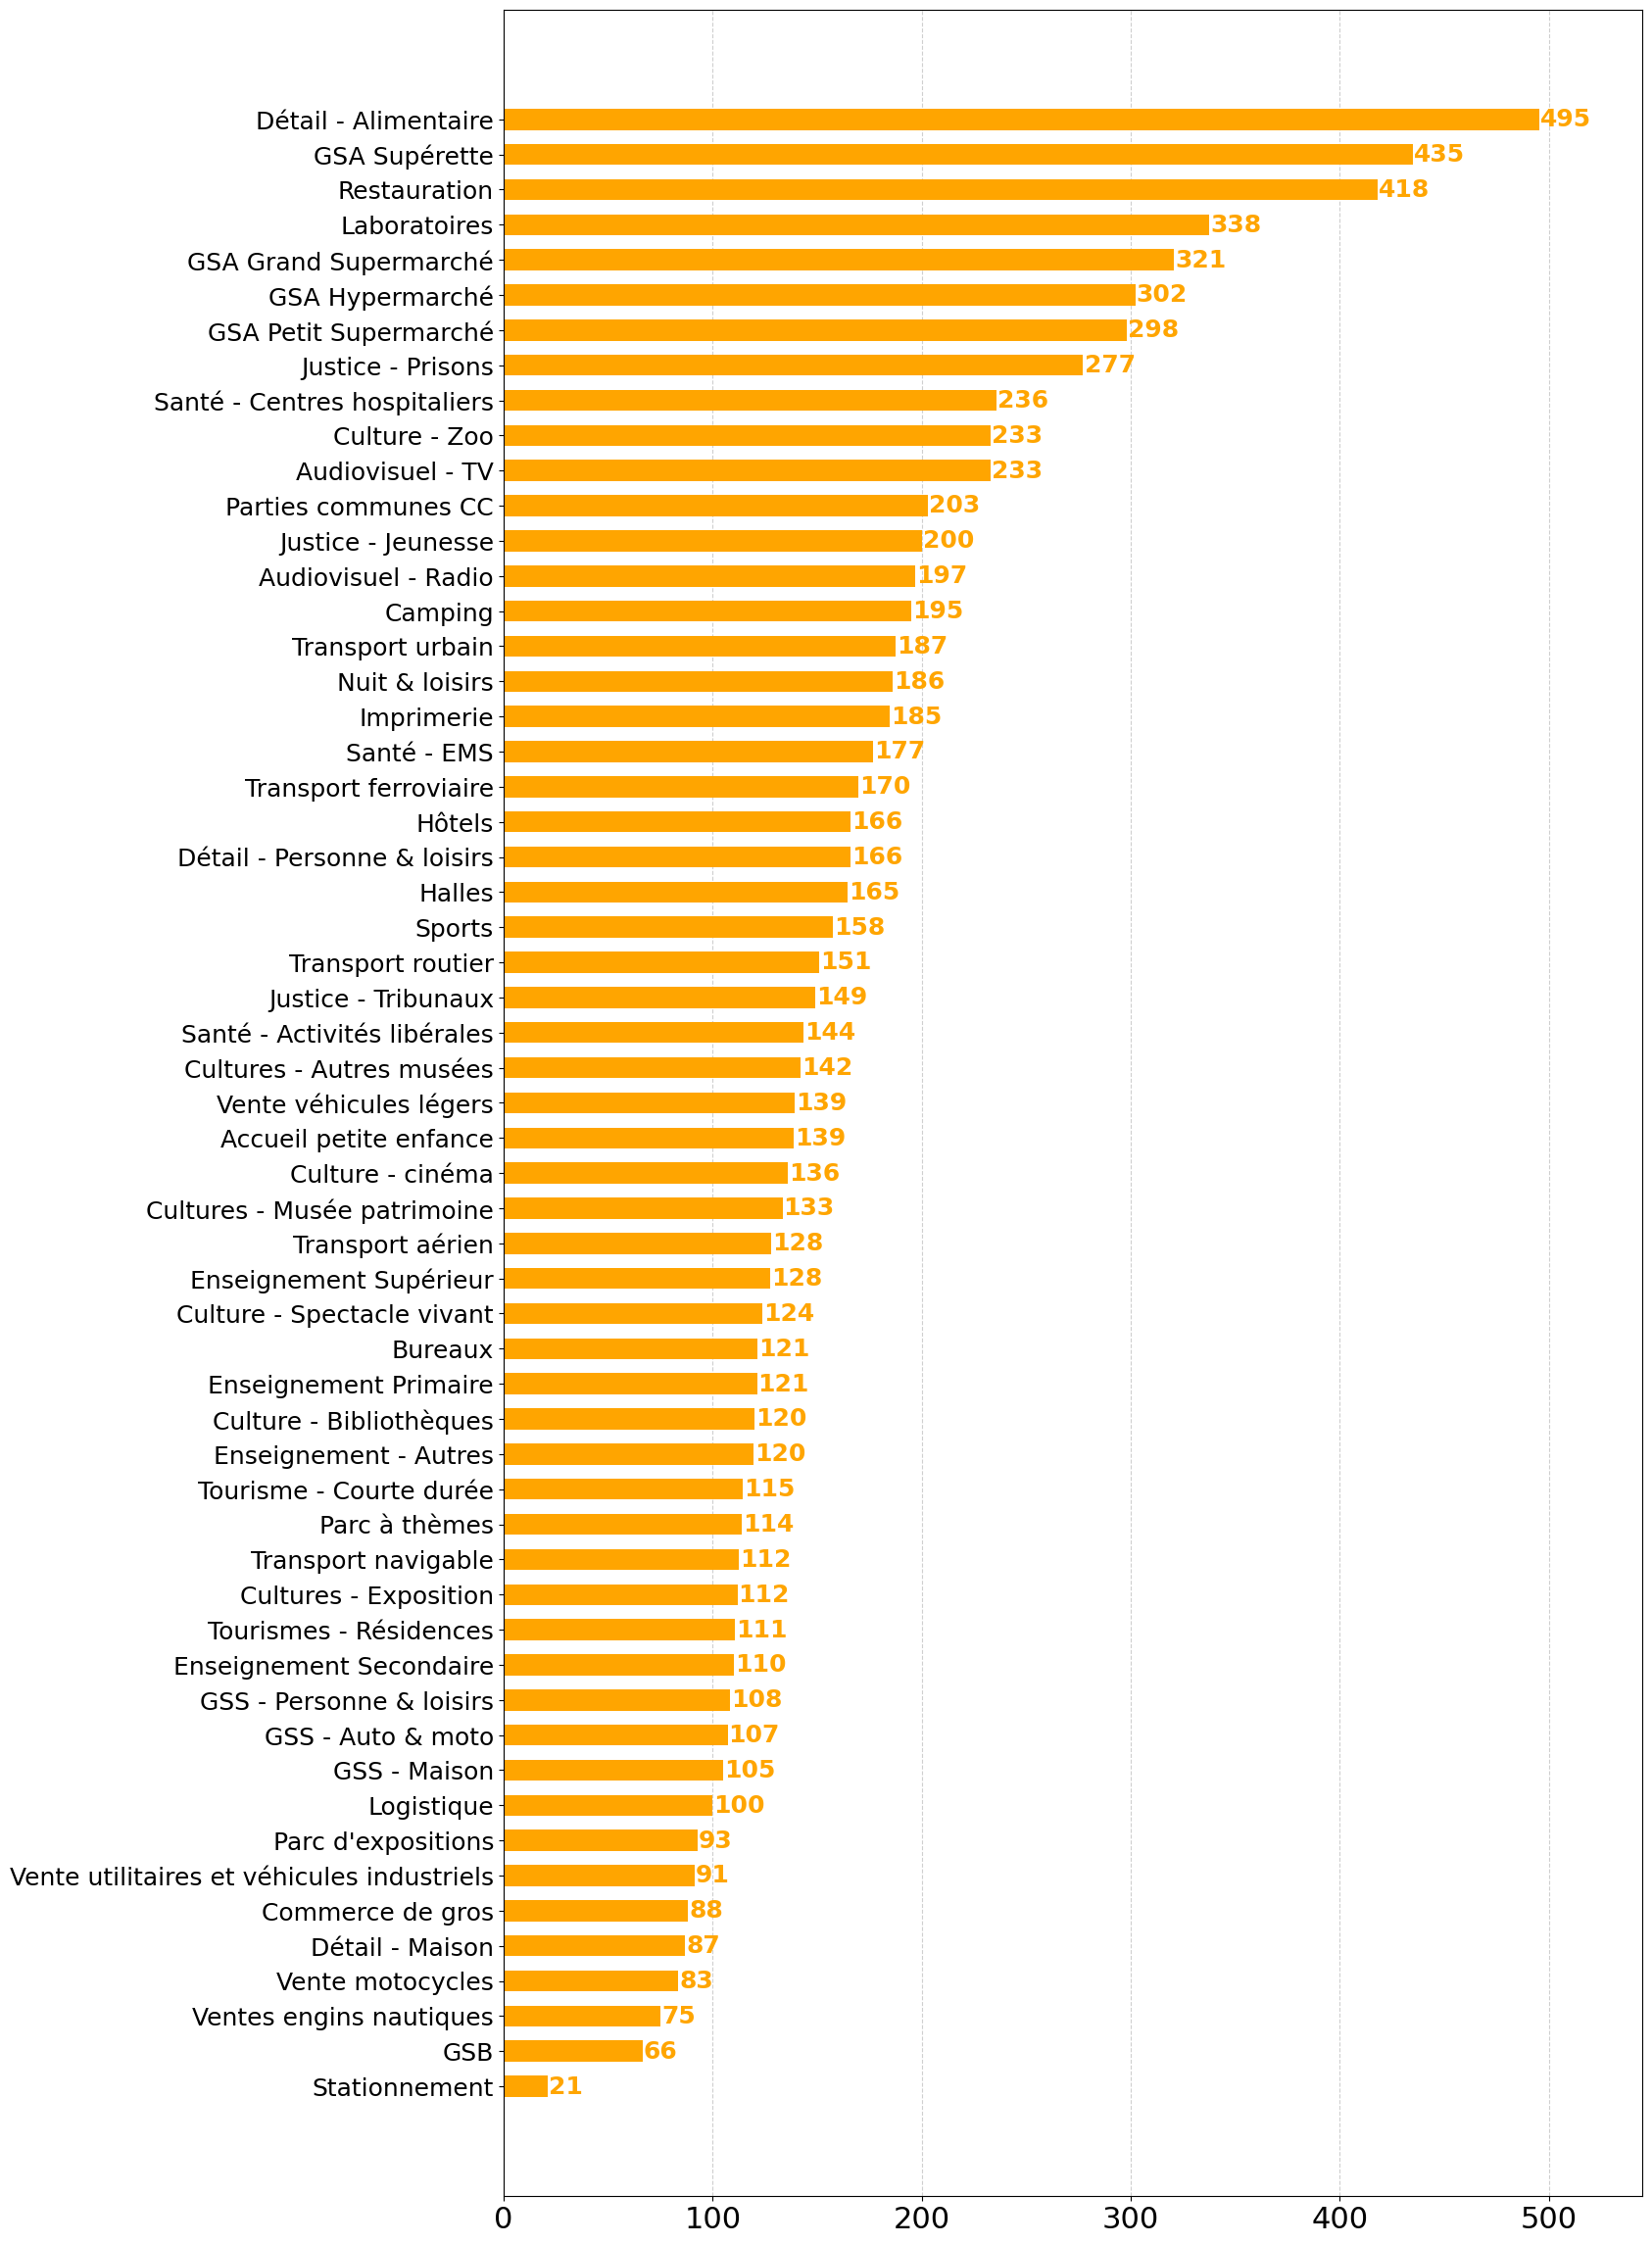

In [261]:
# Plot
fig_height = len(distrib_cap_mean_low_nrg)/len(distrib_cap)*30
fig, ax = plt.subplots(figsize=(15, fig_height))
bars = ax.barh(distrib_cap_mean_low_nrg.index, distrib_cap_mean_low_nrg, zorder=2, height=0.6, color='orange')
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            format(int(round(bar.get_width(),0))), ha='left', va='center', fontsize=18, zorder=3, color='orange', weight='bold')
plt.xlim(left=0, right=distrib_cap_mean_low_nrg.max()*1.1)
plt.show()

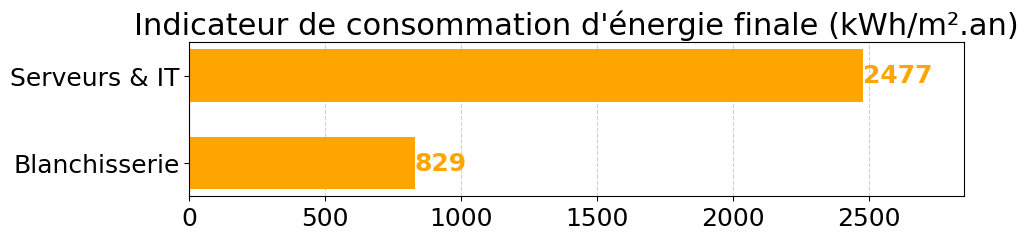

In [262]:
###################################################### META-CAP ####################################################

# On sépare les données en 2 : lorsque la moyenne est au-dessus d'un certain seuil, on trace la CAP à part
threshold_plot = 700

distrib_meta_cap_mean_high_nrg = {}
distrib_meta_cap_mean_low_nrg = {}
for cap, nrg in distrib_meta_cap_mean.items():
    if nrg > threshold_plot:
        distrib_meta_cap_mean_high_nrg[cap] = nrg
    else:
        distrib_meta_cap_mean_low_nrg[cap] = nrg
distrib_meta_cap_mean_low_nrg = pd.Series(distrib_meta_cap_mean_low_nrg)
distrib_meta_cap_mean_high_nrg = pd.Series(distrib_meta_cap_mean_high_nrg)

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
bars = ax.barh(distrib_meta_cap_mean_high_nrg.index, distrib_meta_cap_mean_high_nrg, zorder=2, height=0.6, color='orange')
ax.set_title("Indicateur de consommation d'énergie finale (kWh/m².an)", fontsize=22)
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
for bar in bars.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            format(int(round(bar.get_width(),0))), ha='left', va='center', fontsize=18, zorder=3, color='orange', weight='bold')
plt.xlim(left=0, right=distrib_meta_cap_mean_high_nrg.max()*1.15)
plt.show()

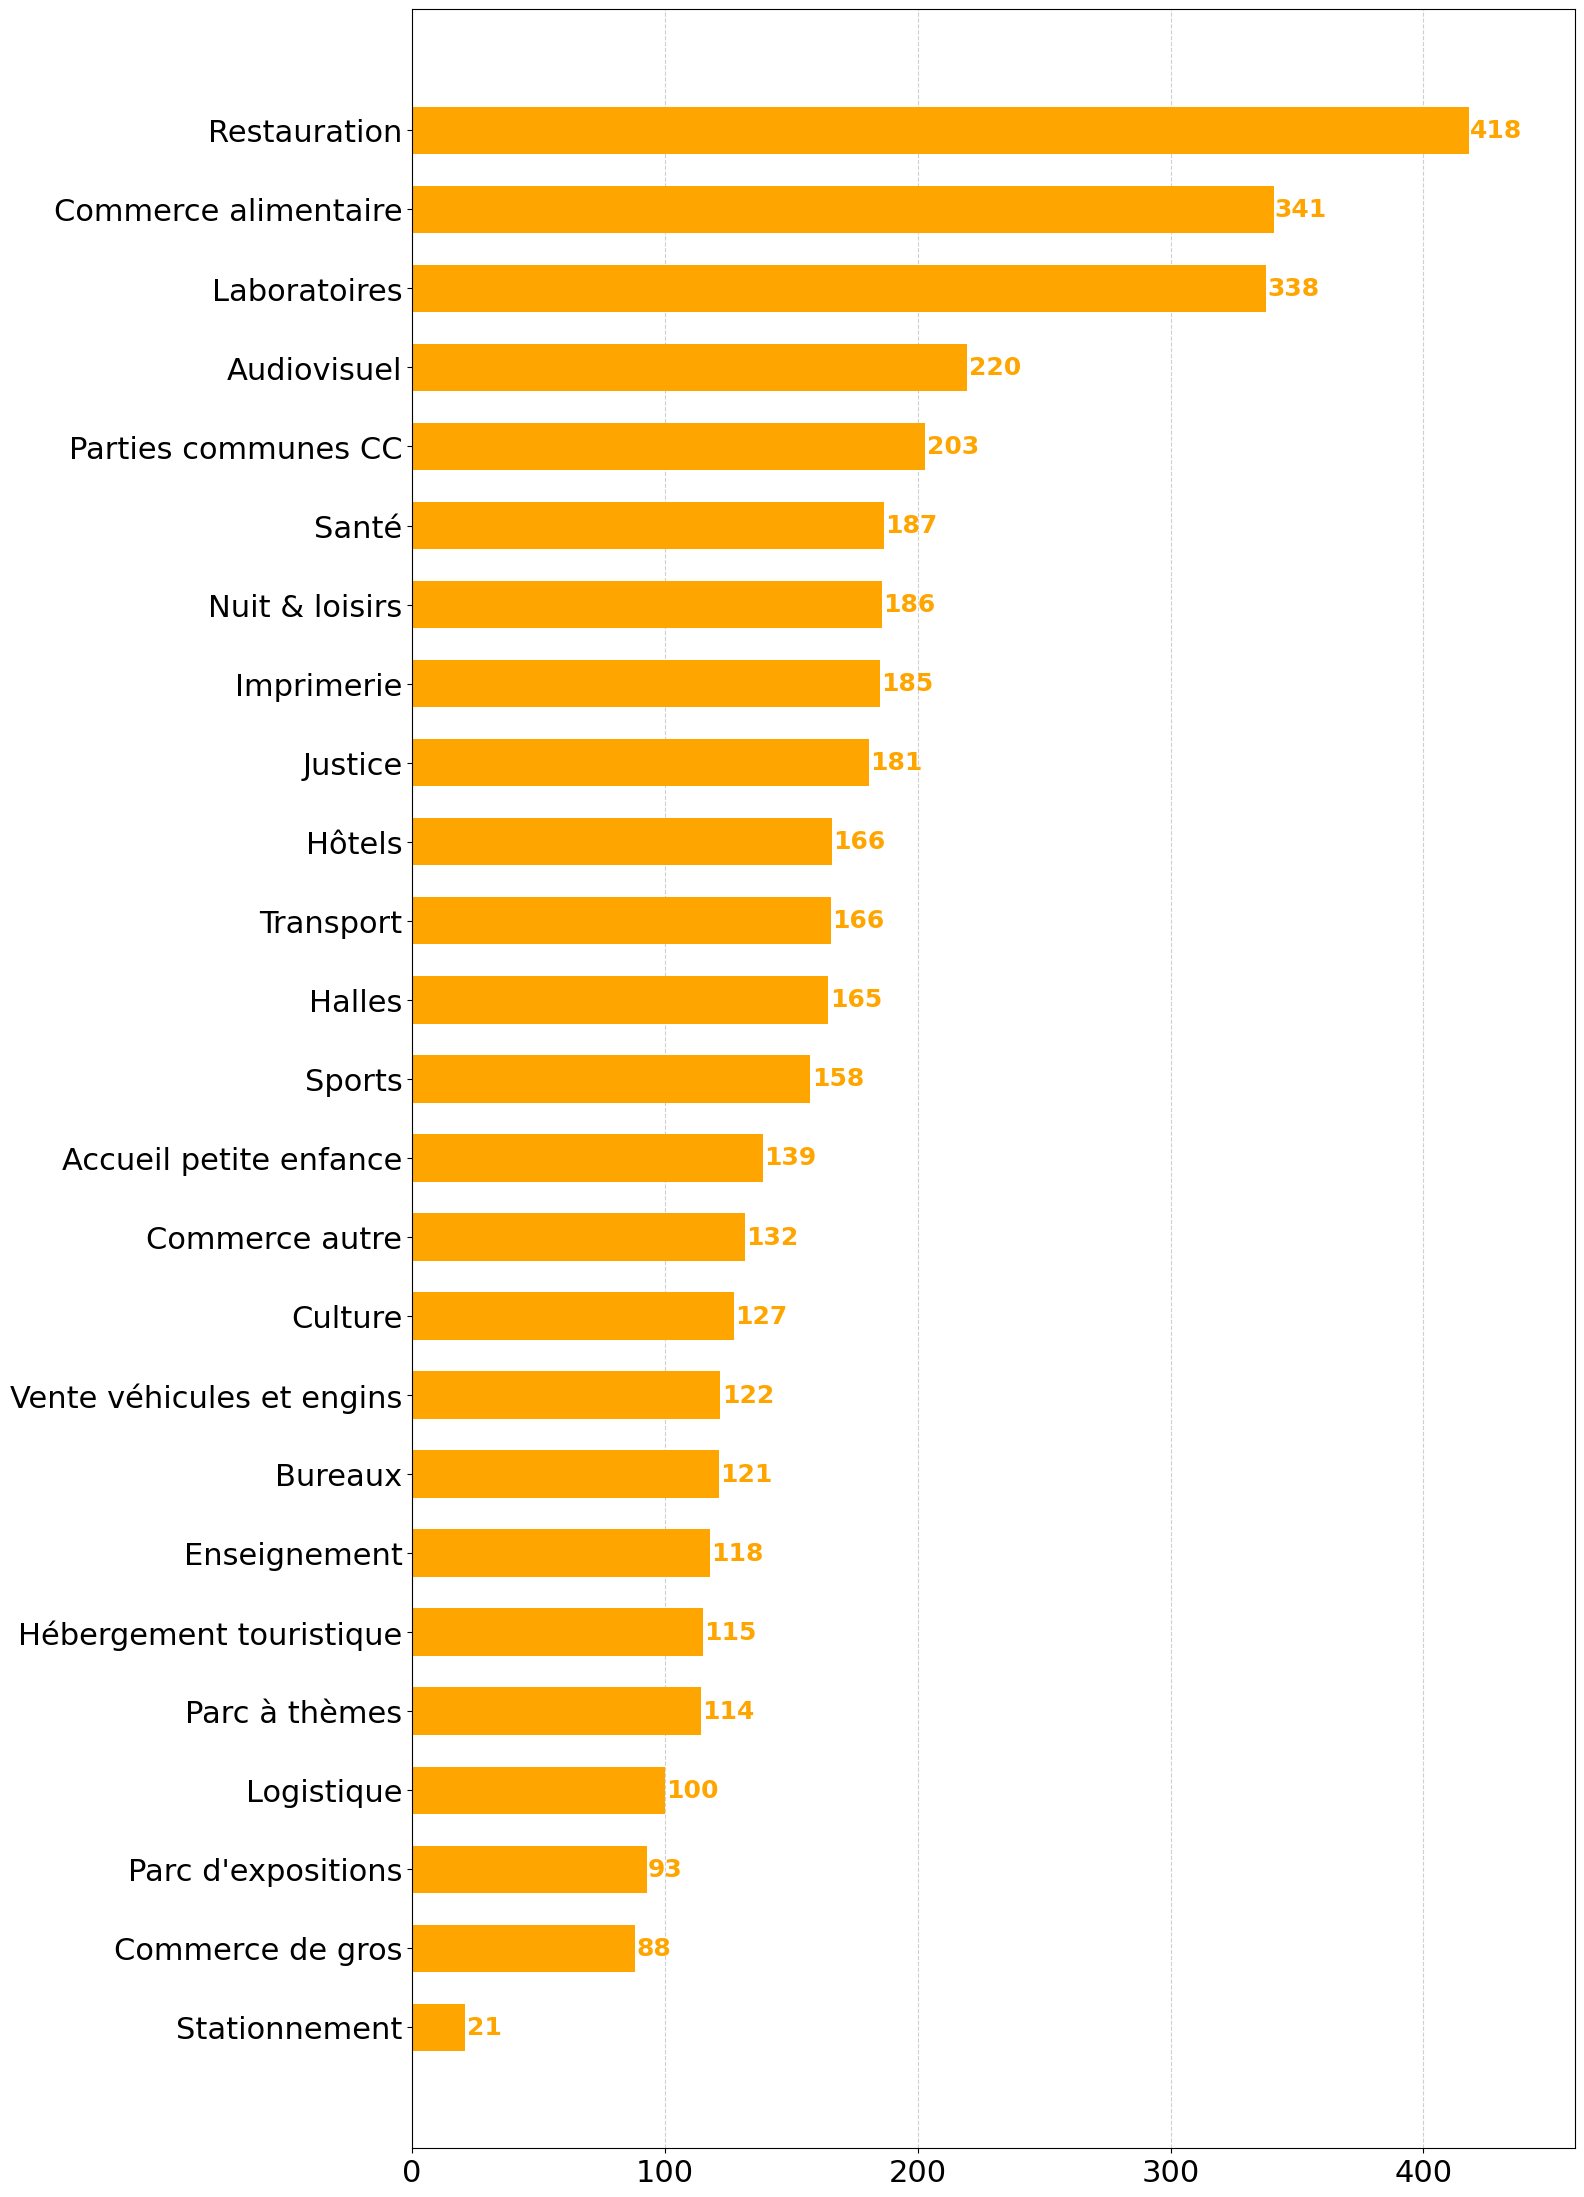

In [263]:
# Plot
fig_height = len(distrib_meta_cap_mean_low_nrg)/len(distrib_meta_cap)*30
fig, ax = plt.subplots(figsize=(15, fig_height))
bars = ax.barh(distrib_meta_cap_mean_low_nrg.index, distrib_meta_cap_mean_low_nrg, zorder=2, height=0.6, color='orange')
ax.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
for bar in bars.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            format(int(round(bar.get_width(),0))), ha='left', va='center', fontsize=18, zorder=3, color='orange', weight='bold')
plt.xlim(left=0, right=distrib_meta_cap_mean_low_nrg.max()*1.1)
plt.show()

#### <font color=pink>Distribution des consommations</font>

In [269]:
# On calcule 2 dict : 1 avec les distribution de conso surfacique par CAP et 1 par meta-CAP 
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

# Sélection du périmètre (scores --> années de conso --> déclarations validées)
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Liste des code CAP triés comme dans le fichier Excel
list_code_cap = ('CAP' + df_extract['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list()

# Distributions des conso par CAP
distrib_cap = {}
for code_cap in list_code_cap:   
    df_cap = df_extract.loc[df_extract['Code CAP-M'] == code_cap]
    cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0]
    distrib_cap[cap_short] = df_cap["Ratio (kWh PCI / m2) - Corrigé"]

if 'Local vacant' in distrib_cap:
    distrib_cap.pop('Local vacant')
distrib_cap = dict(sorted(distrib_cap.items(), key=lambda x: x[1].mean()))

# Distributions des conso par meta-CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}
distrib_meta_cap = {}
for meta_cap in meta_cap_all:
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]
    distrib_meta_cap[meta_cap] = df_cap["Ratio (kWh PCI / m2) - Corrigé"]
 
distrib_meta_cap = dict(sorted(distrib_meta_cap.items(), key=lambda x: x[1].mean()))

# Mêmes dict mais avec la moyenne uniquement
distrib_cap_mean = pd.Series({cap: nrg.mean() for cap, nrg in distrib_cap.items()})
distrib_meta_cap_mean = pd.Series({meta_cap: nrg.mean() for meta_cap, nrg in distrib_meta_cap.items()})

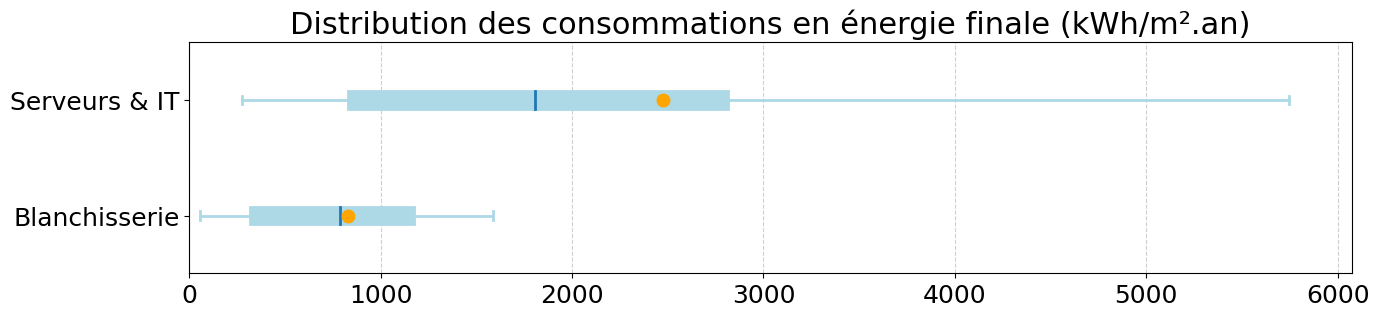

In [272]:
###################################################### CAP ####################################################
threshold_plot = 1100 # Si la box dépasse cette limite, on plot séparément pour ne pas écraser le graphe
max_data_to_plot = 90 # Extension max de la box à droite en % de la distribution (ex : 90% --> on trace jusqu'au 9ème décile, i.e. 80% des données représentées)

# On sépare les données en 2 : lorsque le n_ème quantile (droite de la barre) est au-dessus d'un certain seuil, on trace la CAP à part
distrib_cap_high_nrg = {}
distrib_cap_low_nrg = {}
for cap, nrg in distrib_cap.items():
    box_right_lim = nrg.quantile(max_data_to_plot/100)
    if box_right_lim > threshold_plot:
        distrib_cap_high_nrg[cap] = nrg
    else:
        distrib_cap_low_nrg[cap] = nrg

# Plot 1 (CAP énergivores)
plt.figure(figsize=(15, 3))
boxprops = dict(edgecolor='lightblue',facecolor='lightblue', alpha=1, linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2, color='lightblue')
capprops = dict(linestyle='-', linewidth=2, color='lightblue')
medianprops = dict(color='tab:blue', linewidth=2)
meanprops = dict(marker='o', markeredgecolor='orange', markerfacecolor='orange', markersize=9)
whiskers = (100-max_data_to_plot, max_data_to_plot)
plt.boxplot(distrib_cap_high_nrg.values(), labels=distrib_cap_high_nrg.keys(), sym='', showmeans=True, whis=whiskers, vert=False, boxprops=boxprops, patch_artist=True,
            capprops=capprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops)
plt.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.title("Distribution des consommations en énergie finale (kWh/m².an)", fontsize=22)
plt.xlim(left=0, right=max(nrg.quantile(max_data_to_plot/100) for nrg in distrib_cap_high_nrg.values())*1.05)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.show()

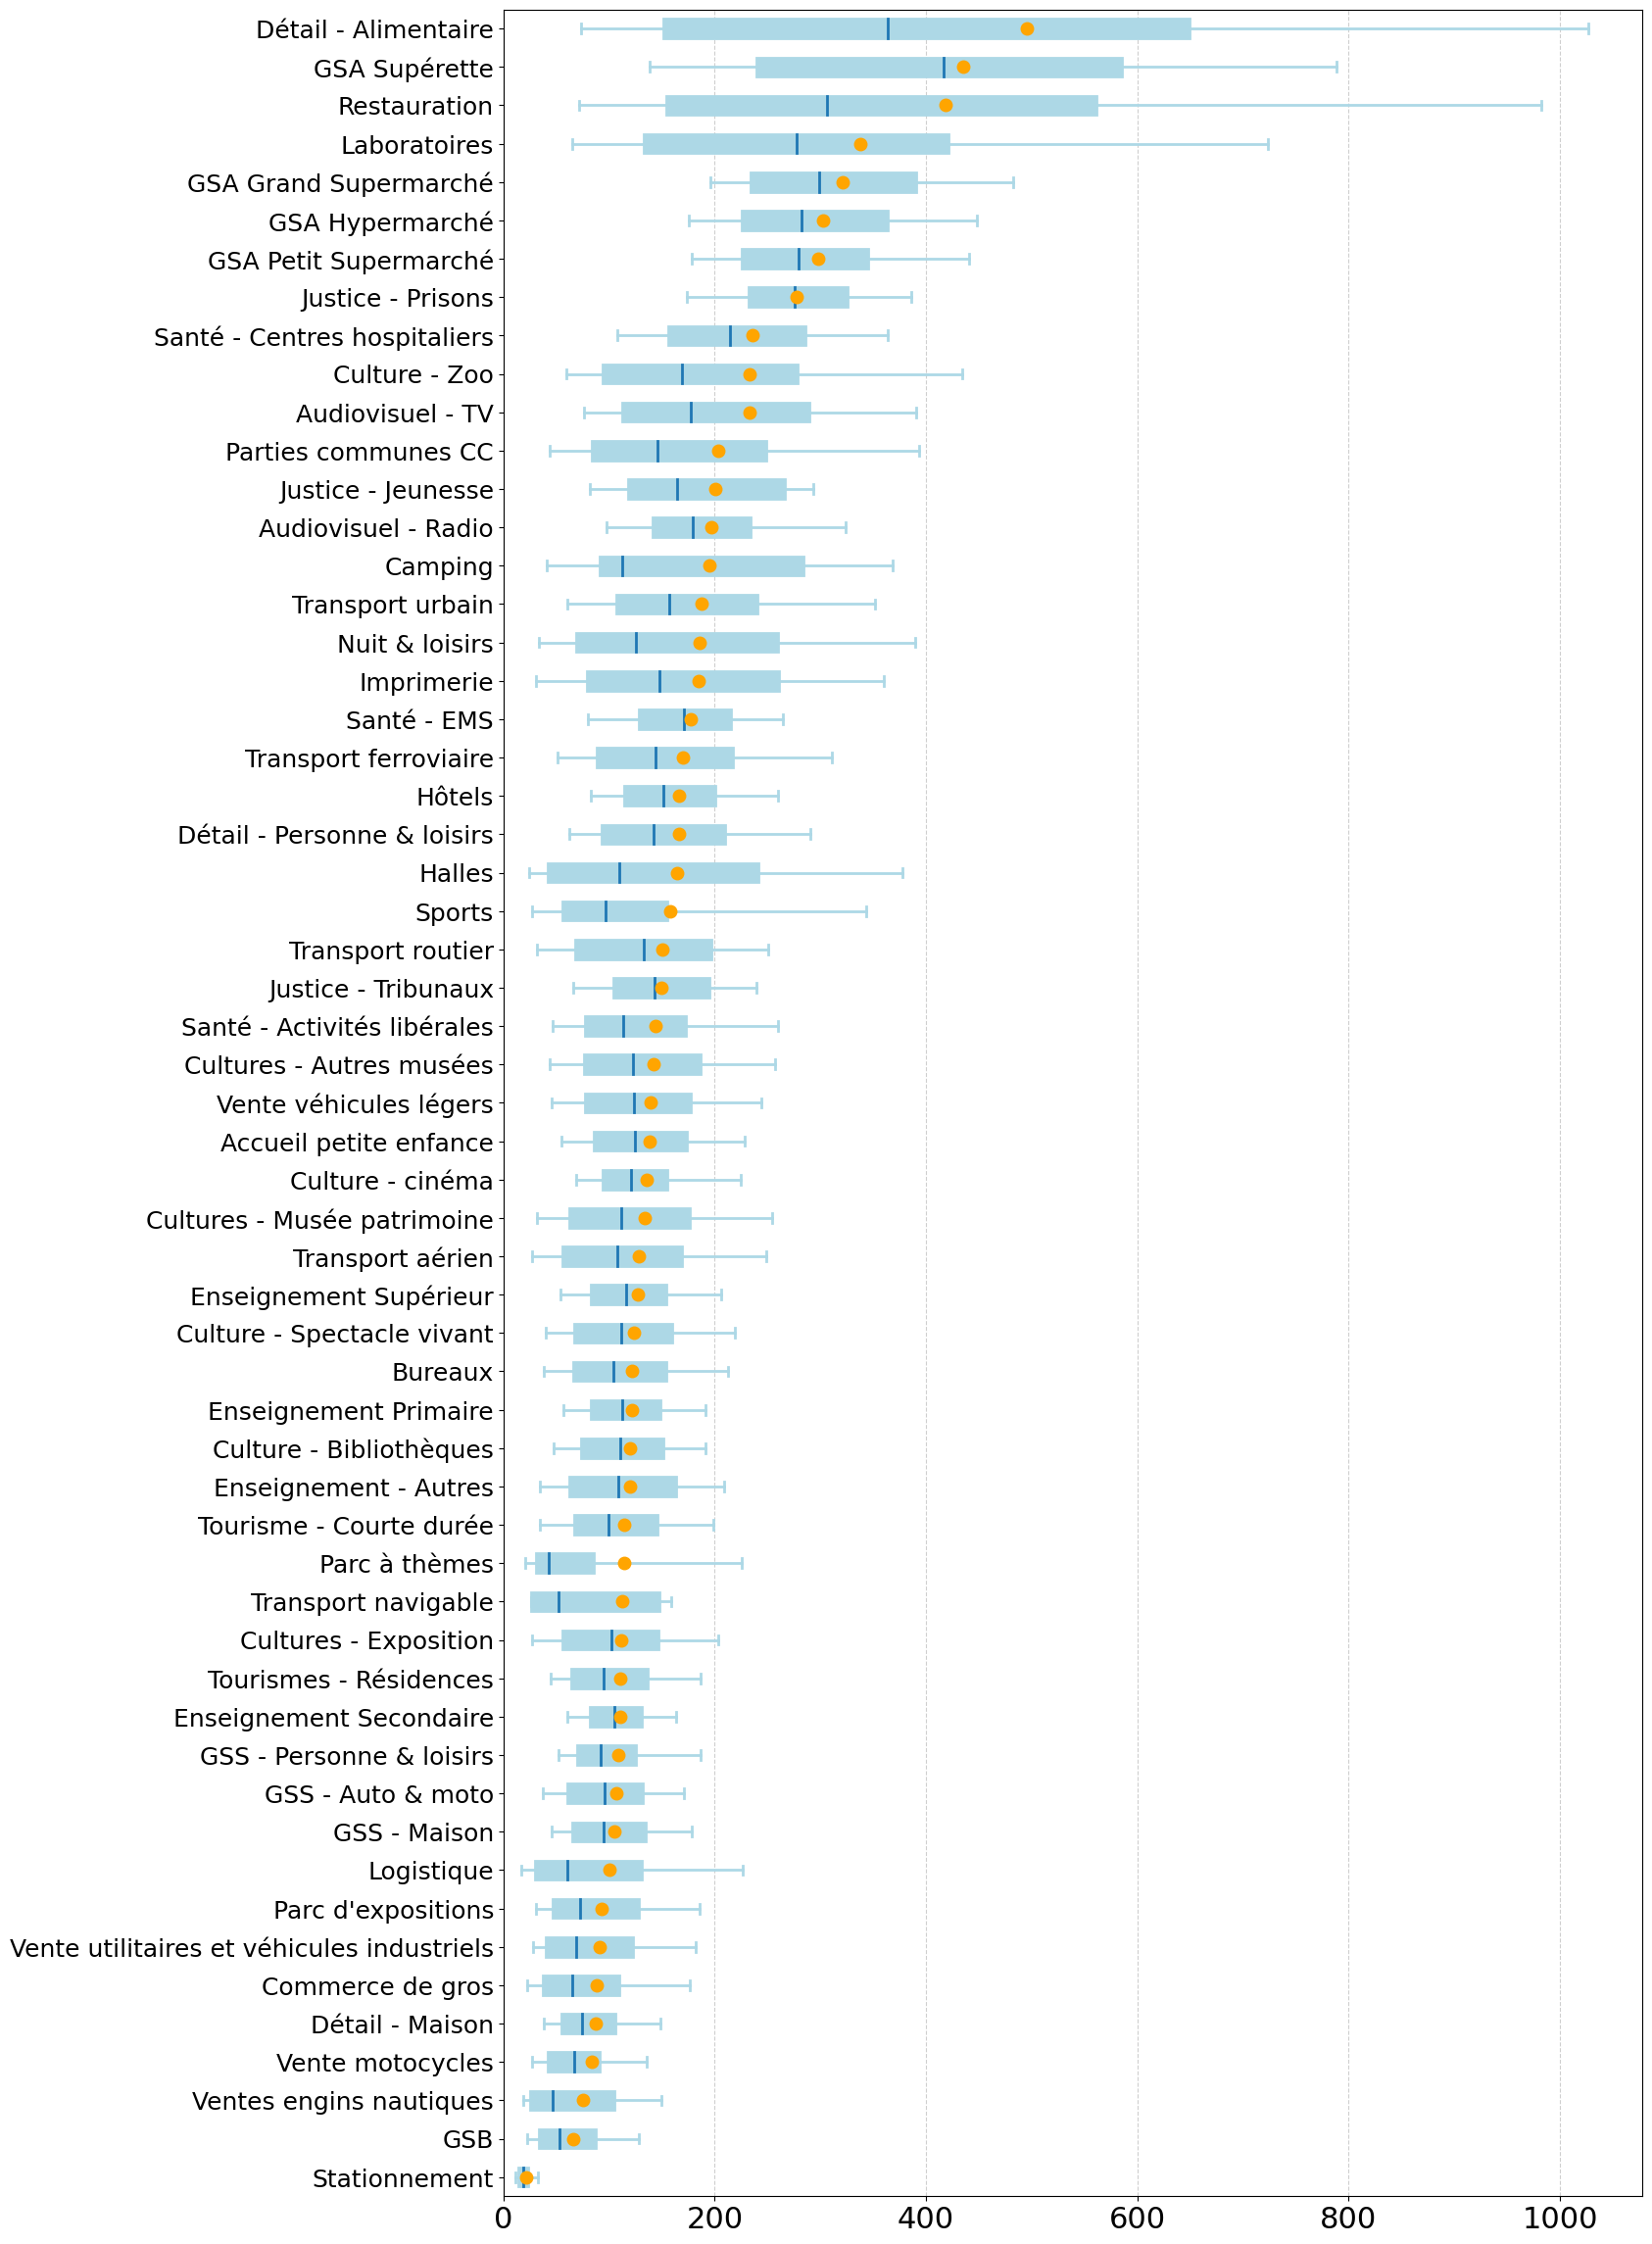

In [273]:
# Plot 2 (autres CAP) 
fig_height = len(distrib_cap_low_nrg)/len(distrib_cap)*30
plt.figure(figsize=(15, fig_height))
boxprops = dict(edgecolor='lightblue',facecolor='lightblue', alpha=1, linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2, color='lightblue')
capprops = dict(linestyle='-', linewidth=2, color='lightblue')
medianprops = dict(color='tab:blue', linewidth=2)
meanprops = dict(marker='o', markeredgecolor='orange', markerfacecolor='orange', markersize=9)
whiskers = (100-max_data_to_plot, max_data_to_plot)
plt.boxplot(distrib_cap_low_nrg.values(), labels=distrib_cap_low_nrg.keys(), sym='', showmeans=True, whis=(10,90), vert=False, boxprops=boxprops, patch_artist=True,
            capprops=capprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops)
plt.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlim(left=0, right=max(nrg.quantile(0.90) for nrg in distrib_cap_low_nrg.values())*1.05)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=18)
plt.show()

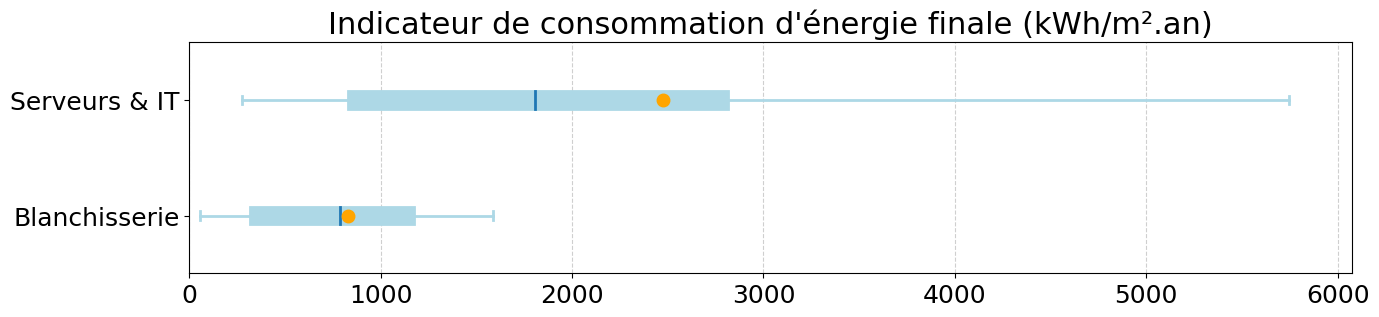

In [274]:
###################################################### META-CAP ####################################################
threshold_plot = 1100 # Si la box dépasse cette limite, on plot séparément pour ne pas écraser le graphe
max_data_to_plot = 90 # Extension max de la box à droite en % de la distribution (ex : 90% --> on trace jusqu'au 9ème décile, i.e. 80% des données représentées)

# On sépare les données en 2 : lorsque le n_ème quantile (droite de la barre) est au-dessus d'un certain seuil, on trace la CAP à part
distrib_meta_cap_high_nrg = {}
distrib_meta_cap_low_nrg = {}
for cap, nrg in distrib_meta_cap.items():
    box_right_lim = nrg.quantile(max_data_to_plot/100)
    if box_right_lim > threshold_plot:
        distrib_meta_cap_high_nrg[cap] = nrg
    else:
        distrib_meta_cap_low_nrg[cap] = nrg

# Plot 1 (CAP énergivores)
fig_height = len(distrib_meta_cap_high_nrg)/len(distrib_meta_cap)*30+2
plt.figure(figsize=(15, 3))
boxprops = dict(edgecolor='lightblue',facecolor='lightblue', alpha=1, linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2, color='lightblue')
capprops = dict(linestyle='-', linewidth=2, color='lightblue')
medianprops = dict(color='tab:blue', linewidth=2)
meanprops = dict(marker='o', markeredgecolor='orange', markerfacecolor='orange', markersize=9)
whiskers = (100-max_data_to_plot, max_data_to_plot)
plt.boxplot(distrib_meta_cap_high_nrg.values(), labels=distrib_meta_cap_high_nrg.keys(), sym='', showmeans=True, whis=whiskers, vert=False, boxprops=boxprops, patch_artist=True,
            capprops=capprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops)
plt.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.title("Indicateur de consommation d'énergie finale (kWh/m².an)", fontsize=22)
plt.xlim(left=0, right=max(nrg.quantile(max_data_to_plot/100) for nrg in distrib_meta_cap_high_nrg.values())*1.05)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.show()

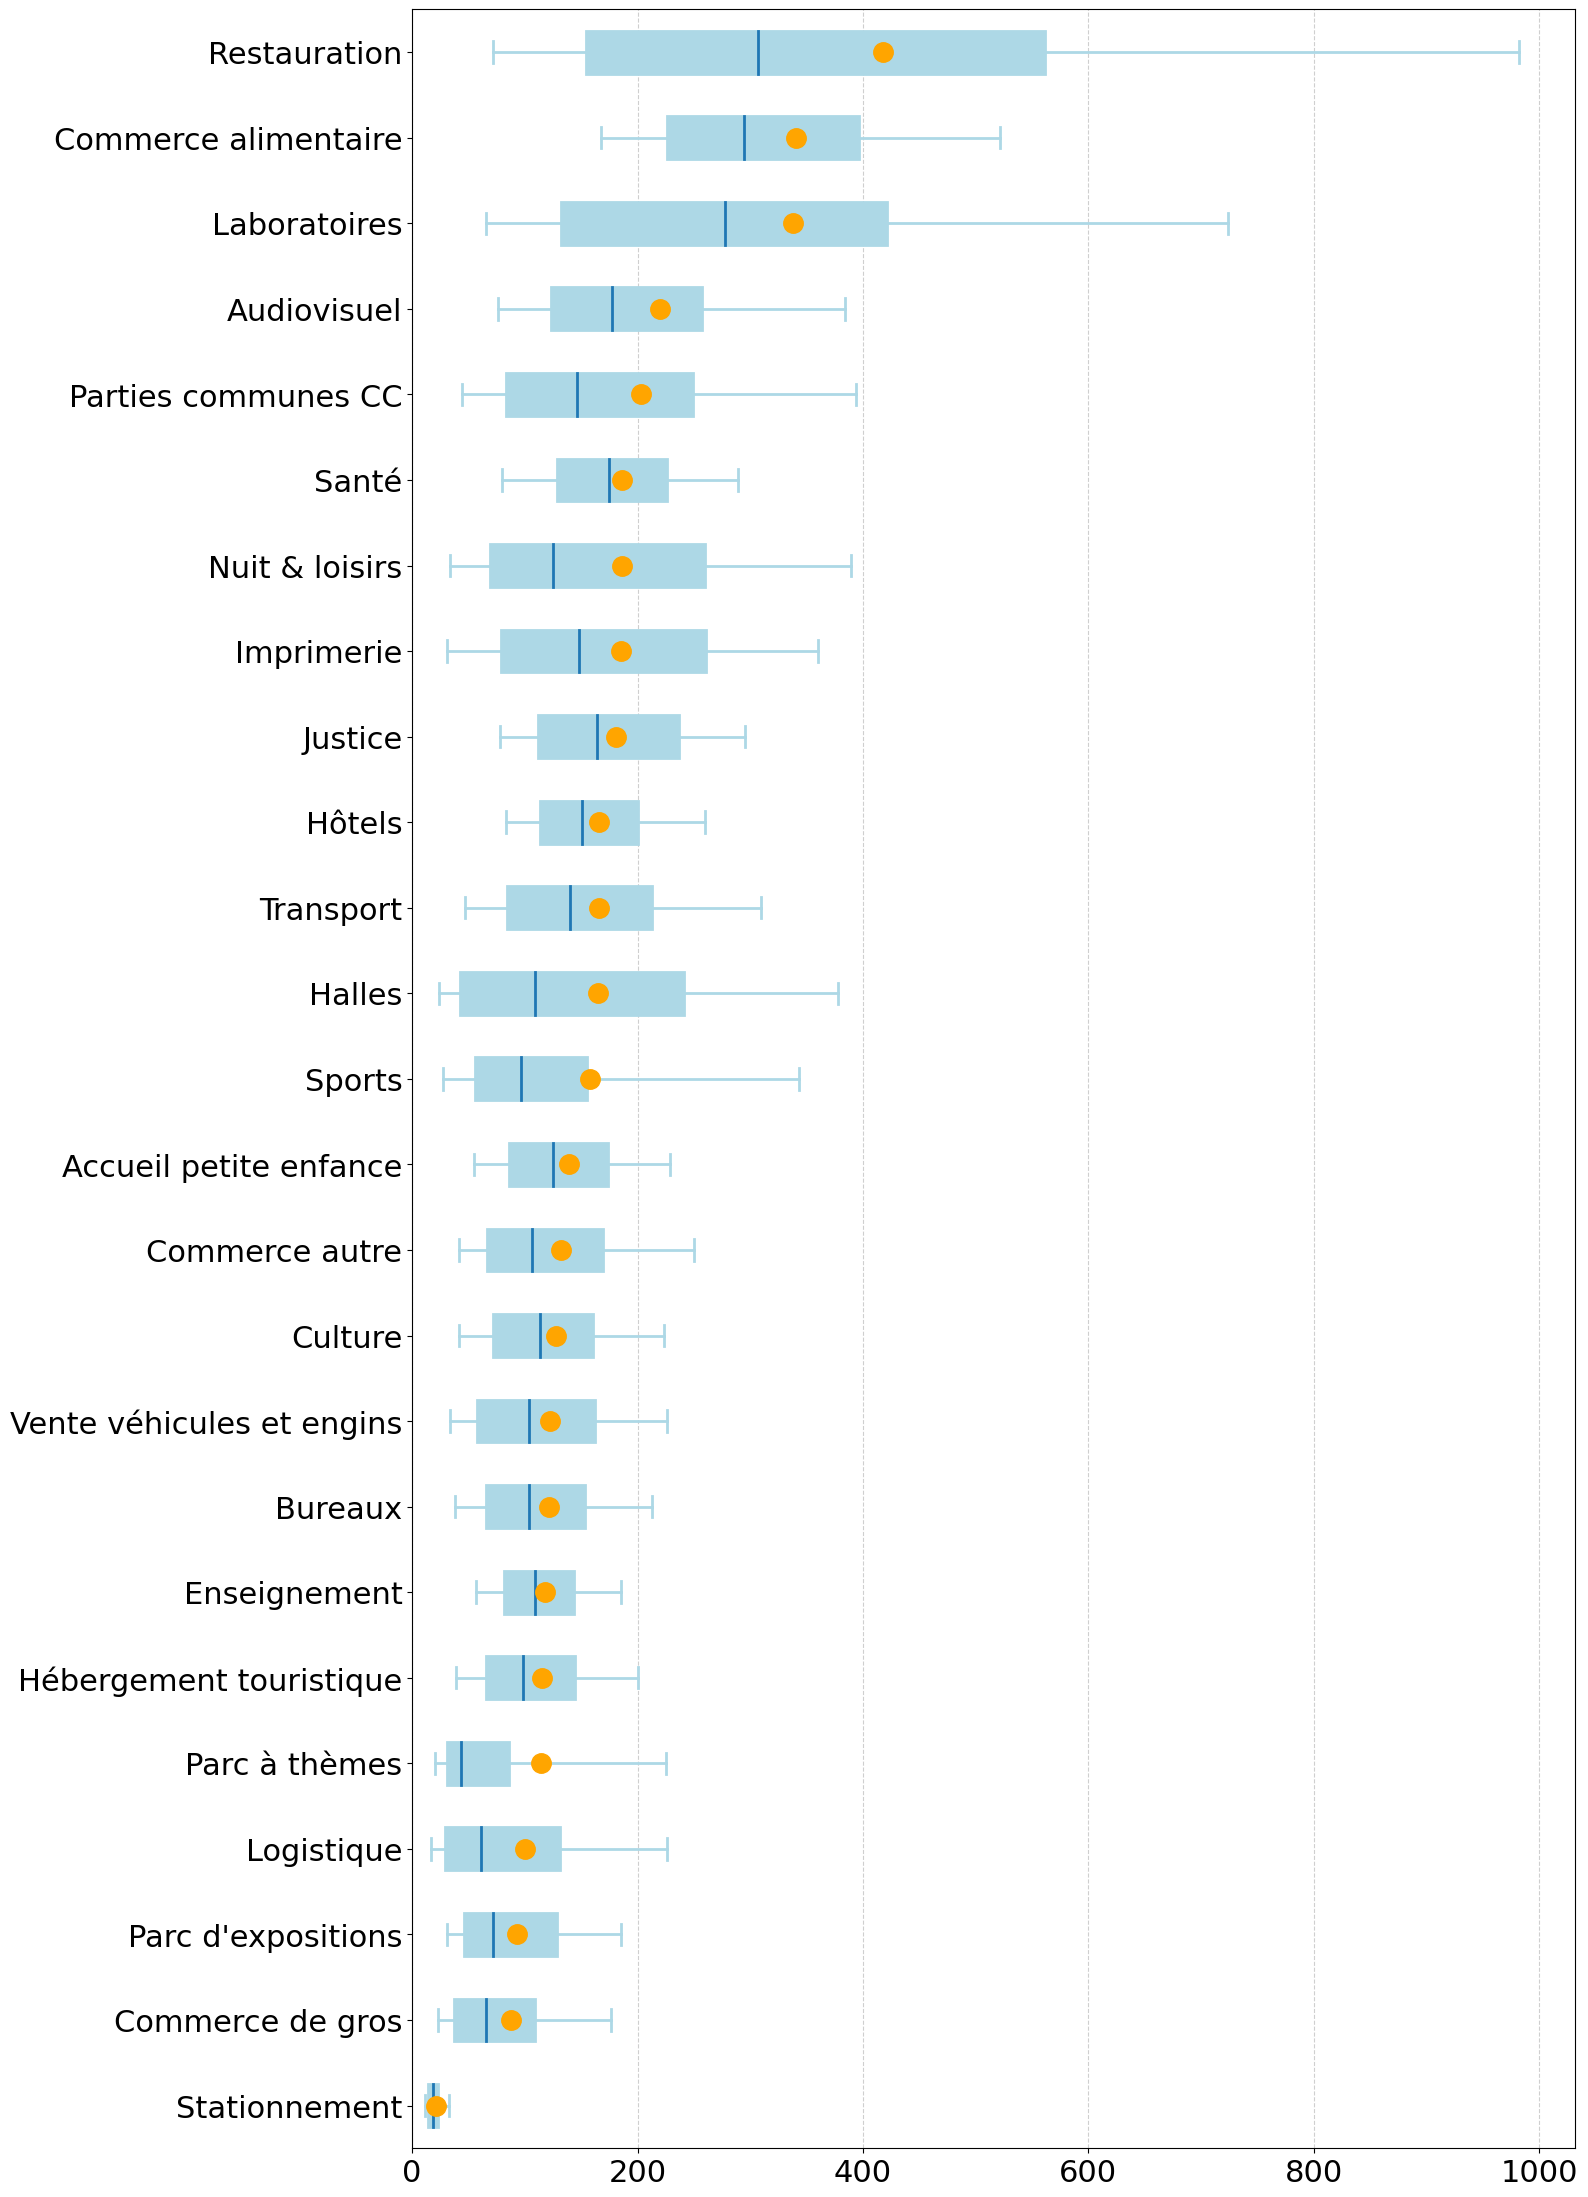

In [275]:
# Plot 2 (autres meta-CAP) 
fig_height = len(distrib_meta_cap_low_nrg)/len(distrib_meta_cap)*30
plt.figure(figsize=(15, fig_height))
boxprops = dict(edgecolor='lightblue',facecolor='lightblue', alpha=1, linewidth=2)
whiskerprops = dict(linestyle='-', linewidth=2, color='lightblue')
capprops = dict(linestyle='-', linewidth=2, color='lightblue')
medianprops = dict(color='tab:blue', linewidth=2)
meanprops = dict(marker='o', markeredgecolor='orange', markerfacecolor='orange', markersize=14)
whiskers = (100-max_data_to_plot, max_data_to_plot)
plt.boxplot(distrib_meta_cap_low_nrg.values(), labels=distrib_meta_cap_low_nrg.keys(), sym='', showmeans=True, whis=whiskers, vert=False, boxprops=boxprops, patch_artist=True,
            capprops=capprops, whiskerprops=whiskerprops, medianprops=medianprops, meanprops=meanprops)
plt.grid(True, axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlim(left=0, right=max(nrg.quantile(max_data_to_plot/100) for nrg in distrib_meta_cap_low_nrg.values())*1.05)
plt.tick_params(axis='x', labelsize=22)
plt.tick_params(axis='y', labelsize=22)
plt.show()

#### <font color=pink>Consommation moyenne (évolution annuelle)</font>

In [276]:
# On calcule 2 dict : 1 avec les distribution de conso surfacique par CAP et 1 par meta-CAP 
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

# Sélection du périmètre (scores --> années de conso --> déclarations validées)
years = ['2020', '2021', '2022']
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Liste des code CAP triés comme dans le fichier Excel
list_code_cap = ('CAP' + df_extract['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list()

# Distributions des conso par meta-CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

distrib_meta_cap = {}
for meta_cap in meta_cap_all:
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]

    distrib_1_meta_cap_1Y = {}
    for year in df_cap["Annee Consommation"].value_counts().sort_index().index.to_list():
        df_cap_1Y = df_cap.loc[df_cap["Annee Consommation"] == year]
        distrib_1_meta_cap_1Y[year] = df_cap_1Y["Ratio (kWh PCI / m2) - Corrigé"].mean()
    
    distrib_meta_cap[meta_cap] = distrib_1_meta_cap_1Y
    
distrib_meta_cap = pd.DataFrame(distrib_meta_cap).T

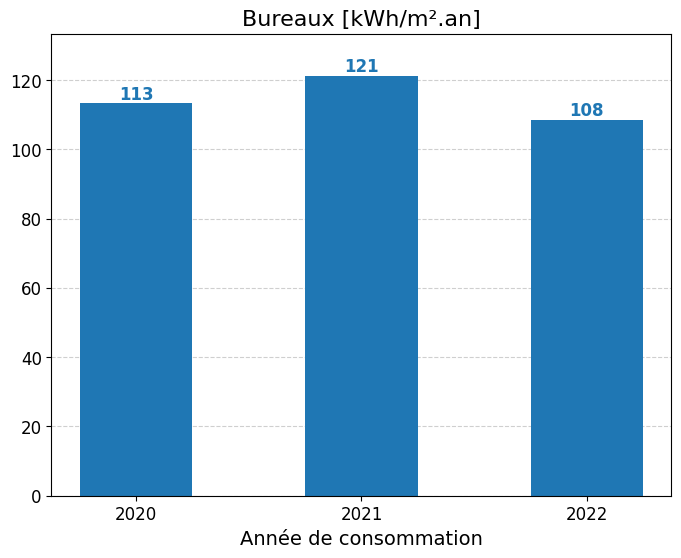

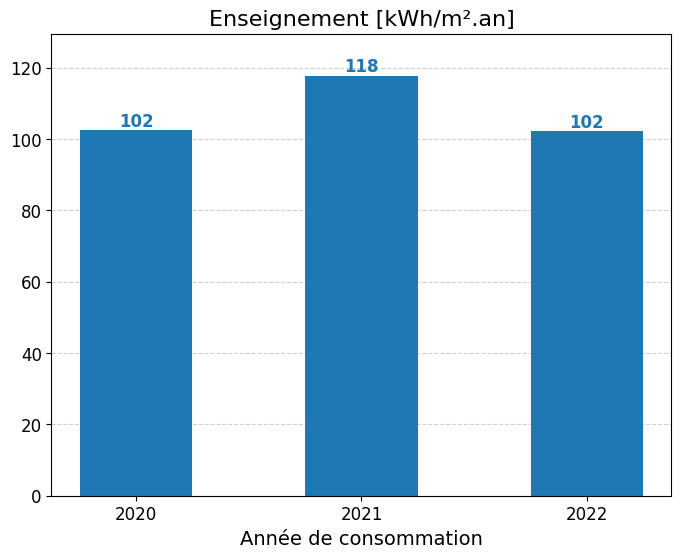

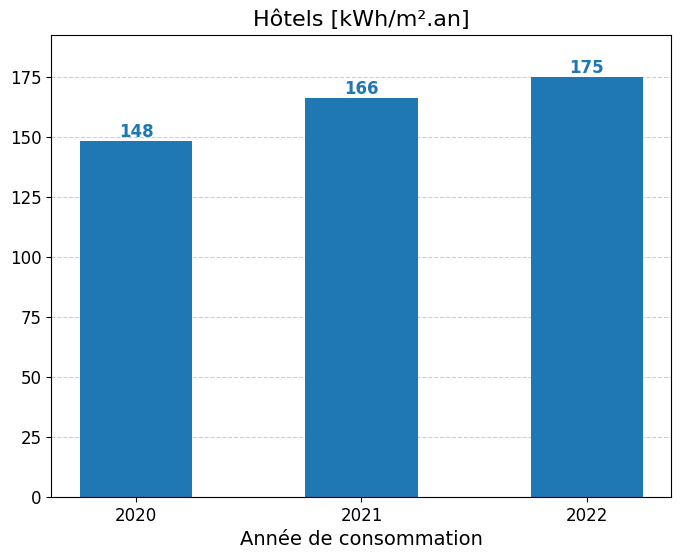

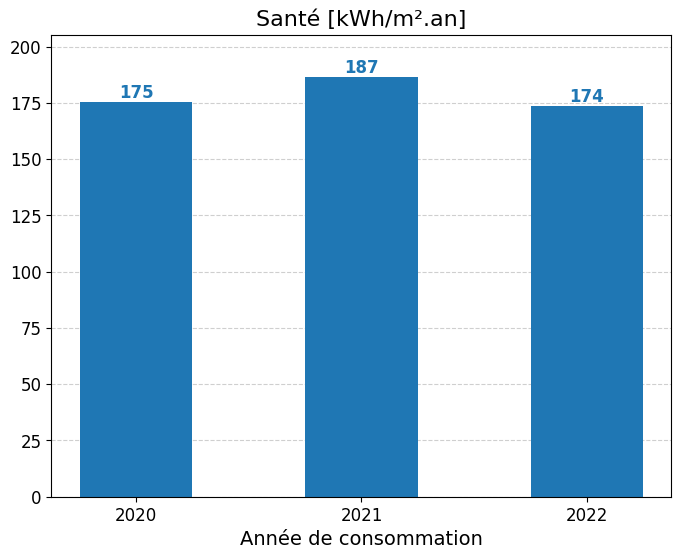

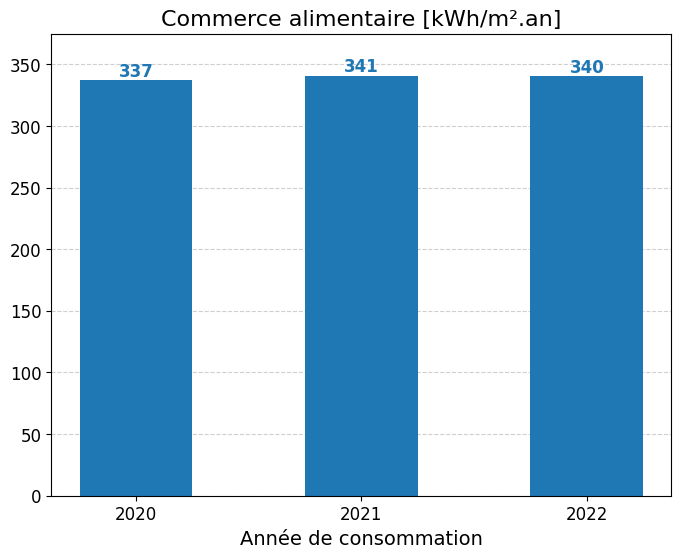

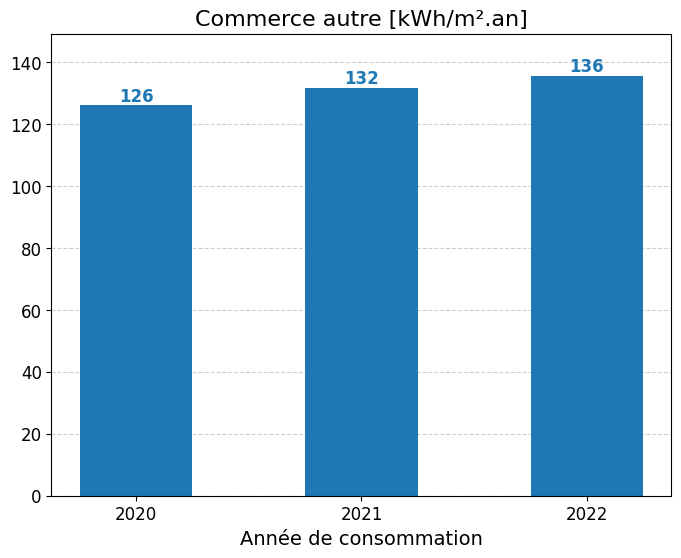

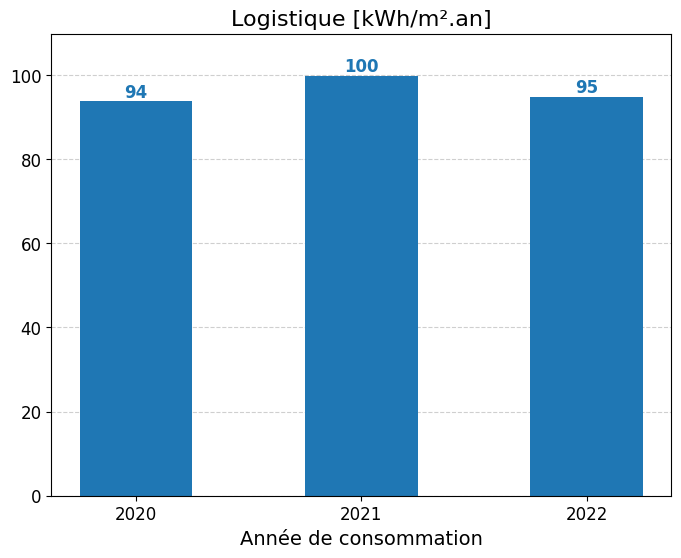

In [277]:
# Plotting
for meta_cap in ['Bureaux', 'Enseignement', 'Hôtels', 'Santé', 'Commerce alimentaire', 'Commerce autre', 'Logistique']:
    fig, ax = plt.subplots(figsize=(8, 6))
    width = 0.5  # Adjust the width of the bars as needed
    bars = ax.bar(distrib_meta_cap.loc[meta_cap].index, distrib_meta_cap.loc[meta_cap], width=width, zorder=2)
    ax.set_xlabel('Année de consommation', fontsize=14)
    ax.set_title("{} [kWh/m².an]".format(meta_cap), fontsize=16)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(round(bar.get_height(),0)), 
                ha='center', va='bottom', fontsize=12, zorder=3, color='tab:blue', weight='bold')
    ax.set_ylim(0, distrib_meta_cap.loc[meta_cap].max()*1.1)
    fig_name = "evolution_ef_{}.png".format(unicodedata.normalize('NFKD', meta_cap).encode('ASCII', 'ignore').decode('ASCII').lower())
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

#### <font color=pink>	Comparaison avec des benchmarks existant
</font>

In [93]:
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

years = ['2020', '2021', '2022']
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

cities = ['LA DEFENSE', 'PUTEAUX']#'COURBEVOIE']

df_extract = df_extract.loc[df_extract['Code CAP-M'].isin(meta_cap_table["Bureaux"])].loc[df_extract["Departement"] == '75']

#df_extract = df_extract.loc[df_extract['Code CAP-M'].isin(meta_cap_table["Bureaux"])].loc[df_extract["Commune"].isin(cities)]

df_extract['Ratio (kWh PCI / m2) - Corrigé'].mean()

126.71646775312652

In [278]:
OID = {"Bureaux": 134,
       "Bureaux Paris": 165,
       "Hôtels": 167,
       "Santé": 195,
       "Hôpitaux": 233,
       "EHPAD": 177,
       "EMS": 155,
       "Commerce": 140,
       "Logistique": None}

Deepki = {"Bureaux": 134,
          "Hôtels": 198,
          "Santé": 208,
          "Hôpitaux": None,
          "EHPAD": None,
          "EMS": None,
          "Commerce": 224,
          "Logistique": 100}

# Calcul indicateurs OPERAT (annuels et triennaux)
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

years = ['2020', '2021', '2022']
year = '2022' # année pour calcul indicateurs annuels
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

meta_cap_table = {}
meta_cap_table["Bureaux"] = meta_cap_all["Bureaux"]
meta_cap_table['Bureaux Paris'] = meta_cap_all["Bureaux"]
meta_cap_table["Hôtels"] = meta_cap_all["Hôtels"]
meta_cap_table["Santé"] = meta_cap_all["Santé"]
meta_cap_table["Hôpitaux"] = ['CAP2001']
meta_cap_table["Commerce"] = meta_cap_all["Commerce alimentaire"] + meta_cap_all['Commerce autre'] + meta_cap_all['Parties communes CC'] 
meta_cap_table["EHPAD"] = ['CAP2002']
meta_cap_table["EMS"] = ['CAP2002']
meta_cap_table["Logistique"] = meta_cap_all["Logistique"]

OPERAT_1Y = {}
OPERAT_3Y = {}
for meta_cap in meta_cap_table:

    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(meta_cap_table[meta_cap])]

    if meta_cap == 'Bureaux Paris':
        n_bureaux = len(df_cap)
        df_cap = df_cap.loc[df_cap["Departement"].isin(['75'])]#, '77', '78', '91', '92', '93', '94', '95'])]
        n_bureaux_paris = len(df_cap)
        
        print("Part des bureaux à Paris: {}%".format(int(round(n_bureaux_paris/n_bureaux*100, 0))))
    
    
    OPERAT_1Y[meta_cap] = df_cap.loc[df_cap["Annee Consommation"] == year]["Ratio (kWh PCI / m2) - Corrigé"].mean()
    OPERAT_3Y[meta_cap] = df_cap["Ratio (kWh PCI / m2) - Corrigé"].mean()

data = pd.concat([pd.Series(OPERAT_3Y, name = "OPERAT 3A"), 
                  pd.Series(OPERAT_1Y, name = "OPERAT {}".format(year)), 
                  pd.Series(OID, name = "OID"), 
                  pd.Series(Deepki, name = "Deepki")], axis=1).round(0)
data

Part des bureaux à Paris: 13%


OPERAT 3A  OPERAT 2022    OID  Deepki
Bureaux            115.0        108.0  134.0   134.0
Bureaux Paris      134.0        126.0  165.0     NaN
Hôtels             162.0        175.0  167.0   198.0
Santé              179.0        174.0  195.0   208.0
Hôpitaux           229.0        222.0  233.0     NaN
Commerce           192.0        193.0  140.0   224.0
EHPAD              169.0        162.0  177.0     NaN
EMS                169.0        162.0  155.0     NaN
Logistique          96.0         95.0    NaN   100.0

### <font color=greenyellow>Indicateurs de consommation d'énergie finale par localisation</font>

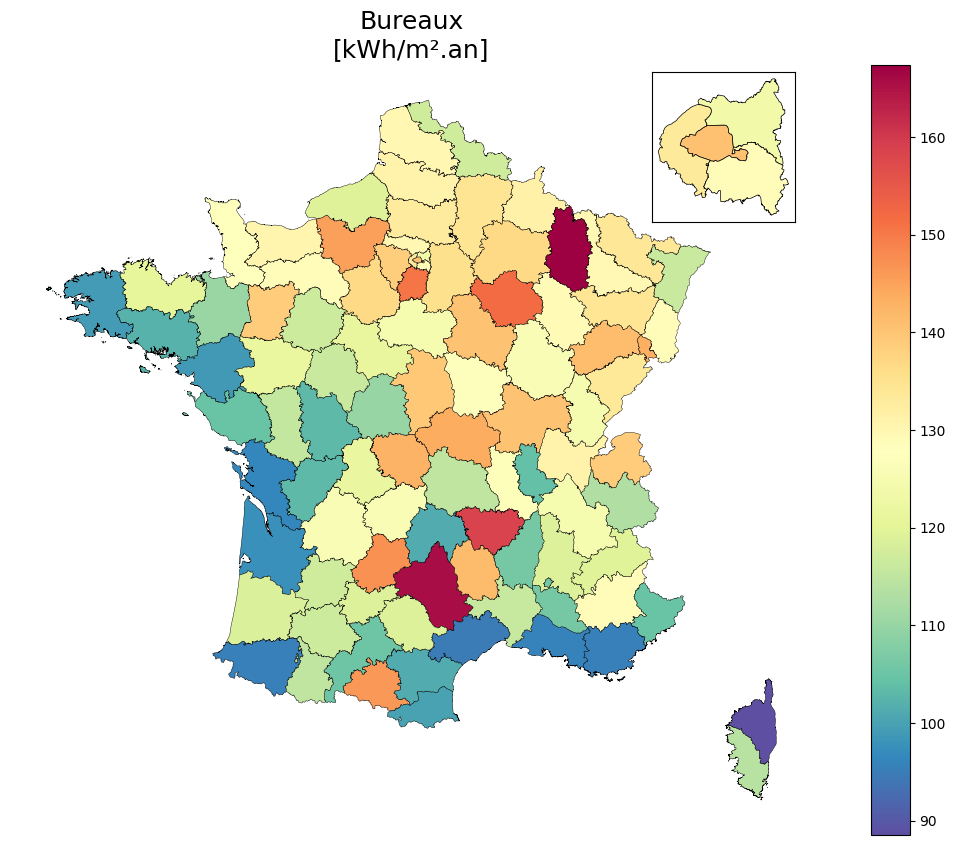

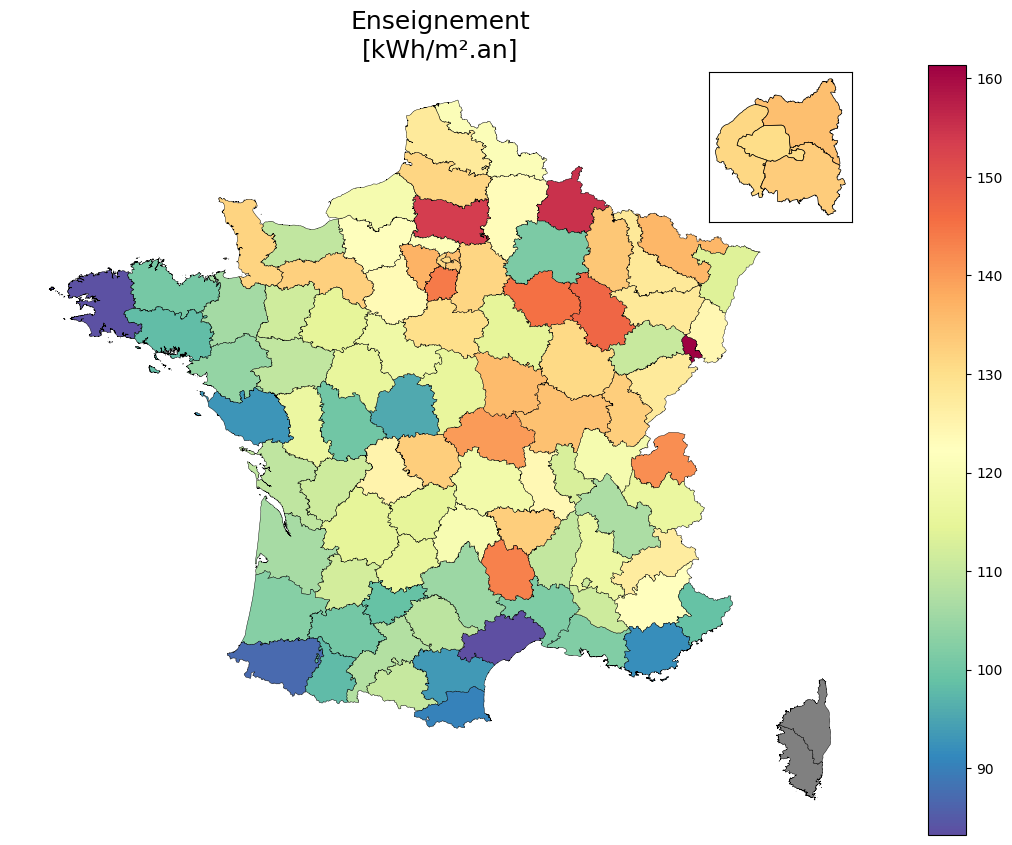

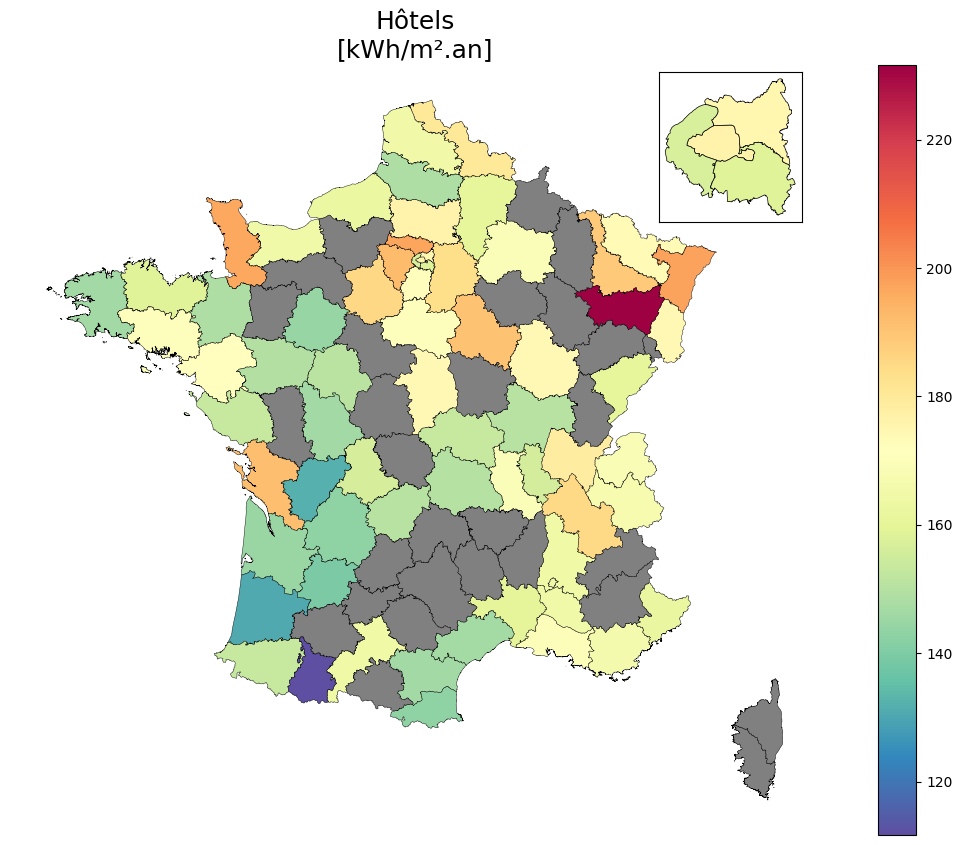

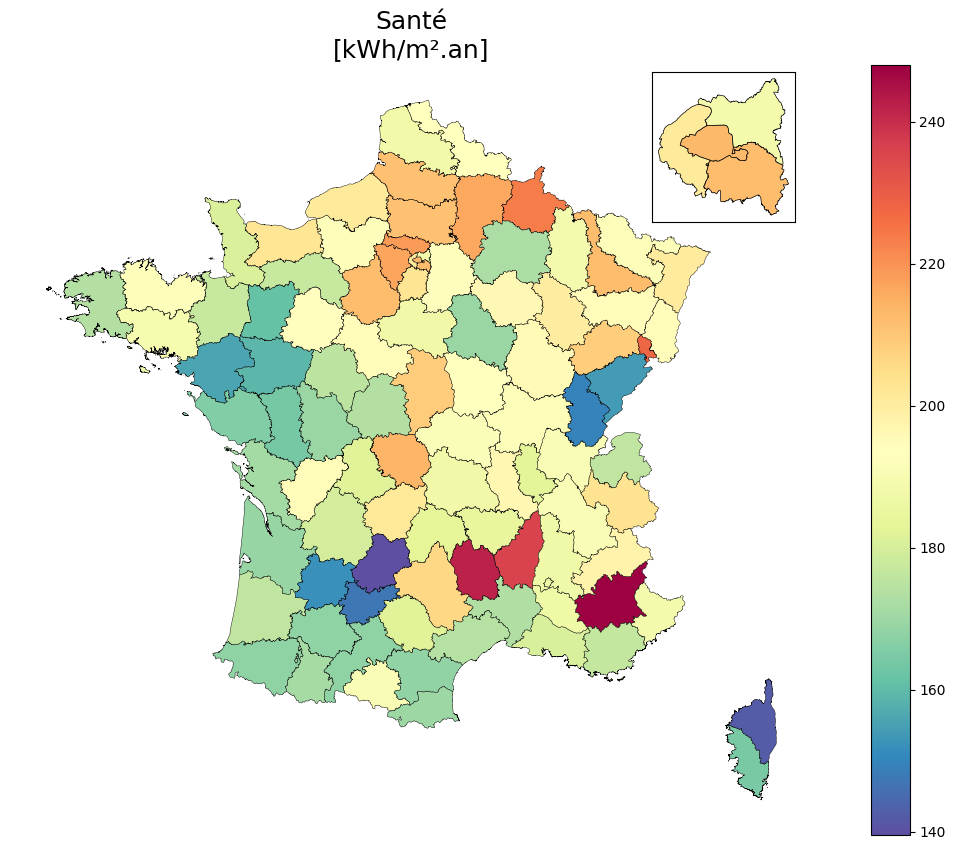

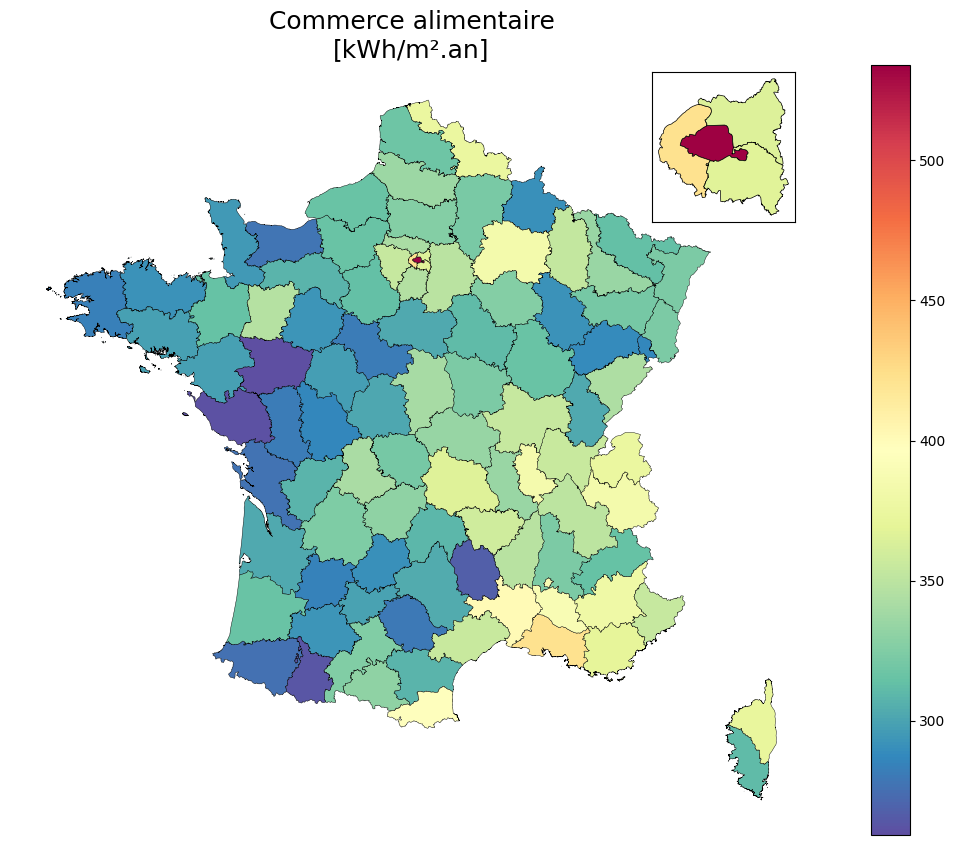

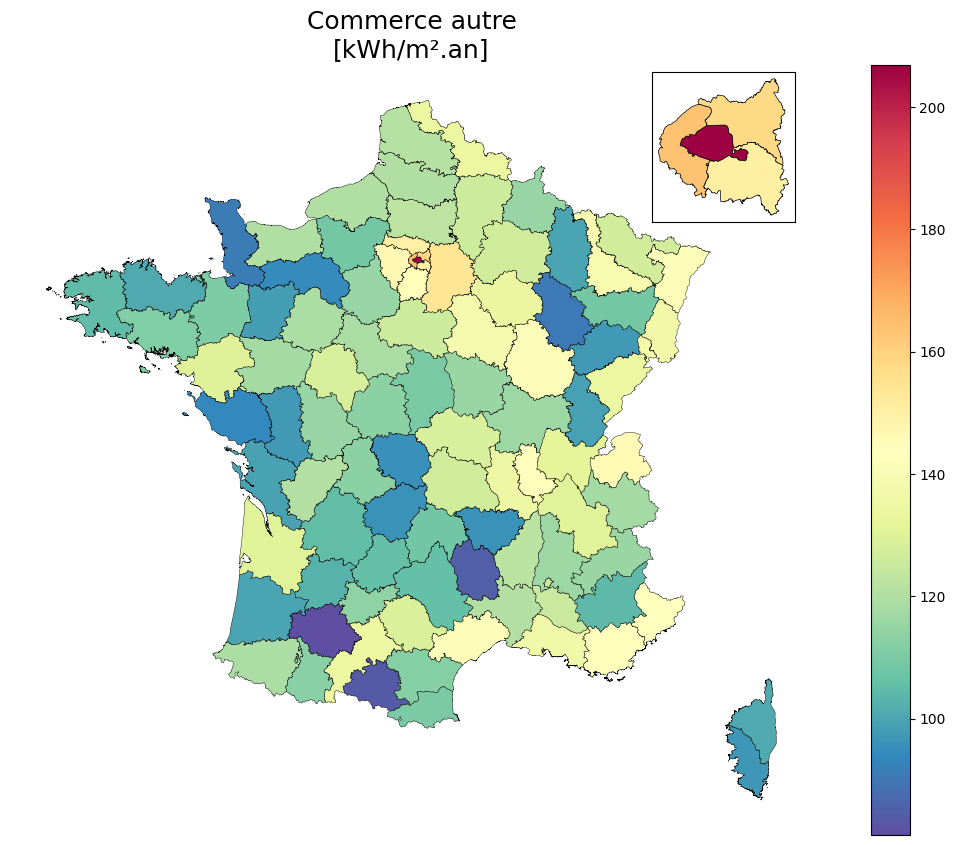

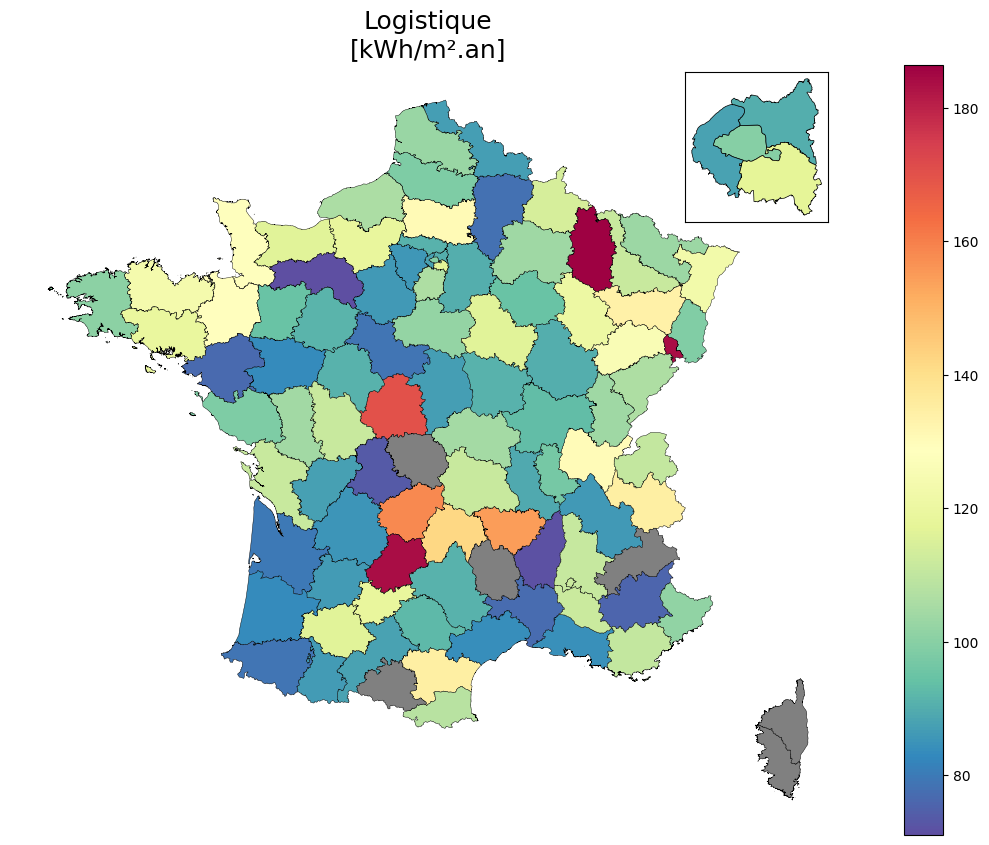

In [281]:
# Distribution géographique de la consommation totale en EF PCI
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 
n_line_min = 10 # Nb min d'EFA dans un département pour calculer une conso moyenne
remove_DROM_COM = True
meta_cap_to_plot = ['Bureaux', 'Enseignement', 'Hôtels', 'Santé', 'Commerce alimentaire', 'Commerce autre', 'Logistique'] # meta_cap à ploter


# Sélection du périmètre (scores --> années de conso)
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Regroupement en meta-CAP
list_code_cap = ('CAP' + df_extract['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list() # Liste des code CAP triés comme dans le fichier Excel
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

# Pour chaque meta-CAP, on applique un filtre (2 sigma) sur les conso surfaciques
# Ensuite on filtre sur les départements comptant au minimum n lignes (défini plus haut)
# Puis on calcule la conso moyenne par département sur les lignes restantes (NaN pour les départements avec < n lignes)
# Enfin, on ajoute à la df (1 ligne = 1 depart et 1 col = 1 meta-cap)
distrib = pd.DataFrame(df["Departement"].value_counts().sort_index().index.to_list(), columns=['Departement'])
for meta_cap in meta_cap_all:
    
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]
    
    depart_count = df_cap["Departement"].value_counts()
    df_cap = df_cap.loc[df_cap["Departement"].isin(depart_count[depart_count >= n_line_min].index)]
    
    depart_EF_mean = df_cap.groupby('Departement')["Ratio (kWh PCI / m2) - Corrigé"].mean().reset_index().rename(columns={'Ratio (kWh PCI / m2) - Corrigé':meta_cap})

    distrib = distrib.merge(depart_EF_mean, how='outer',on='Departement')  

idx = distrib.loc[distrib['Departement'].isin([str(x) for x in range(1, 10)])].index
distrib.loc[idx, 'Departement'] = '0' + distrib['Departement'].loc[idx]

# Load the French départements shapefile
# You can download the shapefile from https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/
# Save the shapefile in the same directory as your script/notebook
shapefile_path = 'departements-20180101-shp/departements-20180101.shp'
gdf = gpd.read_file(shapefile_path)
gdf.loc[gdf['code_insee'].isin(['69D', '69M']), 'code_insee'] = '69' # Merge '69D' and '69M' into '69'
gdf = gdf.dissolve(by='code_insee', aggfunc='sum').reset_index()
gdf = gdf.merge(distrib, left_on='code_insee', right_on='Departement', how='left')

if remove_DROM_COM == True:
    depart_OPERAT_all = distrib['Departement'].value_counts().sort_index().index.to_list()
    DROM_COM =  ['972','973','974','975','976','977','978','987','971']
    depart_metropole = [x for x in depart_OPERAT_all if x not in DROM_COM]
    gdf = gdf.loc[gdf['Departement'].isin(depart_metropole)]

else:
    # On ajuste la position des DROM-COM pour les ramener près de la métropole
    overseas_territories_adjustments = {
        '971': (55, 34),  # Guadeloupe
        '972': (54, 34.5),  # Martinique
        '974': (-62, 69),  # Réunion
        '976': (-52, 59.5),  # Mayotte
        '973': (47, 40),  # Guyane
    }
    for code, (lon_adjust, lat_adjust) in overseas_territories_adjustments.items():
        gdf.loc[gdf['code_insee'] == code, 'geometry'] = gdf.loc[gdf['code_insee'] == code, 'geometry'].translate(lon_adjust, lat_adjust)

for meta_cap in meta_cap_to_plot:

    # Plot the map with a color scale based on total building area
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cmap = 'Spectral_r'
    color_missing_dep = 'gray'
    plot = gdf.plot(column=meta_cap, cmap=cmap, linewidth=0.3, ax=ax, edgecolor='black', legend=True, missing_kwds={'color': color_missing_dep})
    plt.title("{}\n[kWh/m².an]".format(meta_cap), fontsize=18)
    ax.set_axis_off()
    # Create a normalization for the color scale
    norm = Normalize(vmin=gdf[meta_cap].min(), vmax=gdf[meta_cap].max())
    # Add a zoomed inset axes for Île-de-France with the specified colormap, color for NaN values, and using the same normalization
    ax_inset = inset_axes(ax, width="30%", height="30%", bbox_to_anchor=(610, 380, 500, 500))
    ile_de_france = gdf[gdf['code_insee'].isin(['75', '92', '93', '94'])]  # Île-de-France départements
    ile_de_france_plot = ile_de_france.plot(ax=ax_inset, column=meta_cap, cmap=cmap, edgecolor='black', linewidth=0.5, norm=norm, missing_kwds={'color': color_missing_dep})
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    fig_name = "map_ef_{}.png".format(unicodedata.normalize('NFKD', meta_cap).encode('ASCII', 'ignore').decode('ASCII').lower())
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [283]:
# Périmètre
df_extract = df.loc[df["P&S Score"] >= 7].loc[df["E Score"] >= 3].loc[df["Annee Consommation"] == '2021']
#surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
#df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Distribution par meta-CAP-M
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

distrib_meta_cap = {}
for meta_cap in meta_cap_all:
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]
    n_efa = len(df_cap)
    surf = df_cap['Surface totale brute (m²)'].sum()/1e6
    EF = df_cap['Consommation totale (kWh PCI)'].sum()/1e9
    distrib_meta_cap[meta_cap] = [n_efa, surf, EF]
    
distrib_meta_cap = pd.DataFrame(distrib_meta_cap, index=["Nb EFA", "Surface totale brute (million m²)", "Energie finale (TWh PCI)"]).T

part_surf = round(distrib_meta_cap.loc[distrib_meta_cap.index.isin(meta_cap_to_plot)]["Surface totale brute (million m²)"].sum()/distrib_meta_cap["Surface totale brute (million m²)"].sum()*100,1)
part_nrg = round(distrib_meta_cap.loc[distrib_meta_cap.index.isin(meta_cap_to_plot)]["Energie finale (TWh PCI)"].sum()/distrib_meta_cap["Energie finale (TWh PCI)"].sum()*100,1)

print(part_surf, part_nrg)

80.7 79.6


## <font color=yellow>Annexe 3 : Composition des données</font>

In [256]:
# Périmètre
threshold_CAP = 90
years = ['2020', '2021', '2022']
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Nb données par code CAP-M par année
EFA_count = pd.DataFrame()
for year in years:
    df_1Y = df_extract.loc[df_extract['Annee Consommation'] == year]
    data = df_1Y['Code CAP-M'].value_counts().rename(year)
    EFA_count = pd.concat([EFA_count, data], axis=1)

# Conversion code --> catégorie abrégée
CAP_name_mapping = CAP.loc[CAP["Type"] == "Catégorie"][["Code", "Catégories abrégées"]].set_index('Code')['Catégories abrégées'].to_dict()
EFA_count_CAP = EFA_count.rename(index=CAP_name_mapping)
EFA_count_CAP = EFA_count_CAP.sort_index()
EFA_count_CAP.loc["TOTAL",:] = EFA_count_CAP.sum()
EFA_count_CAP = EFA_count_CAP.astype('int')

# Calcul par méta CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

EFA_count_meta_CAP = pd.DataFrame(index = meta_cap_all.keys(), columns = EFA_count.columns)
for meta_cap in meta_cap_all:
    EFA_count_meta_CAP.loc[meta_cap, :] = EFA_count.loc[meta_cap_all[meta_cap]].sum()
EFA_count_meta_CAP = EFA_count_meta_CAP.sort_index()
EFA_count_meta_CAP.loc["TOTAL",:] = EFA_count_meta_CAP.sum()
EFA_count_meta_CAP = EFA_count_meta_CAP.astype('int')

In [257]:
EFA_count_CAP

2020    2021    2022
Accueil petite enfance                        1695    1695    1168
Audiovisuel - Radio                             78      78      67
Audiovisuel - TV                               133     134     103
Blanchisserie                                  283     281     179
Bureaux                                      36973   37027   26934
Camping                                         24      23      13
Commerce de gros                              2952    2973    1830
Culture - Bibliothèques                        986     981     641
Culture - Spectacle vivant                    1829    1810    1153
Culture - Zoo                                   82      79      41
Culture - cinéma                               364     367     239
Cultures - Autres musées                       223     222     161
Cultures - Exposition                          252     251     153
Cultures - Musée patrimoine                    421     419     278
Détail - Alimentaire                          1301    1317     949
Détail - Maison                               2921    2928    2520
Détail - Personne & loisirs                  12435   12482    9787
Enseignement - Autres                          887     890     679
Enseignement Primaire                         9772    9685    6048
Enseignement Secondaire                       6410    6298    4353
Enseignement Supérieur                        1400    1370    1015
GSA Grand Supermarché                         4152    3955    3368
GSA Hypermarché                               2316    2263    1818
GSA Petit Supermarché                         1306    1311     526
GSA Supérette                                  208     206     147
GSB                                           3221    3152    2763
GSS - Auto & moto                              657     655     372
GSS - Maison                                  1714    1703    1108
GSS - Personne & loisirs                      1176    1153     718
Halles                                         138     141      60
Hôtels                                        3143    3159    2519
Imprimerie                                     142     146     107
Justice - Jeunesse                              25      27      24
Justice - Prisons                               52      50      27
Justice - Tribunaux                            172     169     104
Laboratoires                                   199     197     122
Logistique                                    8091    8216    6134
Nuit & loisirs                                 448     444     297
Parc d'expositions                             110     108      74
Parc à thèmes                                   58      58      34
Parties communes CC                            810     807     606
Restauration                                  3029    3017    1652
Santé - Activités libérales                    598     595     362
Santé - Centres hospitaliers                  2079    2080    1529
Santé - EMS                                   7919    7874    5544
Serveurs & IT                                  164     159     146
Sports                                        8159    8091    5438
Stationnement                                  851     855     421
Tourisme - Courte durée                        487     477     326
Tourismes - Résidences                         356     354     196
Transport aérien                               275     273     186
Transport ferroviaire                         2415    2402    2419
Transport navigable                             17      17      11
Transport routier                               59      59      47
Transport urbain                               131     131      99
Vente motocycles                                50      51      39
Vente utilitaires et véhicules industriels    1685    1699    1295
Vente véhicules légers                        3240    3240    2233
Ventes engins nautiques                         35      38      18
TOTAL                     

In [258]:
EFA_count_meta_CAP

2020    2021    2022
Accueil petite enfance       1695    1695    1168
Audiovisuel                   211     212     170
Blanchisserie                 283     281     179
Bureaux                     36973   37027   26934
Commerce alimentaire         9283    9052    6808
Commerce autre              22124   22073   17268
Commerce de gros             2952    2973    1830
Culture                      4157    4129    2666
Enseignement                18469   18243   12095
Halles                        138     141      60
Hébergement touristique       867     854     535
Hôtels                       3143    3159    2519
Imprimerie                    142     146     107
Justice                       249     246     155
Laboratoires                  199     197     122
Logistique                   8091    8216    6134
Nuit & loisirs                448     444     297
Parc d'expositions            110     108      74
Parc à thèmes                  58      58      34
Parties communes CC           810     807     606
Restauration                 3029    3017    1652
Santé                       10596   10549    7435
Serveurs & IT                 164     159     146
Sports                       8159    8091    5438
Stationnement                 851     855     421
Transport                    2897    2882    2762
Vente véhicules et engins    5010    5028    3585
TOTAL                      141108  140642  101200